## Alpha/Beta Diversity for EAC Progresson
Date: 5/15/23  
Goal: Get basic micorbial alpha/beta diversity  
Will likely expand upon this more before the paper, but for now just getting an idea of what our samples look like

### Imports

In [1]:
import pandas as pd
import qiime2 as q2
from qiime2 import Artifact, Metadata
from biom import load_table
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from qiime2.plugins.taxa.visualizers import barplot
from qiime2.plugins.diversity.pipelines import alpha
from qiime2.plugins.diversity.visualizers import alpha_group_significance
from qiime2.plugins.diversity.visualizers import alpha_rarefaction
import qiime2 as d 
from qiime2.plugins.feature_table.methods import merge
from qiime2.plugins.emperor.visualizers import biplot
from qiime2.plugins import diversity
from qiime2.plugins.diversity_lib.methods import weighted_unifrac

In [2]:
#WOL Taxonomy in FeatureData[Taxonomy] Form
wol_taxonomy = Artifact.import_data('FeatureData[Taxonomy]', '/Users/cguccion/Dropbox/Storage/HelpfulLabDocs/taxonomy_trees/WOL/lineages.txt', 'HeaderlessTSVTaxonomyFormat')
wol_taxonomy

wol_taxonomy_tree = q2.Artifact.import_data('Phylogeny[Rooted]', '/Users/cguccion/Dropbox/Storage/HelpfulLabDocs/taxonomy_trees/WOL/tree.nwk')
wol_taxonomy_tree

<artifact: Phylogeny[Rooted] uuid: fe51af16-bec0-40e5-86bd-ad11e46a4834>

In [3]:
color_palette = ['#7e2954', '#ED6677', '#F26122', '#f0e442', '#009e74','#56b3e9', '#483fa1', '#dddddd']

### Functions

In [6]:
def combine_qza_meta(fn_list, combo_meta_col=['sample_name', 'study_label']):
    
    '''Combine all imported fn's'''
    ft = Artifact.load('processed_data/qza/' + fn_list[0] + '.qza')
    
    meta = pd.read_csv('processed_data/metadata/metadata_' + fn_list[0] + '.tsv', sep='\t', index_col=0)
    meta['study_label'] = fn_list[0]
    
    count=0
    for fn in fn_list[1:]:
        
        #Merge taxonomy tables
        current_ft = Artifact.load('processed_data/qza/' + fn + '.qza')
        ft, = merge([ft, current_ft])
        
        #Merge metadata
        current_meta = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t', index_col=0)
        current_meta['study_label'] = fn
        meta = pd.merge(meta, current_meta, how = 'outer', on= combo_meta_col, suffixes=('_' + str(count), '_' + str(count+1)))
    
        count+=1
        
    #meta = pd.concat([meta['study_label'], meta.drop('study_label', axis=1)], axis=1)
    meta = meta[['study_label']]
    
    meta = q2.Metadata(meta)
    
    #print(meta)
    
    return(ft, meta)

In [5]:
def multi_basic_alpha(fn_list, name, metric = 'observed_features', combo_meta_col =['sample_name', 'study_label']):
    
    ft, meta = combine_qza_meta(fn_list, combo_meta_col=combo_meta_col)
    
    alpha_vector, = alpha(table= ft, metric=metric)
    alpha_output = alpha_group_significance(alpha_diversity = alpha_vector, metadata = meta)
    alpha_output_v = alpha_output.visualization
    alpha_output_v.save('outputs/alpha_plots/alpha_' + name + '_' + metric + '.qzv')
    
    return(alpha_output)

In [10]:
def multi_alpha_rare(fn_list, name, combo_meta_col =['sample_name', 'study_label']):
    
    ft, meta = combine_qza_meta(fn_list, combo_meta_col=combo_meta_col)
    
    alpha_rare = alpha_rarefaction(table= ft, max_depth= 200000, metadata= meta)
    alpha_rare_v = alpha_rare.visualization
    alpha_rare_v.save('outputs/alpha_plots/alphaRareCurve_' + name + '.qzv')
    
    return(alpha_rare_v)

In [6]:
def alpha_plot(mini_fn, metric='observed_features'):
    df = pd.read_csv('outputs/alpha_plots/alpha_' + mini_fn + '_' + metric + '.tsv',
                     sep='\t', skiprows=[1])
    
    #display(df)
    
    #Not sure if will use this, but all the p-values
    p_df = pd.read_csv('outputs/alpha_plots/alpha_' + mini_fn + '_' + metric + '_kruskal-wallis-pairwise.csv')
    
    sns.set_theme(style="white")
    
    sns.set_palette(color_palette) #d55e00 e69f00 
    plt.figure(figsize=(20, 6))
    # Box plot
    sns.boxplot(x='study_label', y=metric, data=df, showfliers=False)  
        
    # Strip plot
    sns.stripplot(x='study_label', y=metric, data=df, color='black', size=4, jitter=True)  
   
    plt.tight_layout()
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
    plt.xticks(rotation=45, ha='right') 
    
    #Save in svg format
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
    plt.savefig('outputs/alpha_plots/' + mini_fn + '_alpha_' + metric + '.svg')
    
    plt.show()

In [7]:
def beta_decoide(fn_list, name, metric='study_label', permutations=9999):
    
    '''Calculates beta diversity for unweighted 
    & weighted unifraq

    Parameters
    ---------
    ft: q2 FeatureTable[Frequency] object
        Qiime2 taxonomy object
    
    meta: pd df
        metadata
        
    metric: str
        The column in sample_meta used to
        calculate beta diversity across 
        samples
        
    return_biplot: bool (False)
        Returns the biplot instead 
        of the permaonva ouputs 
    
    Returns
    -------
    beta_result_d: q2 Visulization object
        Qiime2 visulaization object of 
        decoide
    
    Notes
    -----
    '''
    
    ft, meta = combine_qza_meta(fn_list)
    
    #Save ft for command line processing
    ft.save('deicode_processing.qza')
    
    #Run deicode from command line using qza created above
    !qiime deicode rpca --i-table deicode_processing.qza --o-biplot deicode_biplot.qza --o-distance-matrix deicode_distance_test.qza
    
    #Import biplot back into python
    rpca_biplot = Artifact.load('deicode_biplot.qza')
    
    #Import biplot back into python
    rpca_distance_matrix = Artifact.load('deicode_distance_test.qza')
    
    #Create emperor visualization from the biplot result
    rpca_biplot_emperor = biplot(biplot = rpca_biplot, sample_metadata = meta)
    
    rpca_biplot_emperor_v = rpca_biplot_emperor.visualization
    rpca_biplot_emperor_v.save('outputs/RPCA/RPCA_' + name + '.qzv')
    
    #Calculate permanova 
    beta_result_d = diversity.actions.beta_group_significance(distance_matrix=rpca_distance_matrix,
                                                              metadata=meta.get_column(metric),
                                                              method = 'permanova', pairwise = True,
                                                              permutations=permutations)
    
    
    beta_result_v = beta_result_d.visualization
    beta_result_v.save('outputs/RPCA/permanova_' + name + '.qzv')
    
    return(rpca_biplot_emperor_v, beta_result_v)

#### Old functions

In [ ]:
def beta_unifraq(fn_list, metric='study_label', permutations=9999):
    
    '''Calculates beta diversity for unweighted 
    & weighted unifraq

    Parameters
    ---------
    ft: q2 FeatureTable[Frequency] object
        Qiime2 taxonomy object
    
    sample_meta: q2 Metadata Object
        Qiime2 metadata object
        
    metric: str
        The column in sample_meta used to
        calculate beta diversity across 
        samples
    
    Returns
    -------
    beta_result_uw: q2 Visulization object
        Qiime2 visulaization object of 
        unweighted unifraq
    
    beta_result_w: q2 Visulization object
        Qiime2 visulaization object of 
        weighted unifraq
    
    Notes
    -----
    '''
    
    ft, meta = combine_qza_meta(fn_list)
    
    display(ft)
    
    #Create weighted Unifraq distance matrix
    weighted_unifrac_distance_matrix = weighted_unifrac(table=ft, phylogeny=wol_taxonomy_tree)

    
    #Calculate Beta Diversity: uweighted unifraq
    beta_result_d = diversity.actions.beta_group_significance(distance_matrix=weighted_unifrac_distance_matrix,
                                                              metadata=sample_meta.get_column(metric),
                                                              method = 'permanova', pairwise = True,
                                                             permutations = permutations)
    
    beta_result_v = beta_result_d.visualization
    #beta_result_v.save('outputs/RPCA/permanova_' + name + '.qzv')
    
    #Create emperor visualization from the biplot result
    wU_biplot_emperor = biplot(biplot = weighted_unifrac_distance_matrix, sample_metadata = meta)
    
    wU_biplot_emperor_v = wU_biplot_emperor.visualization
    #wU_biplot_emperor_v.save('outputs/RPCA/RPCA_' + name + '.qzv')
    
    return(wU_biplot_emperor_v, beta_result_v)

In [3]:
def multi_taxonomy_barplot(fn_list, name, taxonomy=wol_taxonomy, combo_meta_col =['sample_name', 'study_label']):
    
    ft, meta = combine_qza_meta(fn_list, combo_meta_col=combo_meta_col)
    
    '''Create taxonomy barplots'''
    barplot_output = barplot(table=ft, taxonomy=taxonomy, metadata=meta)
    barplot_output_v = barplot_output.visualization
    #barplot_output_v.save('outputs/taxonomy_barplots/barplot_' + name + '.qzv')
        

In [7]:
def taxonomy_barplot(fn, taxonomy=wol_taxonomy):
    '''Create taxonomy barplots'''
    
    ft = Artifact.load('processed_data/qza/' + fn + '.qza')
    meta = q2.Metadata(pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t', index_col=0))
    
    barplot_output = barplot(table=ft, taxonomy=taxonomy, metadata=meta)
    barplot_output_v = barplot_output.visualization
    #barplot_output_v.save('outputs/taxonomy_barplots/barplot_' + fn + '.qzv')

In [7]:
def multi_basic_alpha_o(fn_list, name, metric = 'observed_features', combo_meta_col =['sample_name', 'study_label']):
    
    ft, meta = combine_qza_meta(fn_list, combo_meta_col=combo_meta_col)
    
    alpha_vector, = alpha(table= ft, metric=metric)
    alpha_output = alpha_group_significance(alpha_diversity = alpha_vector, metadata = meta)
    alpha_output_v = alpha_output.visualization
    alpha_output_v.save('outputs/alpha_plots/alpha_' + name + '_' + metric + '.qzv')
    
    #alpha_output_2 = alpha_output.key
    
    '''
    #Convert alpha to usable pandas df
    # Assuming alpha_vector contains alpha diversity results
    alpha_results = alpha_vector.view(pd.Series)

    # Assuming alpha_vector.index contains sample IDs or labels
    alpha_results.index.name = 'SampleID'

    # Convert to DataFrame
    alpha_results_df = pd.DataFrame(alpha_results, columns=[metric])

    # Reset index to convert 'SampleID' to a column
    #alpha_results_df.reset_index(inplace=True)
    '''
    
    #alpha_results_df = alpha_output.get_results()
    
    return(alpha_output)

In [8]:
def basic_alpha(fn, metric = 'observed_features'):
    '''Run basic alpha diversity'''
    
    ft = Artifact.load('processed_data/qza/' + fn + '.qza')
    meta = q2.Metadata(pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t', index_col=0))
    
    alpha_vector, = alpha(table= ft, metric=metric)
    alpha_output = alpha_group_significance(alpha_diversity = alpha_vector, metadata = meta)
    alpha_output_v = alpha_output.visualization
    alpha_output_v.save('outputs/alpha_plots/alpha_' + fn + '_' + metric + '.qzv')

### Taxonomy Barplots

#### 2023

In [19]:
taxonomy_barplot('normal_genome_WOL')

In [7]:
taxonomy_barplot('GERD_genome_WOL')

In [8]:
taxonomy_barplot('BE_genome_WOL')

In [9]:
taxonomy_barplot('EAC_genome_WOL')

In [4]:
taxonomy_barplot('BE_Ross_paired_genome_WOL')

In [5]:
taxonomy_barplot('EAC_Ross_paired_genome_WOL')

In [9]:
taxonomy_barplot('BE_Prog_T2_genome_WOL')

#### Run Jan 17, 2024

In [8]:
taxonomy_barplot('normal_genome_WOL_scrubbed')

In [9]:
taxonomy_barplot('GERD_genome_WOL_scrubbed')

In [7]:
taxonomy_barplot('BE_NP_genome_WOL_scrubbed')

In [8]:
taxonomy_barplot('BE_Prog_T1_genome_WOL_scrubbed')

In [9]:
taxonomy_barplot('BE_Prog_T2_genome_WOL_scrubbed')

In [11]:
taxonomy_barplot('BE_exact_Ross_paired_genome_WOL_scrubbed')

In [12]:
taxonomy_barplot('EAC_ICGC_genome_WOL_scrubbed')

In [5]:
multi_taxonomy_barplot(['normal_species_WOL_scrubbed', 'GERD_species_WOL_scrubbed',
                        'BE_NP_wLF_species_WOL_scrubbed', 'BE_Prog_T1_species_WOL_scrubbed',
                       'BE_Prog_T2_species_WOL_scrubbed', 'BE_Ross_paired_species_WOL_scrubbed',
                       'EAC_ICGC_wo-RI_species_WOL_scrubbed', 'EAC_Ross_paired_species_WOL_scrubbed'],
                      'Combo-Progression_WOL_species_scrubbed')

ValueError: Feature IDs found in the table are missing from the taxonomy: {'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Alicyclobacillaceae;g__Alicyclobacillus;s__Alicyclobacillus acidoterrestris', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium terpenotabidum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Brevibacteriaceae;g__Brevibacterium;s__Brevibacterium mcbrellneri', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium japonicum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Leaf357', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Myxococcaceae;g__Corallococcus;s__Corallococcus coralloides', 'k__Bacteria;p__Verrucomicrobia;c__;o__;f__;g__;s__Verrucomicrobia bacterium SCGC AAA164-O14', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Tannerella;s__Tannerella forsythia', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus ligniniphilus', 'k__Bacteria;p__Spirochaetes;c__;o__;f__;g__;s__Spirochaetes bacterium GWF2_52_7', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus satsumensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Kribbia;s__Kribbia dieselivorans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus mellifer', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] cellulolyticum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Phenylobacterium;s__Phenylobacterium sp. Root1290', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella;s__Prevotella sp. oral taxon 473', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Muricauda;s__Muricauda sp. MAR_2010_75', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Geodermatophilales;f__Geodermatophilaceae;g__Modestobacter;s__Modestobacter sp. Leaf380', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. Root682', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Comamonas;s__Comamonas testosteroni', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio tasmaniensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Erwinia;s__Erwinia tracheiphila', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__;g__;s__Chromatiales bacterium RIFOXYA1_FULL_46_5', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] celerecrescens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Trichococcus;s__Trichococcus collinsii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter parvus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Arenimonas;s__Arenimonas composti', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Spirosoma;s__Spirosoma linguale', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas undina', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium mt11', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Paraglaciecola;s__Paraglaciecola arctica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Nocardiopsaceae;g__Nocardiopsis;s__Nocardiopsis sp. NRRL B-16309', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Anaerosporobacter;s__Anaerosporobacter mobilis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Alishewanella;s__Alishewanella agri', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Caballeronia;s__Caballeronia udeis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Saccharospirillaceae;g__Gynuella;s__Gynuella sunshinyii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp. 41_26', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Tersicoccus;s__Tersicoccus phoenicis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas sp. PBN3', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Odoribacteraceae;g__Butyricimonas;s__Butyricimonas synergistica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Tetragenococcus;s__Tetragenococcus muriaticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Actinoplanes;s__Actinoplanes missouriensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Gracilibacillus;s__Gracilibacillus boraciitolerans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Amycolatopsis;s__Amycolatopsis jejuensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Devosia;s__Devosia sp. LC5', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus parabuchneri', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Piscirickettsiaceae;g__Thioalkalimicrobium;s__Thioalkalimicrobium aerophilum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes timonensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Asticcacaulis;s__Asticcacaulis benevestitus', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Erysipelatoclostridium;s__Erysipelatoclostridium ramosum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Anaerobium;s__Anaerobium acetethylicum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas otitidis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Fenollaria;s__Fenollaria massiliensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Devosia;s__Devosia chinhatensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Azorhizobium;s__Azorhizobium caulinodans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Caloramator;s__Caloramator australicus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Ewingella;s__Ewingella americana', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Sanguibacteraceae;g__Sanguibacter;s__Sanguibacter keddieii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Neorhizobium;s__Neorhizobium galegae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Hyphomicrobium;s__Hyphomicrobium sp. MC1', 'k__Bacteria;p__Cyanobacteria;c__;o__Oscillatoriales;f__Oscillatoriaceae;g__Lyngbya;s__Lyngbya aestuarii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. Soil805', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Auraticoccus;s__Auraticoccus monumenti', 'k__Bacteria;p__;c__;o__;f__;g__;s__Candidatus Melainabacteria bacterium GWA2_34_9', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Tetragenococcus;s__Tetragenococcus halophilus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Thalassobaculum;s__Thalassobaculum salexigens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Hafniaceae;g__Hafnia;s__Hafnia sp. HMSC23F03', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus jeddahensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__Methylococcaceae;g__;s__Methylococcaceae bacterium 73a', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Pseudobutyrivibrio;s__Pseudobutyrivibrio sp. JW11', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Geodermatophilales;f__Geodermatophilaceae;g__;s__Geodermatophilaceae bacterium URHB0062', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Chromobacterium;s__Chromobacterium subtsugae', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus obesi', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Morganella;s__Morganella psychrotolerans', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Pontibacter;s__Pontibacter actiniarum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Kriegella;s__Kriegella aquimaris', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium soli', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prolixibacteraceae;g__Sunxiuqinia;s__Sunxiuqinia dokdonensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella;s__Moraxella caprae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Gottschalkia;s__[Clostridium] purinilyticum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Limnohabitans;s__Limnohabitans sp. 103DPR2', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Mucilaginibacter;s__Mucilaginibacter gossypii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides luteus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Streptosporangiaceae;g__Planomonospora;s__Planomonospora sphaerica', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Leptolyngbyaceae;g__Leptolyngbya;s__Leptolyngbya sp. NIES-2104', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides thetaiotaomicron', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__Idiomarina;s__Idiomarina sediminum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus durans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Geosporobacter;s__Geosporobacter ferrireducens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Yonghaparkia;s__Yonghaparkia sp. Soil809', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Paludibacterium;s__Paludibacterium yongneupense', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Cellvibrionaceae;g__Saccharophagus;s__Saccharophagus degradans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Budviciaceae;g__Pragia;s__Pragia fontium', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Phaseolibacter;s__Phaseolibacter flectens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter arseniciresistens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Gottschalkia;s__Gottschalkia acidurici', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Azospirillum;s__Azospirillum thiophilum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__;f__;g__;s__Betaproteobacteria bacterium Ga0077540', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:313', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__;s__Erysipelotrichaceae bacterium I46', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Commensalibacter;s__Commensalibacter intestini', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Anaerococcus;s__Anaerococcus obesiensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia paraffinivorans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:604', 'k__Bacteria;p__Bacteroidetes;c__Saprospiria;o__Saprospirales;f__Haliscomenobacteraceae;g__Phaeodactylibacter;s__Phaeodactylibacter xiamenensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus psittaci', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella buccalis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Catonella;s__Catonella morbi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus thermophilus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia mikamii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Salimicrobium;s__Salimicrobium jeotgali', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Halanaerobiales;f__Halanaerobiaceae;g__Halanaerobium;s__Halanaerobium praevalens', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Herbaspirillum;s__Herbaspirillum rhizosphaerae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas saudimassiliensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas fragi', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter indicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermacoccaceae;g__Luteipulveratus;s__Luteipulveratus halotolerans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Erythrobacter;s__Erythrobacter sp. SG61-1L', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Candidatus Marispirochaeta;s__Candidatus Marispirochaeta associata', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Candidatus Arthromitus;s__Candidatus Arthromitus sp. SFB-rat-Yit', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium nodulans', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira noguchii', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira broomii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces turgidiscabies', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas enteropelogenes', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Arsenophonus;s__Arsenophonus endosymbiont of Nilaparvata lugens', 'k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__Methanobrevibacter oralis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Shinella;s__Shinella sp. HZN7', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Erwinia;s__Erwinia persicina', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas ruthenica', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium sp. HMSC064B08', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus sp. Zagget7', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Rubellimicrobium;s__Rubellimicrobium mesophilum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pseudorhodobacter;s__Pseudorhodobacter aquimaris', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Thermanaerovibrio;s__Thermanaerovibrio acidaminovorans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Herminiimonas;s__Herminiimonas sp. CN', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus darwinianus', 'k__Bacteria;p__Candidatus Saccharibacteria;c__;o__;f__;g__;s__Candidatus Saccharibacteria bacterium RIFCSPHIGHO2_12_FULL_41_12', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Eubacterium] siraeum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium V9D3004', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp. CAG:98', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Lacinutrix;s__Lacinutrix sp. Hel_I_90', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Mitsuaria;s__Mitsuaria chitosanitabida', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus fermentum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. PAMC 26617', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Nautella;s__Nautella italica', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema pedis', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Dyadobacter;s__Dyadobacter alkalitolerans', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Meiothermus;s__Meiothermus cerbereus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum;s__Actinobaculum sp. oral taxon 183', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella pallens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Streptosporangiaceae;g__Microtetraspora;s__Microtetraspora glauca', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus paralimentarius', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Propionivibrio;s__Propionivibrio dicarboxylicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces coelicolor', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. Hiyo1', 'k__Bacteria;p__candidate division NC10;c__;o__;f__;g__Candidatus Methylomirabilis;s__Candidatus Methylomirabilis oxyfera', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus timonensis', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__;g__;s__Synergistales bacterium Syner_01', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria booriae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Sporosarcina;s__Sporosarcina newyorkensis', 'k__Bacteria;p__Gemmatimonadetes;c__Gemmatimonadetes;o__Gemmatimonadales;f__Gemmatimonadaceae;g__Gemmatimonas;s__Gemmatimonas phototrophica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Thalassobacillus;s__Thalassobacillus devorans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sp. NRRL WC-3605', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus hayakitensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia takedensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Acetobacterium;s__Acetobacterium bakii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Hyphomicrobium;s__Hyphomicrobium nitrativorans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Frankiales;f__Frankiaceae;g__Frankia;s__Frankia discariae', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Mediterranea;s__Mediterranea massiliensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Marinovum;s__Marinovum algicola', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Sharpea;s__Sharpea azabuensis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Mitsuokella;s__Mitsuokella multacida', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__Idiomarina;s__Idiomarina donghaiensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus beveridgei', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sp. 1_12', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Sphaerotilus;s__Sphaerotilus natans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. INlla21', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Polaromonas;s__Polaromonas naphthalenivorans', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter upsaliensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Siccibacter;s__Siccibacter turicensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Psychromonadaceae;g__Psychromonas;s__Psychromonas ingrahamii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Tetrasphaera;s__Tetrasphaera elongata', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. 3_1_31', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium breve', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Vaginella;s__Vaginella massiliensis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Succinispira;s__Succinispira mobilis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Kribbella;s__Kribbella catacumbae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium senegalense', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium tropici', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus ozensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseibacterium;s__Roseibacterium elongatum', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cyclobacteriaceae;g__Echinicola;s__Echinicola vietnamensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus sp. 228', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Williamsiaceae;g__Williamsia;s__Williamsia muralis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas arctica', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pseudooceanicola;s__Pseudooceanicola atlanticus', 'k__Bacteria;p__;c__;o__;f__;g__;s__Parcubacteria group bacterium GW2011_GWA2_47_8', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus helveticus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Leisingera;s__Leisingera aquaemixtae', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Synechococcaceae;g__Synechococcus;s__Synechococcus sp. RCC307', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:308', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium diphtheriae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sp. Tu6071', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus panaciterrae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium phlei', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__;f__;g__;s__Deltaproteobacteria bacterium RIFCSPHIGHO2_02_FULL_44_16', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium colombiense', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__Idiomarina;s__Idiomarina loihiensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Marinospirillum;s__Marinospirillum alkaliphilum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides faecichinchillae', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Polyangiaceae;g__Chondromyces;s__Chondromyces apiculatus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus ndiopicus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus cereus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Caminicella;s__Caminicella sporogenes', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Nevskiales;f__Sinobacteraceae;g__Solimonas;s__Solimonas flava', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Marinomonas;s__Marinomonas posidonica', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobulbaceae;g__Desulfobulbus;s__Desulfobulbus sp. Dsb5', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium rhodesiae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium neonatale', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Acuticoccus;s__Acuticoccus yangtzensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Tetrasphaera;s__Tetrasphaera jenkinsii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces humi', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Xanthomarina;s__Xanthomarina gelatinilytica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Oxobacter;s__Oxobacter pfennigii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus hilgardii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. HMSC08A01', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sp. NRRL B-24484', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Candidatus Arthromitus;s__Candidatus Arthromitus sp. SFB-mouse', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. 45_250', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. AGR2160', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas;s__Stenotrophomonas chelatiphaga', 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia sp. KLE1797', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces prasinopilosus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Carnobacterium;s__Carnobacterium inhibens', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Selenomonas;s__Selenomonas artemidis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella;s__Veillonella parvula', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium subtile', 'k__Bacteria;p__Candidatus Eisenbacteria;c__;o__;f__;g__;s__Candidatus Eisenbacteria bacterium RBG_16_71_46', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Caloranaerobacter;s__Caloranaerobacter azorensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Paraburkholderia;s__Paraburkholderia sprentiae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Oleibacter;s__Oleibacter marinus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas resinovorans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus faecis', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Prochloraceae;g__Prochloron;s__Prochloron didemni', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira kmetyi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Saccharomonospora;s__Saccharomonospora sp. CNQ490', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__;g__Gemella;s__Gemella haemolysans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium adolescentis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium sp. UASWS1009', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:94', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Acidisphaera;s__Acidisphaera rubrifaciens', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Pedobacter;s__Pedobacter steynii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium sp. 77', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Lentzea;s__Lentzea guizhouensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus callidus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Arsenophonus;s__Candidatus Arsenophonus triatominarum', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Sulfurospirillum;s__Sulfurospirillum sp. SCADC', 'k__Bacteria;p__Cyanobacteria;c__;o__Oscillatoriales;f__Microcoleaceae;g__Arthrospira;s__Arthrospira platensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter antibioticus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium capsulatum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Aliihoeflea;s__Aliihoeflea sp. 2WW', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseovarius;s__Roseovarius nubinhibens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinopolysporales;f__Actinopolysporaceae;g__Actinopolyspora;s__Actinopolyspora erythraea', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium herbicidovorans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Thalassobius;s__Thalassobius mediterraneus', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__;f__;g__Sedimentibacter;s__Sedimentibacter sp. B4', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces marimammalium', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus mucilaginosus', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema endosymbiont of Eucomonympha sp.', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__;f__;g__Geminicoccus;s__Geminicoccus roseus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__;s__bacterium endosymbiont of Mortierella elongata FMR23-6', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Pedobacter;s__Pedobacter sp. PACM 27299', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Oligella;s__Oligella sp. HMSC05A10', 'k__Bacteria;p__Chloroflexi;c__;o__;f__;g__;s__Chloroflexi bacterium oral taxon 439', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Halorubraceae;g__Halorubrum;s__Halorubrum halophilum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Kitasatospora;s__Kitasatospora setae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Rathayibacter;s__Rathayibacter sp. Leaf296', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Sinomicrobium;s__Sinomicrobium oceani', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Kurthia;s__Kurthia senegalensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__;s__Enterobacteriaceae bacterium LSJC7', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__;g__Elioraea;s__Elioraea tepidiphila', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermabacteraceae;g__Brachybacterium;s__Brachybacterium squillarum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas fuscovaginae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas;s__Stenotrophomonas maltophilia', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pluralibacter;s__Pluralibacter gergoviae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium japonicum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium;s__Photobacterium galatheae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter concretionis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Glaciecola;s__Glaciecola sp. HTCC2999', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__Blautia hydrogenotrophica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus pasadenensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__;s__actinobacterium LLX17', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. Root53', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus selangorensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas endodontalis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella oryzae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Psychromonadaceae;g__Psychromonas;s__Psychromonas sp. PRT-SC03', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Mitsuokella;s__Mitsuokella sp. oral taxon 131', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. AE3006', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter enzymogenes', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Aquimarina;s__Aquimarina pacifica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pectobacteriaceae;g__Dickeya;s__Dickeya paradisiaca', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__;s__Peptococcaceae bacterium SCADC1_2_3', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Cohaesibacteraceae;g__Cohaesibacter;s__Cohaesibacter marisflavi', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Jannaschia;s__Jannaschia seosinensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pectobacteriaceae;g__Pectobacterium;s__Pectobacterium carotovorum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Thalassolituus;s__Thalassolituus oleivorans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas sp. S9', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas stutzeri', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella dentasini', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Lysinibacillus;s__Lysinibacillus sp. BF-4', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia;s__Massilia sp. NR 4-1', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Riemerella;s__Riemerella anatipestifer', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium sp. PDO1-076', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Candidatus Arthromitus;s__Candidatus Arthromitus sp. SFB-4', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Amantichitinum;s__Amantichitinum ursilacus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] aerotolerans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus saerimneri', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella ruminicola', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Jannaschia;s__Jannaschia donghaensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Nitrincola;s__Nitrincola nitratireducens', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio magneticus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Lysinibacillus;s__Lysinibacillus macroides', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Geobacillus;s__Geobacillus thermodenitrificans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Spongiibacteraceae;g__Spongiibacter;s__Spongiibacter sp. IMCC21906', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Methyloversatilis;s__Methyloversatilis universalis', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium SM23_31', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus kimchiensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus;s__Lactococcus lactis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Jeotgalibacillus;s__Jeotgalibacillus soli Cunha et al. 2012', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium NLAE-zl-G231', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium diazoefficiens', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfuromonadales;f__Geobacteraceae;g__Geobacter;s__Geobacter bemidjiensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Labrenzia;s__Labrenzia alba', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter capsici', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp. Ga6A1', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Risungbinella;s__Risungbinella massiliensis', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Haloarculaceae;g__Halorientalis;s__Halorientalis persicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Saccharomonospora;s__Saccharomonospora glauca', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Tamlana;s__Tamlana nanhaiensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Sporolactobacillaceae;g__;s__[Bacillus] agaradhaerens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:127', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus intermedius', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__Fusobacterium ulcerans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Rhodovulum;s__Rhodovulum sp. PH10', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Rhodovulum;s__Rhodovulum sulfidophilum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia soli', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus caballi', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Rheinheimera;s__Rheinheimera nanhaiensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Ectothiorhodospiraceae;g__Thioalkalivibrio;s__Thioalkalivibrio versutus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus auricularis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Tidjanibacter;s__Tidjanibacter massiliensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Cellvibrionaceae;g__Candidatus Endobugula;s__Candidatus Endobugula sertula', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides caccae CAG:21', 'k__Bacteria;p__Candidatus Kaiserbacteria;c__;o__;f__;g__;s__Candidatus Kaiserbacteria bacterium RIFCSPHIGHO2_01_FULL_55_37', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Altererythrobacter;s__Altererythrobacter sp. Root672', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Propionibacterium;s__Propionibacterium acidifaciens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfosporosinus;s__Desulfosporosinus orientis', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Pseudarcicella;s__Pseudarcicella hirudinis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Pseudoclavibacter;s__Pseudoclavibacter soli', 'k__Bacteria;p__Verrucomicrobia;c__;o__;f__;g__;s__Verrucomicrobia bacterium SCGC AAA164-E04', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Caldibacillus;s__Caldibacillus debilis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Devosia;s__Devosia psychrophila', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Denitrobacterium;s__Denitrobacterium detoxificans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Hydrogenophilales;f__Hydrogenophilaceae;g__Tepidiphilus;s__Tepidiphilus thermophilus', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium suncheonense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Lacticigenium;s__Lacticigenium naphtae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Sporosarcina;s__Sporosarcina koreensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__;s__Moraxellaceae bacterium REDSEA-S38_B3', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium paludicola', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Mameliella;s__Mameliella alba', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sp. UNC451MF', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacteraceae;g__Ammonifex;s__Ammonifex degensii', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter pylori', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes indistinctus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum;s__Actinobaculum massiliense', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfarculales;f__Desulfarculaceae;g__Desulfocarbo;s__Desulfocarbo indianensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Aestuariivita;s__Aestuariivita atlantica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium singulare', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Root241', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Knoellia;s__Knoellia sp. Soil729', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Sporosarcina;s__Sporosarcina sp. EUR3 2.2.2', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus arlettae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus composti', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium tetani', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__Coprococcus sp. CAG:131_42_139', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Caldimonas;s__Caldimonas manganoxidans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Phycicoccus;s__Phycicoccus jejuensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Anaplasmataceae;g__Anaplasma;s__Anaplasma marginale', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Christensenellaceae;g__Christensenella;s__Christensenella sp. AF73-05CM02', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__Beijerinckia;s__Beijerinckia indica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Anaerotruncus;s__Anaerotruncus colihominis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Robiginitalea;s__Robiginitalea biformata', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Pedobacter;s__Pedobacter heparinus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Rhodoferax;s__Rhodoferax ferrireducens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Cohnella;s__Cohnella panacarvi', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Eudoraea;s__Eudoraea adriatica', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae;g__Labilibacter;s__Labilibacter marinus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Sporobacter;s__Sporobacter termitidis', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Archangiaceae;g__Hyalangium;s__Hyalangium minutum', 'k__Bacteria;p__Cyanobacteria;c__;o__Nostocales;f__Nostocaceae;g__Richelia;s__Richelia intracellularis', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__Thermus amyloliquefaciens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Sporolactobacillaceae;g__Sporolactobacillus;s__Sporolactobacillus laevolacticus', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Sporomusaceae;g__Anaerosporomusa;s__Anaerosporomusa subterranea', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__;f__;g__;s__Deltaproteobacteria bacterium RIFCSPLOWO2_02_FULL_44_10', 'k__Bacteria;p__Elusimicrobia;c__;o__;f__;g__;s__Elusimicrobia bacterium RIFCSPHIGHO2_02_FULL_57_9', 'k__Bacteria;p__Chrysiogenetes;c__Chrysiogenetes;o__Chrysiogenales;f__Chrysiogenaceae;g__Desulfurispirillum;s__Desulfurispirillum indicum', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobacteraceae;g__Desulfatiglans;s__Desulfatiglans anilini', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Acholeplasmatales;f__Acholeplasmataceae;g__Acholeplasma;s__Acholeplasma brassicae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus anginosus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas azotifigens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__Coprococcus sp. HPP0048', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacterales Family III. Incertae Sedis;g__Caldicellulosiruptor;s__Caldicellulosiruptor lactoaceticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas fimi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Ureibacillus;s__Ureibacillus thermosphaericus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus buchneri', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium sp. NBIMC_P2-C3', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__;g__Plesiomonas;s__Plesiomonas shigelloides', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Hyphomonadaceae;g__Hyphomonas;s__Hyphomonas adhaerens', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Cryptobacterium;s__Cryptobacterium curtum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus gauvreauii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Leuconostoc;s__Leuconostoc pseudomesenteroides', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus licheniformis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Frondihabitans;s__Frondihabitans sp. Leaf304', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Yangia;s__Yangia sp. CCB-MM3', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Johnsonella;s__Johnsonella ignava', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella saccharolytica', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema azotonutricium', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Domibacillus;s__Domibacillus enclensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingopyxis;s__Sphingopyxis baekryungensis', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WOR-1 bacterium RIFOXYB12_FULL_52_16', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Thauera;s__Thauera humireducens', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__;f__;g__;s__beta proteobacterium AAP99', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Ramlibacter;s__Ramlibacter sp. Leaf400', 'k__Bacteria;p__Lentisphaerae;c__;o__;f__;g__;s__Lentisphaerae bacterium RIFOXYB12_FULL_60_10', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus intestinalis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Myroides;s__Myroides odoratimimus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella dysenteriae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus rapi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium tsurumiense', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella multiformis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Chitiniphilus;s__Chitiniphilus shinanonensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:465', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylocystaceae;g__Methylopila;s__Methylopila sp. 73B', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Leadbetterella;s__Leadbetterella byssophila', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella pneumoniae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Criibacterium;s__Criibacterium bergeronii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Oceaniovalibus;s__Oceaniovalibus guishaninsula', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Clavibacter;s__Clavibacter michiganensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella aff. ruminicola Tc2-24', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium sp. 316', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Sporocytophaga;s__Sporocytophaga myxococcoides', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus curdlanolyticus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Sporolactobacillaceae;g__Caenibacillus;s__Caenibacillus caldisaponilyticus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium botulinum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Candidatus Liberibacter;s__Candidatus Liberibacter asiaticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces flavidovirens', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Riemerella;s__Riemerella columbina', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Marmoricola;s__Marmoricola aequoreus', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Eggerthella;s__Eggerthella lenta', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Apibacter;s__Apibacter mensalis', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__;f__;g__;s__delta proteobacterium NaphS2', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Methylophilales;f__Methylophilaceae;g__Methylovorus;s__Methylovorus glucosotrophus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus;s__Mobiluncus curtisii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium MC2017', 'k__Bacteria;p__Candidatus Hydrogenedentes;c__;o__;f__;g__Candidatus Hydrogenedens;s__Candidatus Hydrogenedens terephthalicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum;s__Varibaculum cambriense', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Kingella;s__Kingella oralis', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__;g__;s__Sphingobacteriales bacterium 46-32', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium sp. Rr 2-17', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium ventriosum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium scardovii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sp. JDR-2', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides fragilis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermabacteraceae;g__Brachybacterium;s__Brachybacterium muris', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Dysgonomonas;s__Dysgonomonas capnocytophagoides', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter harbinensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Citricoccus;s__Citricoccus sp. CH26A', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Agrobacterium;s__Agrobacterium larrymoorei', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Methylophilales;f__Methylophilaceae;g__Methylophilus;s__Methylophilus sp. 5', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus gastricus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Paraprevotella;s__Paraprevotella clara CAG:116', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Dialister;s__Dialister sp. CAG:357', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes shahii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Fictibacillus;s__Fictibacillus macauensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] methylpentosum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] glycyrrhizinilyticum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio tubiashii', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Holdemania;s__Holdemania sp. Marseille-P2844', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Oligella;s__Oligella ureolytica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Saccharibacillus;s__Saccharibacillus sacchari', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium crudilactis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Aestuariivita;s__Aestuariivita boseongensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Abiotrophia;s__Abiotrophia defectiva', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Pseudacidovorax;s__Pseudacidovorax intermedius', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfitobacterium;s__Desulfitobacterium hafniense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus iners', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Rothia;s__Rothia dentocariosa', 'k__Bacteria;p__Acidobacteria;c__Acidobacteriia;o__Acidobacteriales;f__Acidobacteriaceae;g__Edaphobacter;s__Edaphobacter aggregans', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Crocinitomicaceae;g__Fluviicola;s__Fluviicola taffensis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Megasphaera;s__Megasphaera massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Kocuria;s__Kocuria marina', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter acinonychis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus okuhidensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Luteococcus;s__Luteococcus japonicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Kitasatospora;s__Kitasatospora mediocidica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__;g__Exiguobacterium;s__Exiguobacterium aurantiacum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus koreensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Niveispirillum;s__Niveispirillum irakense', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga sp. CM59', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium xenopi', 'k__Bacteria;p__Cyanobacteria;c__;o__Oscillatoriales;f__Oscillatoriaceae;g__Oscillatoria;s__Oscillatoria nigro-viridis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XIII. Incertae Sedis;g__Mogibacterium;s__Mogibacterium timidum', 'k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Planctomycetales;f__Planctomycetaceae;g__Rhodopirellula;s__Rhodopirellula sp. SWK7', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Devosia;s__Devosia sp. Root685', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium septicum', 'k__Bacteria;p__Cyanobacteria;c__;o__Nostocales;f__Aphanizomenonaceae;g__Raphidiopsis;s__Raphidiopsis brookii', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia;s__Leptotrichia goodfellowii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Rhodospirillum;s__Rhodospirillum centenum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Promicromonosporaceae;g__Cellulosimicrobium;s__Cellulosimicrobium cellulans', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Sulfurospirillum;s__Sulfurospirillum arsenophilum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Paraglaciecola;s__Paraglaciecola chathamensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus thailandensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus crispatus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium bovis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Acidovorax;s__Acidovorax sp. RAC01', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Agarivorans;s__Agarivorans albus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingopyxis;s__Sphingopyxis alaskensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Odoribacteraceae;g__Butyricimonas;s__Butyricimonas sp. Marseille-P2440', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Piscirickettsiaceae;g__Thiomicrospira;s__Thiomicrospira chilensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pseudovibrio;s__Pseudovibrio denitrificans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas prydzensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Sulfurospirillum;s__Sulfurospirillum barnesii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces hokutonensis', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Natrialbales;f__Natrialbaceae;g__Natrinema;s__Natrinema pellirubrum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Macrococcus;s__Macrococcus caseolyticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Paeniglutamicibacter;s__Paeniglutamicibacter gangotriensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Candidatus Arthromitus;s__Candidatus Arthromitus sp. SFB-mouse-NL', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Crenobacter;s__Crenobacter luteus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces roseoverticillatus', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Pseudopedobacter;s__Pseudopedobacter saltans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Ramlibacter;s__Ramlibacter tataouinensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria shayeganii', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Acholeplasmatales;f__Acholeplasmataceae;g__Acholeplasma;s__Acholeplasma palmae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Peptostreptococcus;s__Peptostreptococcus anaerobius CAG:621', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus bovis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium G41', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pseudooceanicola;s__Pseudooceanicola batsensis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Gaetbulibacter;s__Gaetbulibacter saemankumensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus brevis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Actinotalea;s__Actinotalea ferrariae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Agromyces;s__Agromyces sp. Soil535', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Cosenzaea;s__Cosenzaea myxofaciens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio cholerae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__;s__Idiomarinaceae bacterium HL-53', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Insolitispirillum;s__Insolitispirillum peregrinum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Sulfuritalea;s__Sulfuritalea hydrogenivorans', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Dokdonia;s__Dokdonia donghaensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Yaniella;s__Yaniella halotolerans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XIII. Incertae Sedis;g__Anaerovorax;s__Anaerovorax odorimutans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Thalassobacter;s__Thalassobacter stenotrophicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Rothia;s__Rothia mucilaginosa', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Rugosibacter;s__Rugosibacter aromaticivorans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Bittarella;s__Bittarella massiliensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter pametensis', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema sp. C6A8', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium arachidis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium halotolerans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:226', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Paraglaciecola;s__Paraglaciecola agarilytica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Geodermatophilales;f__Geodermatophilaceae;g__Geodermatophilus;s__Geodermatophilus sp. Leaf369', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Citrobacter;s__Citrobacter freundii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces reticuli', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter towneri', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Halanaerobiales;f__Halanaerobiaceae;g__Halanaerobium;s__Halanaerobium saccharolyticum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Pantoea;s__Pantoea ananatis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Carnobacterium;s__Carnobacterium sp. CP1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Halieaceae;g__;s__gamma proteobacterium IMCC3088', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio alginolyticus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pseudorhodobacter;s__Pseudorhodobacter psychrotolerans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas sp. JW1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter radioresistens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Salmonella;s__Salmonella enterica', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus ficus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Citreicella;s__Citreicella sp. 357', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter hydrocarbonoclasticus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium M1', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella;s__Alloprevotella tannerae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leucobacter;s__Leucobacter sp. PH1c', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WOR-1 bacterium RIFOXYA2_FULL_46_56', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces seoulensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Acetobacterium;s__Acetobacterium woodii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium ND2006', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Faecalibaculum;s__Faecalibaculum rodentium', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__Idiomarina;s__Idiomarina abyssalis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Variovorax;s__Variovorax sp. URHB0020', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas mendocina', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halotalea;s__Halotalea alkalilenta', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema caldarium', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__Thermus aquaticus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Nitratireductor;s__Nitratireductor basaltis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Gayadomonas;s__Gayadomonas joobiniege', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Macellibacteroides;s__Macellibacteroides sp. HH-ZS', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Oscillospiraceae;g__;s__Oscillospiraceae bacterium Zagget12', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Aurantimonadaceae;g__Aureimonas;s__Aureimonas altamirensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Millisia;s__Millisia brevis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas;s__Stenotrophomonas acidaminiphila', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium carboxidivorans', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Bernardetiaceae;g__Hugenholtzia;s__Hugenholtzia roseola', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Syntrophomonadaceae;g__Syntrophomonas;s__Syntrophomonas palmitatica', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Hyphomonadaceae;g__Hyphomonas;s__Hyphomonas atlantica', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Gulbenkiania;s__Gulbenkiania indica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Cellulosilyticum;s__Cellulosilyticum ruminicola', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Leuconostoc;s__Leuconostoc carnosum', 'k__Bacteria;p__Fibrobacteres;c__Fibrobacteria;o__Fibrobacterales;f__Fibrobacteraceae;g__Fibrobacter;s__Fibrobacter sp. UWOV1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Litorimicrobium;s__Litorimicrobium taeanense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Pseudopropionibacterium;s__Pseudopropionibacterium propionicum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinotignum;s__Actinotignum urinale', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus gasseri', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacteria symbiont BFo2 of Frankliniella occidentalis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus beijingensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Ornithinibacillus;s__Ornithinibacillus contaminans', 'k__Bacteria;p__Verrucomicrobia;c__;o__;f__;g__;s__Verrucomicrobia bacterium SCGC AAA168-E21', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas bennonis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus gilvus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Massilioclostridium;s__Massilioclostridium coli', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus grossensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium sp. ARG-1', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus equi', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:81', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Pseudorhodoferax;s__Pseudorhodoferax sp. Leaf267', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Paraliobacillus;s__Paraliobacillus sp. PM-2', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Sagittula;s__Sagittula stellata', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus oralis', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;s__Hymenobacter sp. IS2118', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Hydrogenophaga;s__Hydrogenophaga sp. RAC07', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Allokutzneria;s__Allokutzneria albata', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium xylanophilum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__[Ruminococcus] torques', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus kalixensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Nisaea;s__Nisaea denitrificans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium sp. EPI-003-04-2554_SCH2473622', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Youngiibacter;s__Youngiibacter fragilis', 'k__Bacteria;p__Cyanobacteria;c__;o__Nostocales;f__Scytonemataceae;g__Scytonema;s__Scytonema tolypothrichoides', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pectobacteriaceae;g__Sodalis;s__Sodalis glossinidius', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Intestinibacter;s__Intestinibacter bartlettii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Oribacterium;s__Oribacterium parvum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Dactylosporangium;s__Dactylosporangium aurantiacum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Oceanobacillus;s__Oceanobacillus caeni', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia aichiensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Oxalobacter;s__Oxalobacter formigenes', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus ruminis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Comamonas;s__Comamonas badia', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces avicenniae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus alginolyticus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium nitrogenifigens', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Selenomonas;s__Selenomonas sp. ND2010', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__Methylocapsa;s__Methylocapsa acidiphila', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__;s__Moraxellaceae bacterium REDSEA-S35_B9', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus glucanolyticus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:1058', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus aminophilus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Syntrophobotulus;s__Syntrophobotulus glycolicus', 'k__Bacteria;p__;c__;o__;f__;g__;s__Candidatus Melainabacteria bacterium RIFOXYA2_FULL_32_9', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus reuteri', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Kingella;s__Kingella denitrificans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Caulobacter;s__Caulobacter vibrioides', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium sp. Root135', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus oligofermentans', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Bergeyella;s__Bergeyella zoohelcum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella michiganensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Thioclava;s__Thioclava pacifica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus coagulans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__;g__;s__gamma proteobacterium HTCC5015', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium EBM-40', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WOR-1 bacterium RIFOXYA2_FULL_51_19', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__Methylococcaceae;g__Methylomicrobium;s__Methylomicrobium agile', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium deserti', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Jeotgalicoccus;s__Jeotgalicoccus halophilus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] sporosphaeroides', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Psychrobacter;s__Psychrobacter aquaticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Thiotrichaceae;g__Candidatus Marithrix;s__Candidatus Marithrix sp. Canyon 246', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Nocardiopsaceae;g__Nocardiopsis;s__Nocardiopsis alba', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus radiodurans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Nitrosococcus;s__Nitrosococcus halophilus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus simplex', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pectobacteriaceae;g__Dickeya;s__Dickeya dadantii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Streptosporangiaceae;g__Nonomuraea;s__Nonomuraea candida', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium sp. KPL1989', 'k__Bacteria;p__Fibrobacteres;c__Fibrobacteria;o__;f__;g__;s__Fibrobacteria bacterium AD80', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Kineosporiales;f__Kineosporiaceae;g__Kineococcus;s__Kineococcus radiotolerans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Kutzneria;s__Kutzneria albida', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus sp. BV3C26', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Roseateles;s__Roseateles depolymerans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Brevundimonas;s__Brevundimonas diminuta', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Anaerofustis;s__Anaerofustis stercorihominis', 'k__Bacteria;p__Proteobacteria;c__Zetaproteobacteria;o__;f__;g__;s__zeta proteobacterium SCGC AB-604-O16', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:762', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Carnobacterium;s__Carnobacterium sp. ZWU0011', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Caballeronia;s__Caballeronia zhejiangensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Nesterenkonia;s__Nesterenkonia jeotgali', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Nesterenkonia;s__Nesterenkonia sp. F', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Humibacillus;s__Humibacillus sp. DSM 29435', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium polynesiense', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella oneidensis', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio sp. L21-Syr-AB', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Curvibacter;s__Curvibacter lanceolatus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sulphureus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__Blautia producta', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Xenorhabdus;s__Xenorhabdus bovienii', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Tissierellaceae;g__Tissierella;s__Tissierella creatinophila', 'k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__Opitutales;f__Opitutaceae;g__;s__Opitutaceae bacterium BACL24 MAG-120322-bin51', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Gabonia;s__Gabonia massiliensis', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Anaerococcus;s__Anaerococcus hydrogenalis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Nitrospirillum;s__Nitrospirillum amazonense', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. CAG:202', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus perolens', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus duerdenii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Arcanobacterium;s__Arcanobacterium sp. S3PF19', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium pyruviciproducens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Actinosynnema;s__Actinosynnema mirum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus zhangzhouensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Halieaceae;g__Haliea;s__Haliea salexigens', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides graminisolvens', 'k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Planctomycetales;f__Planctomycetaceae;g__Planctomyces;s__Planctomyces sp. SH-PL62', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Elstera;s__Elstera litoralis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sanxanigenens', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas astaxanthinifaciens', 'k__Bacteria;p__Acidobacteria;c__;o__;f__;g__;s__Acidobacteria bacterium OLB17', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Izhakiella;s__Izhakiella sp. D4N98', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas stevensii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides dorei CAG:222', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Acetobacter;s__Acetobacter indonesiensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas alcaligenes', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas;s__Stenotrophomonas daejeonensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Tropicimonas;s__Tropicimonas isoalkanivorans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas luteoviolacea', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. ER2', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Agrococcus;s__Agrococcus lahaulensis', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Erysipelothrix;s__Erysipelothrix larvae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium etli', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Sulfitobacter;s__Sulfitobacter pseudonitzschiae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Taylorella;s__Taylorella asinigenitalis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas paucimobilis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Nocardiopsaceae;g__Nocardiopsis;s__Nocardiopsis salina', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bosea;s__Bosea sp. Leaf344', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium subterraneum', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Erysipelatoclostridium;s__[Clostridium] innocuum', 'k__Archaea;p__Thaumarchaeota;c__;o__Nitrosopumilales;f__Nitrosopumilaceae;g__Nitrosopumilus;s__Nitrosopumilus sp. Nsub', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces radingae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Actinoplanes;s__Actinoplanes friuliensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pseudovibrio;s__Pseudovibrio sp. Tun.PHSC04-5.I4', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus phoeniculicola', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Devosia;s__Devosia riboflavina', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Glaciecola;s__Glaciecola sp. 4H-3-7+YE-5', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Starkeya;s__Starkeya novella', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium A4', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermacoccaceae;g__Kytococcus;s__Kytococcus sedentarius', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides coprocola', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea;s__Dorea longicatena', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] citroniae', 'k__Bacteria;p__Nitrospirae;c__;o__;f__;g__;s__Nitrospirae bacterium JdFR-88', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Shimia;s__Shimia marina', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Porphyrobacter;s__Porphyrobacter sp. AAP82', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Syntrophomonadaceae;g__Syntrophomonas;s__Syntrophomonas zehnderi', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Spirosoma;s__Spirosoma panaciterrae', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Nonlabens;s__Nonlabens marinus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus badius', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus rubiinfantis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Megamonas;s__Megamonas hypermegale', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Psychrobacter;s__Psychrobacter sp. P11F6', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacteraceae;g__Carboxydothermus;s__Carboxydothermus ferrireducens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas elongata', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Acetivibrio;s__Acetivibrio ethanolgignens', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Aquimarina;s__Aquimarina latercula', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Arenimonas;s__Arenimonas oryziterrae', 'k__Bacteria;p__Chlamydiae;c__Chlamydiia;o__Parachlamydiales;f__Parachlamydiaceae;g__Parachlamydia;s__Parachlamydia acanthamoebae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium gordonae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Piscirickettsiaceae;g__Hydrogenovibrio;s__Hydrogenovibrio marinus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Parasporobacterium;s__Parasporobacterium paucivorans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Nevskiales;f__Sinobacteraceae;g__Nevskia;s__Nevskia ramosa', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Bdellovibrionales;f__Bacteriovoracaceae;g__Bacteriovorax;s__Bacteriovorax sp. DB6_IX', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Nocardiopsaceae;g__Nocardiopsis;s__Nocardiopsis halotolerans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas cangingivalis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas gingivalis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Puniceibacterium;s__Puniceibacterium sp. IMCC21224', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter cuniculorum', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium YEK0313', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:307_30_263', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Erwinia;s__Erwinia amylovora', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia sihwensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Granulibacter;s__Granulibacter bethesdensis', 'k__Bacteria;p__Candidatus Doudnabacteria;c__;o__;f__;g__;s__Candidatus Doudnabacteria bacterium RIFCSPHIGHO2_02_FULL_43_13b', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus thuringiensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter felis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella benthica', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium resinovorum', 'k__Bacteria;p__Candidatus Poribacteria;c__;o__;f__;g__;s__Candidatus Poribacteria bacterium WGA-4E', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Flammeovirgaceae;g__Flammeovirga;s__Flammeovirga pacifica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium variabile', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sanguinis', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WS6 bacterium GW2011_GWC1_36_11', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhodobiaceae;g__Amorphus;s__Amorphus coralli', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pannonibacter;s__Pannonibacter phragmitetus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bosea;s__Bosea sp. Root381', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Hespellia;s__Hespellia stercorisuis', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium minutum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Komagataeibacter;s__Komagataeibacter medellinensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium sp. AAP83', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium lipophiloflavum', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Senegalimassilia;s__Senegalimassilia anaerobia', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium johnsoniae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Parageobacillus;s__Parageobacillus thermoglucosidans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter johnsonii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Piscirickettsiaceae;g__Thiomicrospira;s__Thiomicrospira sp. MA2-6', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Paraglaciecola;s__Paraglaciecola sp. S66', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. KNHs205', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Acidicaldus;s__Acidicaldus organivorans', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium sp. Leaf404', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Halanaerobiales;f__Halanaerobiaceae;g__Halanaerobium;s__Halanaerobium hydrogeniformans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium vitaeruminis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Acetitomaculum;s__Acetitomaculum ruminis', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Bdellovibrionales;f__Bacteriovoracaceae;g__Bacteriovorax;s__Bacteriovorax sp. Seq25_V', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium columnare', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Proteiniphilum;s__Proteiniphilum sp. EBM-41', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfitobacterium;s__Desulfitobacterium dichloroeliminans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__;s__Enterobacteriaceae bacterium B14', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium intracellulare', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Peptoanaerobacter;s__Peptoanaerobacter stomatis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Kordia;s__Kordia zhangzhouensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium mangrovi', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Leeia;s__Leeia oryzae', 'k__Bacteria;p__Chlamydiae;c__Chlamydiia;o__Chlamydiales;f__Chlamydiaceae;g__Candidatus Rubidus;s__Candidatus Rubidus massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Nocardiopsaceae;g__Nocardiopsis;s__Nocardiopsis sp. CNT312', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium sp. Tv2a-2', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Rhodobacter;s__Rhodobacter sphaeroides', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium sp. MBES04', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Cellvibrionaceae;g__Cellvibrio;s__Cellvibrio sp. OA-2007', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Dehalobacter;s__Dehalobacter restrictus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. H5', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__;f__;g__Ezakiella;s__Ezakiella massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium lepromatosis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter crystallopoietes', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium TWA4', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium;s__Phascolarctobacterium sp. CAG:207', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Nesterenkonia;s__Nesterenkonia massiliensis', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus actinosclerus', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Anaerococcus;s__Anaerococcus prevotii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium aromaticivorans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus sucicola', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Providencia;s__Providencia sneebia', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Proteiniphilum;s__Proteiniphilum saccharofermentans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Planococcus;s__Planococcus kocurii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:58', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces caatingaensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sp. CNQ-509', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__Thermus brockianus', 'k__Bacteria;p__Cyanobacteria;c__;o__Nostocales;f__Hapalosiphonaceae;g__Mastigocladus;s__Mastigocladus laminosus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium CF', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Aerococcus;s__Aerococcus viridans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__Parabacteroides gordonii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pseudooceanicola;s__Pseudooceanicola nanhaiensis', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;s__Collinsella aerofaciens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__;g__;s__Pseudomonadales bacterium RIFCSPHIGHO2_12_FULL_40_16', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas caeni', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseivivax;s__Roseivivax isoporae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Rubrimonas;s__Rubrimonas cliftonensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Pediococcus;s__Pediococcus pentosaceus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhodobiaceae;g__Candidatus Phaeomarinobacter;s__Candidatus Phaeomarinobacter ectocarpi', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Burkholderia;s__Burkholderia ubonensis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__;f__;g__;s__Flavobacteriia bacterium 40-80', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Atopobacter;s__Atopobacter phocae', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;s__Hymenobacter sp. APR13', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. Root180', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Oribacterium;s__Oribacterium sp. WCC10', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium cellulovorans', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Amoebophilaceae;g__Candidatus Cardinium;s__Cardinium endosymbiont of Encarsia pergandiella', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus sanguinis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Brucellaceae;g__Ochrobactrum;s__Ochrobactrum pseudogrignonense', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CL-6', 'k__Bacteria;p__Cyanobacteria;c__;o__Oscillatoriales;f__Gomontiellaceae;g__Crinalium;s__Crinalium epipsammum', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus harei', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Streptosporangiaceae;g__Microbispora;s__Microbispora rosea', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Asticcacaulis;s__Asticcacaulis sp. AC466', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Kocuria;s__Kocuria salsicia', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__;g__Exiguobacterium;s__Exiguobacterium sibiricum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas cremoricolorata', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium mt14', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Rhodanobacter;s__Rhodanobacter sp. 115', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Lelliottia;s__Lelliottia amnigena', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Caenispirillum;s__Caenispirillum salinarum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Candidatus Liberibacter;s__Candidatus Liberibacter americanus', 'k__Bacteria;p__Chloroflexi;c__;o__;f__;g__;s__Chloroflexi bacterium RBG_19FT_COMBO_62_14', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides thetaiotaomicron CAG:40', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. Soil763', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio piezophilus', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium glycines', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Ulvibacter;s__Ulvibacter litoralis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium sp. Root1212', 'k__Bacteria;p__Proteobacteria;c__;o__;f__;g__;s__Proteobacteria bacterium Nonnen-W8red', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Nannocystaceae;g__Plesiocystis;s__Plesiocystis pacifica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Frigoribacterium;s__Frigoribacterium sp. Leaf254', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Kineosporiales;f__Kineosporiaceae;g__Quadrisphaera;s__Quadrisphaera sp. DSM 44207', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas;s__Xanthomonas translucens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Peptoclostridium;s__Peptoclostridium litorale', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Polynucleobacter;s__Polynucleobacter sp. GWA2_45_21', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__Candidatus Azobacteroides;s__Candidatus Azobacteroides pseudotrichonymphae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Levyella;s__Levyella massiliensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium AC3007', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium hominis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__[Haemophilus] parasuis', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Mycoplasmatales;f__Mycoplasmataceae;g__Mycoplasma;s__Mycoplasma sp. CAG:956', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Frankiales;f__Frankiaceae;g__Frankia;s__Frankia sp. Cc1.17', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:732', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella amnii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces suimastitidis', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Entomoplasmatales;f__Spiroplasmataceae;g__Spiroplasma;s__Spiroplasma mirum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Serratia;s__Serratia fonticola', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Chitinibacter;s__Chitinibacter tainanensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__Coprococcus eutactus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XII. Incertae Sedis;g__Fusibacter;s__Fusibacter sp. 3D3', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__Fusobacterium perfoetens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus shackletonii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus columbae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Syntrophomonadaceae;g__Syntrophomonas;s__Syntrophomonas wolfei', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Luteibacter;s__Luteibacter sp. 9133', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium VE202-08', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Solibacillus;s__Solibacillus silvestris', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Haloferacaceae;g__Halogeometricum;s__Halogeometricum pallidum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria gonorrhoeae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella flexneri', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia;s__Massilia niastensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium alamii', 'k__Bacteria;p__Gemmatimonadetes;c__Gemmatimonadetes;o__Gemmatimonadales;f__Gemmatimonadaceae;g__Gemmatirosa;s__Gemmatirosa kalamazoonesis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__;s__Comamonadaceae bacterium B1', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium aceticum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Myroides;s__Myroides sp. ZB35', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium nebraskense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium sp. KPL1995', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cardiobacteriales;f__Cardiobacteriaceae;g__Dichelobacter;s__Dichelobacter nodosus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Psychrobacter;s__Psychrobacter sp. TB15', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Hathewaya;s__Hathewaya proteolytica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leucobacter;s__Leucobacter sp. UCD-THU', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Bordetella;s__Bordetella bronchiseptica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. oral taxon 181', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus luciferensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__;s__Xanthobacteraceae bacterium 501b', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__;f__;g__;s__Tissierellia bacterium S7-1-4', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__Methylocapsa;s__Methylocapsa aurea', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Arsukibacterium;s__Arsukibacterium ikkense', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__Thermus igniterrae', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Sulfurospirillum;s__Sulfurospirillum deleyianum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas citrea', 'k__Bacteria;p__Tenericutes;c__;o__;f__;g__;s__Tenericutes bacterium GWC2_39_45', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp. CAG:1076', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Alkalibacterium;s__Alkalibacterium sp. AK22', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium;s__Photobacterium kishitanii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Proteiniclasticum;s__Proteiniclasticum ruminis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bosea;s__Bosea thiooxidans', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Archangiaceae;g__Cystobacter;s__Cystobacter fuscus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Brevibacillus;s__Brevibacillus sp. SKDU10', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium neotropicale', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus bataviensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Paraburkholderia;s__Paraburkholderia xenovorans', 'k__Bacteria;p__Candidatus Omnitrophica;c__;o__;f__;g__;s__Omnitrophica bacterium RIFCSPHIGHO2_02_FULL_51_18', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__Thermus filiformis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Caldisalinibacter;s__Caldisalinibacter kiritimatiensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Cellulosilyticum;s__Cellulosilyticum lentocellum', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Ilyobacter;s__Ilyobacter polytropus', 'k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ilumatobacter;s__Ilumatobacter nonamiensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Agarivorans;s__Agarivorans gilvus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Neptunomonas;s__Neptunomonas japonica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Jeotgalicoccus;s__Jeotgalicoccus marinus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Dinoroseobacter;s__Dinoroseobacter shibae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus popilliae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__;f__;g__Candidatus Accumulibacter;s__Candidatus Accumulibacter phosphatis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia vulneris', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. FB24', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Pseudoflavonifractor;s__Pseudoflavonifractor capillosus', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira santarosai', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides pectinophilus CAG:437', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Celeribacter;s__Celeribacter indicus', 'k__Bacteria;p__Acidobacteria;c__;o__;f__;g__Thermoanaerobaculum;s__Thermoanaerobaculum aquaticum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter sp. BMW17', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Micropepsales;f__Micropepsaceae;g__Rhizomicrobium;s__Rhizomicrobium sp. SCGC AG-212-E05', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium avium', 'k__Bacteria;p__Acidobacteria;c__Acidobacteriia;o__Acidobacteriales;f__Acidobacteriaceae;g__;s__Acidobacteria bacterium KBS 146', 'k__Bacteria;p__Chlamydiae;c__Chlamydiia;o__Chlamydiales;f__Chlamydiaceae;g__Chlamydia;s__Chlamydia psittaci', 'k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanosarcinales;f__Methanosarcinaceae;g__Methanococcoides;s__Methanococcoides burtonii', 'k__Bacteria;p__Lentisphaerae;c__;o__;f__;g__;s__Lentisphaerae bacterium GWF2_44_16', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas jaspsi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus flexus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter sp. AR2-3', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus hammesii', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Centipeda;s__Centipeda periodontii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides pyogenes', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Geodermatophilales;f__Geodermatophilaceae;g__Blastococcus;s__Candidatus Blastococcus massiliensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__Parabacteroides goldsteinii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium indicum', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Eggerthella;s__Eggerthella sp. 51_9', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Prochloraceae;g__Prochlorococcus;s__Prochlorococcus sp. scB243_495N4', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium limosum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium lundense', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium sp. BV3Ac4', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Halobacteriaceae;g__Halobacterium;s__Halobacterium salinarum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Fusicatenibacter;s__Fusicatenibacter saccharivorans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Aliicoccus;s__Aliicoccus persicus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Drancourtella;s__Drancourtella massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia arthritidis', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Catenibacterium;s__Catenibacterium mitsuokai', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Janthinobacterium;s__Janthinobacterium agaricidamnosum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] scindens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Enterobacter;s__Enterobacter lignolyticus', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Elizabethkingia;s__Elizabethkingia anophelis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermacoccaceae;g__Dermacoccus;s__Dermacoccus sp. PE3', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium chlorophenolicum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces viridifaciens', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Dysgonomonas;s__Dysgonomonas sp. BGC7', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium A37T11', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella viridescens', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Azoarcus;s__Azoarcus toluclasticus', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Streptobacillus;s__Streptobacillus notomytis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Yuhushiella;s__Yuhushiella deserti', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Croceitalea;s__Croceitalea dokdonensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium AC2014', "k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas sp. '520P1 No. 423'", 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium xerosis', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Anaerosphaera;s__Anaerosphaera aminiphila', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__;s__actinobacterium SCGC AAA044-N04', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella scopos', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Leisingera;s__Leisingera daeponensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus apis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. oral taxon 448', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Lentimicrobiaceae;g__Lentimicrobium;s__Lentimicrobium saccharophilum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Pseudoclavibacter;s__Pseudoclavibacter faecalis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Arenibacter;s__Arenibacter sp. C-21', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Psychrilyobacter;s__Psychrilyobacter atlanticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Agromyces;s__Agromyces subbeticus', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Prochloraceae;g__Prochlorococcus;s__Prochlorococcus sp. scB243_495N3', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter canis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter psychrophilus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas putida', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. L2-50', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__;f__;g__;s__Deltaproteobacteria bacterium RIFCSPLOWO2_02_FULL_53_8', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Cryomorphaceae;g__Owenweeksia;s__Owenweeksia hongkongensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. X1(2014)', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Polynucleobacter;s__Polynucleobacter necessarius', 'k__Bacteria;p__Candidatus Hydrogenedentes;c__;o__;f__;g__;s__Hydrogenedentes bacterium JGI 0000039-J10', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Rhodococcus;s__Rhodococcus maanshanensis', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema succinifaciens', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio piger', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium elkanii', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Giesbergeria;s__Giesbergeria anulus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Melaminivora;s__Melaminivora alkalimesophila', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter hominis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Microvirga;s__Microvirga massiliensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus parabrevis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus farraginis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfosporosinus;s__Desulfosporosinus acidiphilus', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira biflexa', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium oxydans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus collinoides', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus vitulinus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Paraburkholderia;s__Paraburkholderia acidipaludis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus lactis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium hydatis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__Idiomarina;s__Idiomarina baltica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium ulceribovis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. FJAT-26652', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus equorum', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Flammeovirgaceae;g__Reichenbachiella;s__Reichenbachiella agariperforans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Aerococcus;s__Aerococcus urinae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus manihotivorans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfotomaculum;s__Desulfotomaculum hydrothermale', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Sneathia;s__Sneathia amnii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium sp. BR10423', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes inops', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus hominis', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Cetobacterium;s__Cetobacterium somerae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium butyricum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XVII. Incertae Sedis;g__Thermaerobacter;s__Thermaerobacter marianensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Arcobacter;s__Arcobacter lanthieri', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus anthracis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium sinense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria aquatica', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Mucinivorans;s__Mucinivorans hirudinis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__;g__Timonella;s__Timonella senegalensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__;s__Corynebacterium-like bacterium B27', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Streptosporangiaceae;g__Streptosporangium;s__Streptosporangium amethystogenes', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter sp. N54.MGS-139', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Gemmobacter;s__Gemmobacter nectariphilus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Dysgonomonas;s__Dysgonomonas gadei', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Acholeplasmatales;f__Acholeplasmataceae;g__Candidatus Phytoplasma;s__Milkweed yellows phytoplasma', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Sporomusaceae;g__Acetonema;s__Acetonema longum', 'k__Bacteria;p__Acidobacteria;c__;o__;f__;g__;s__Acidobacteria bacterium 13_1_40CM_2_64_6', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Glutamicibacter;s__Glutamicibacter arilaitensis', 'k__Bacteria;p__Chloroflexi;c__;o__;f__;g__Kouleothrix;s__Kouleothrix aurantiaca', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Marinomonas;s__Marinomonas sp. MED121', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Anthococcus;s__Anthococcus sp. DF1', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Haloferacaceae;g__Haloferax;s__Haloferax sp. SB29', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. AB3007', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium asteroides', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Spongiibacteraceae;g__Spongiibacter;s__Spongiibacter tropicus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Chromohalobacter;s__Chromohalobacter salexigens', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Pseudanabaenaceae;g__Prochlorothrix;s__Prochlorothrix hollandica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Oerskovia;s__Oerskovia turbata', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus sobrinus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Thioclava;s__Thioclava dalianensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Arsenophonus;s__Arsenophonus nasoniae', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Coriobacterium;s__Coriobacterium glomerans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__;g__Exiguobacterium;s__Exiguobacterium undae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Oceanobacter;s__Oceanobacter kriegii', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter iguaniorum', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__Ndongobacter;s__Ndongobacter massiliensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter nitratireducens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Brevibacillus;s__Brevibacillus brevis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Serratia;s__Serratia marcescens', 'k__Bacteria;p__Acidobacteria;c__;o__;f__;g__;s__Acidobacteria bacterium Ga0074141', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Defluviimonas;s__Defluviimonas sp. 20V17', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Streptobacillus;s__Streptobacillus moniliformis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Azospirillum;s__Azospirillum sp. 47_25', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Aeribacillus;s__Aeribacillus pallidus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus haemolyticus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Oribacterium;s__Oribacterium sinus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Novibacillus;s__Novibacillus thermophilus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Rhodopseudomonas;s__Rhodopseudomonas sp. AAP120', 'k__Bacteria;p__Nitrospinae;c__;o__;f__;g__;s__Nitrospinae bacterium RIFCSPLOWO2_12_FULL_45_22', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfurellales;f__Desulfurellaceae;g__Hippea;s__Hippea sp. KM1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia jiangxiensis', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio alkalitolerans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Legionellales;f__Legionellaceae;g__Legionella;s__Legionella londiniensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Frankiales;f__Frankiaceae;g__Jatrophihabitans;s__Jatrophihabitans endophyticus', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Enterorhabdus;s__Enterorhabdus mucosicola', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Janibacter;s__Janibacter sp. Soil728', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas sp. CAG:1061', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus suis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Pelagibacterium;s__Pelagibacterium halotolerans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Thiocapsa;s__Thiocapsa marina', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas knackmussii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Syntrophomonadaceae;g__Syntrophothermus;s__Syntrophothermus lipocalidus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas iranensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. HMSC06A08', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Candidatus Arthromitus;s__Candidatus Arthromitus sp. SFB-5', 'k__Bacteria;p__Armatimonadetes;c__Fimbriimonadia;o__Fimbriimonadales;f__Fimbriimonadaceae;g__Fimbriimonas;s__Fimbriimonas ginsengisoli', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus pettenkoferi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Trichococcus;s__Trichococcus flocculiformis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Dialister;s__Dialister succinatiphilus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prolixibacteraceae;g__Prolixibacter;s__Prolixibacter bellariivorans', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella;s__Veillonella magna', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Arsukibacterium;s__Arsukibacterium sp. MJ3', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas changbaiensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Aquabacterium;s__Aquabacterium sp. NJ1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium camporealensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Chitinimonas;s__Chitinimonas koreensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium sp.', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia asteroides', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__;f__;g__Tepidimicrobium;s__Tepidimicrobium xylanilyticum', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Slackia;s__Slackia exigua', 'k__Bacteria;p__Acidobacteria;c__Solibacteres;o__Solibacterales;f__Bryobacteraceae;g__Bryobacter;s__Bryobacter aggregatus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Nitrobacter;s__Nitrobacter winogradskyi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Ornithinibacillus;s__Ornithinibacillus scapharcae', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium deltae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] cellulosi', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Belnapia;s__Belnapia moabensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides alkalitolerans', 'k__Archaea;p__Crenarchaeota;c__Thermoprotei;o__Acidilobales;f__Acidilobaceae;g__Acidilobus;s__uncultured Acidilobus sp. OSP8', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Neglecta;s__Neglecta timonensis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella;s__Veillonella sp. oral taxon 780', 'k__Bacteria;p__Elusimicrobia;c__;o__;f__;g__;s__Elusimicrobia bacterium GWA2_56_46', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Aminobacter;s__Aminobacter sp. Root100', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Methylibium;s__Methylibium sp. CF059', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus shenzhenensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus iniae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Fructobacillus;s__Fructobacillus durionis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Polynucleobacter;s__Polynucleobacter asymbioticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas saudiphocaensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter sp. URHA0019', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Parageobacillus;s__Parageobacillus caldoxylosilyticus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium pentaromativorans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Salinicoccus;s__Salinicoccus alkaliphilus', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus wulumuqiensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Kitasatospora;s__Kitasatospora sp. MBT63', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas phyllosphaerae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Scardovia;s__Scardovia wiggsiae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Sutterellaceae;g__Sutterella;s__Sutterella wadsworthensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfosporosinus;s__Desulfosporosinus sp. I2', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium hydrogeniformans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Pusillimonas;s__Pusillimonas sp. T7-7', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Salinivibrio;s__Salinivibrio sp. MA440', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Microvirga;s__Microvirga flocculans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium loti', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. ND2', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema saccharophilum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Brevibacillus;s__Brevibacillus borstelensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus saniviri', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__;s__Acetobacteraceae bacterium AT-5844', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Agromyces;s__Agromyces sp. Leaf222', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Tyzzerella;s__[Clostridium] lactatifermentans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__;s__Dyella-like sp. DHo', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Yersinia;s__Yersinia enterocolitica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas;s__Xanthomonas gardneri', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Blastomonas;s__Blastomonas sp. AAP53', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Psychromonadaceae;g__Psychromonas;s__Psychromonas arctica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter lipolyticus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__Coprococcus eutactus CAG:665', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Xanthobacter;s__Xanthobacter autotrophicus', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Pseudozobellia;s__Pseudozobellia thermophila', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Alicyclobacillaceae;g__Tumebacillus;s__Tumebacillus flagellatus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingopyxis;s__Sphingopyxis fribergensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Polynucleobacter;s__Polynucleobacter duraquae', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium parvulum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Peptococcus;s__Peptococcus niger', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Asaccharospora;s__Asaccharospora irregularis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Acidomonas;s__Acidomonas methanolica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium lactis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Pediococcus;s__Pediococcus damnosus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Kocuria;s__Kocuria palustris', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermabacteraceae;g__Brachybacterium;s__Brachybacterium phenoliresistens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus pyogenes', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Gilliamella;s__Gilliamella apicola', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella minor', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia rhamnosiphila', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces neuii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Pantoea;s__Pantoea agglomerans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Amycolatopsis;s__Amycolatopsis benzoatilytica', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Jannaschia;s__Jannaschia rubra', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas sp. StFLB209', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces scabiei', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces paucisporeus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces curacoi', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium;s__Phascolarctobacterium sp. CAG:266', 'k__Bacteria;p__Aquificae;c__Aquificae;o__Aquificales;f__Hydrogenothermaceae;g__Sulfurihydrogenibium;s__Sulfurihydrogenibium azorense', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bosea;s__Bosea sp. LC85', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Castellaniella;s__Castellaniella defragrans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Ectothiorhodospiraceae;g__Ectothiorhodospira;s__Ectothiorhodospira sp. PHS-1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Xiangella;s__Xiangella phaseoli', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Megasphaera;s__Megasphaera micronuciformis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter daejeonensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium amycolatum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Ensifer;s__Ensifer sp. LC163', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium homopropionicum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces coleocanis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium gallinarum', 'k__Bacteria;p__Candidatus Marinimicrobia;c__;o__;f__;g__;s__Candidatus Marinimicrobia bacterium REDSEA-S39_B11', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Meiothermus;s__Meiothermus silvanus', 'k__Bacteria;p__Cyanobacteria;c__;o__Oscillatoriales;f__Microcoleaceae;g__Kamptonema;s__[Oscillatoria] sp. PCC 6506', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__;f__;g__;s__[Clostridium] ultunense', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Anaerococcus;s__Anaerococcus provenciensis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium subsaxonicum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Advenella;s__Advenella mimigardefordensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Odoribacteraceae;g__Culturomica;s__Culturomica massiliensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus oeni', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WOR-1 bacterium RIFOXYC12_FULL_54_18', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter schindleri', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Luteibacter;s__Luteibacter yeojuensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Erwinia;s__Erwinia mallotivora', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia;s__Massilia timonae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. KLE 1755', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Afipia;s__Afipia broomeae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium 10-1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__;g__;s__Gammaproteobacteria bacterium REDSEA-S33_B15', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Agrobacterium;s__Agrobacterium rubi', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__;g__Thermoflexibacter;s__Thermoflexibacter ruber', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Hylemonella;s__Hylemonella gracilis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Candidatus Schmidhempelia;s__Candidatus Schmidhempelia bombi', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Peptostreptococcus;s__Peptostreptococcus anaerobius', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium sp. Root651', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__[Eubacterium] eligens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Geodermatophilales;f__Geodermatophilaceae;g__Modestobacter;s__Modestobacter caceresii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Propionibacterium;s__Propionibacterium humerusii', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Limnohabitans;s__Limnohabitans planktonicus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Thiorhodococcus;s__Thiorhodococcus drewsii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Rudaea;s__Rudaea cellulosilytica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus acidiproducens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Geobacillus;s__Geobacillus sp. PA-3', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfosporosinus;s__Desulfosporosinus acididurans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus entericus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Oceanobacillus;s__Oceanobacillus oncorhynchi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Aneurinibacillus;s__Aneurinibacillus migulanus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium H10', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces silaceus', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Olsenella;s__Olsenella umbonata', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__;f__;g__;s__Flavobacteria bacterium MS024-3C', 'k__Bacteria;p__Candidatus Spechtbacteria;c__;o__;f__;g__;s__Candidatus Spechtbacteria bacterium RIFCSPHIGHO2_12_FULL_38_30', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus trypoxylicola', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Flavonifractor;s__Flavonifractor plautii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus vini', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium leucaenae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas rhizosphaerae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter nectaris', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Nitrosomonadales;f__;g__;s__Nitrosomonadales bacterium Ga0074132', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Intestinimonas;s__Intestinimonas butyriciproducens', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Herminiimonas;s__Herminiimonas arsenicoxydans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium bovis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Caballeronia;s__Caballeronia glathei', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Arenimonas;s__Arenimonas metalli', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Streptobacillus;s__Streptobacillus hongkongensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae;g__Alkaliflexus;s__Alkaliflexus imshenetskii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Amycolatopsis;s__Amycolatopsis nigrescens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter similis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter beijerinckii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Lysinibacillus;s__Lysinibacillus massiliensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Oligotropha;s__Oligotropha carboxidovorans', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobulbaceae;g__Desulfobulbus;s__Desulfobulbus sp. oral taxon 041', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. DMHC 10', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Rhodococcus;s__Rhodococcus fascians', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Pedobacter;s__Pedobacter soli', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Cohnella;s__Cohnella laeviribosi', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Beduini;s__Beduini massiliensis', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Allobaculum;s__Allobaculum stercoricanis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Caulobacter;s__Caulobacter henricii', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium sp. T2', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium K10', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Leaf412', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Merdibacter;s__Merdibacter massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermacoccaceae;g__Dermacoccus;s__Dermacoccus nishinomiyaensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia sputi', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WOR-1 bacterium RIFOXYC2_FULL_46_14', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium coryneforme', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. WG', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Francisellaceae;g__Francisella;s__Francisella tularensis', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Halobacteriaceae;g__Halobacterium;s__Halobacterium sp. DL1', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Helcococcus;s__Helcococcus sueciensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus herbarum', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Sandaracinaceae;g__Sandaracinus;s__Sandaracinus amylolyticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Arenimonas;s__Arenimonas donghaensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae;g__Thermophagus;s__Thermophagus xiamenensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacteraceae;g__Tepidanaerobacter;s__Tepidanaerobacter sp. EBM-49', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Lysinibacillus;s__Lysinibacillus xylanilyticus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus malefermentans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Kerstersia;s__Kerstersia gyiorum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria grayi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Gardnerella;s__Gardnerella vaginalis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylocystaceae;g__Pleomorphomonas;s__Pleomorphomonas oryzae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria elongata', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium bombi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Thermoactinomyces;s__Thermoactinomyces sp. DSM 45891', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces zinciresistens', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__;s__[Polyangium] brachysporum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium solincola', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. kh1p2', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Arcanobacterium;s__Arcanobacterium haemolyticum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Marinomonas;s__Marinomonas mediterranea', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Acetomicrobium;s__Acetomicrobium hydrogeniformans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae;g__Saccharicrinis;s__Saccharicrinis fermentans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes sp. CAG:435', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leucobacter;s__Leucobacter salsicius', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus coahuilensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Dyella;s__Dyella thiooxydans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Blastomonas;s__Blastomonas sp. RAC04', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Paludibacter;s__Paludibacter propionicigenes', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Brevundimonas;s__Brevundimonas sp. Root1279', 'k__Bacteria;p__Actinobacteria;c__Thermoleophilia;o__Solirubrobacterales;f__Conexibacteraceae;g__Conexibacter;s__Conexibacter woesei', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus zeaxanthinifaciens', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobulbaceae;g__;s__Desulfobulbaceae bacterium DB1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__;s__Plautia stali symbiont', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Demequinaceae;g__Demequina;s__Demequina aestuarii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Perlucidibaca;s__Perlucidibaca piscinae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium plurifarium', 'k__Bacteria;p__Bacteroidetes;c__Chitinophagia;o__Chitinophagales;f__Chitinophagaceae;g__Hydrobacter;s__Hydrobacter penzbergensis', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Natrialbales;f__Natrialbaceae;g__Halostagnicola;s__Halostagnicola sp. A56', 'k__Bacteria;p__Candidatus Kryptonia;c__;o__;f__;g__Candidatus Kryptonium;s__Candidatus Kryptonium thompsoni', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Fournierella;s__Fournierella massiliensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Magnetospirillum;s__Magnetospirillum magneticum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium branchiophilum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Salinihabitans;s__Salinihabitans flavidus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp. 43_46', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Romboutsia;s__[Clostridium] dakarense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus oryzae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium pyruvativorans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus sp. CAG:177', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Persicobacteraceae;g__Persicobacter;s__Persicobacter sp. JZB09', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Leaf11', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Afipia;s__Afipia sp. P52-10', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Leaf231', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Franconibacter;s__Franconibacter pulveris', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Agrobacterium;s__Agrobacterium vitis', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Fibrella;s__Fibrella aestuarina', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter bouvetii', 'k__Bacteria;p__Cyanobacteria;c__;o__Chroococcidiopsidales;f__Chroococcidiopsidaceae;g__Chroococcidiopsis;s__Chroococcidiopsis thermalis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Sporomusaceae;g__Thermosinus;s__Thermosinus carboxydivorans', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Pricia;s__Pricia antarctica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium pasteurianum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. khp1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium magnum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Actinokineospora;s__Actinokineospora enzanensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:780', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium obuense', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Anaeromassilibacillus;s__Anaeromassilibacillus senegalensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas sp. PLSV', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium falsenii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Alkanindiges;s__Alkanindiges illinoisensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter pittii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus;s__Lactococcus piscium', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfuromonadales;f__Geobacteraceae;g__Geobacter;s__Geobacter pickeringii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces ipomoeae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Brevundimonas;s__Brevundimonas nasdae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Candidatus Moranella;s__Candidatus Moranella endobia', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Arsenicicoccus;s__Arsenicicoccus sp. oral taxon 190', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas protegens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Hahellaceae;g__Endozoicomonas;s__Endozoicomonas elysicola', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Marinifilaceae;g__Marinifilum;s__Marinifilum fragile', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Monashia;s__Monashia flava', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Cedecea;s__Cedecea neteri', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium pseudodiphtheriticum', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter fetus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermabacteraceae;g__Brachybacterium;s__Brachybacterium faecium', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Noviherbaspirillum;s__Noviherbaspirillum massiliense', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Slackia;s__Slackia piriformis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. KNHs214', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Virgibacillus;s__Virgibacillus pantothenticus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. M62/1', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Chromobacterium;s__Chromobacterium haemolyticum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Kineosporiales;f__Kineosporiaceae;g__Kineosporia;s__Kineosporia aurantiaca', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella albensis', 'k__Bacteria;p__Chlamydiae;c__Chlamydiia;o__Chlamydiales;f__Chlamydiaceae;g__Chlamydia;s__Chlamydia pneumoniae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium AD3010', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Marinobacterium;s__Marinobacterium litorale', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium Firm_02', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Legionellales;f__Coxiellaceae;g__;s__Coxiella-like endosymbiont', 'k__Bacteria;p__Candidatus Hydrogenedentes;c__;o__;f__;g__;s__Hydrogenedentes bacterium JGI 0000077-O16', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia;s__Leptotrichia buccalis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Paraglaciecola;s__Paraglaciecola psychrophila', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Terrisporobacter;s__Terrisporobacter glycolicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sp. SAT1', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Selenomonas;s__Selenomonas sp. AE3005', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseivivax;s__Roseivivax atlanticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Candidatus Hamiltonella;s__Candidatus Hamiltonella defensa', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Tessaracoccus;s__Tessaracoccus massiliensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus heilongjiangensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Moritellaceae;g__Moritella;s__Moritella viscosa', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium filum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Vogesella;s__Vogesella sp. EB', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Gulosibacter;s__Gulosibacter molinativorax', 'k__Bacteria;p__Candidatus Doudnabacteria;c__;o__;f__;g__;s__Candidatus Doudnabacteria bacterium RIFCSPLOWO2_01_FULL_44_21', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Nocardiopsaceae;g__Thermobifida;s__Thermobifida fusca', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces europaeus', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter volucris', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Succinivibrionaceae;g__Succinatimonas;s__Succinatimonas hippei', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas phenolica', 'k__Bacteria;p__Bacteroidetes;c__;o__;f__;g__;s__Bacteroidetes oral taxon 274', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus florum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus albus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfotomaculum;s__Desulfotomaculum acetoxidans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Laceyella;s__Laceyella sacchari', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium icense', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Pseudorhodoferax;s__Pseudorhodoferax sp. Leaf274', 'k__Bacteria;p__Acidobacteria;c__Acidobacteriia;o__Acidobacteriales;f__Acidobacteriaceae;g__Silvibacterium;s__Silvibacterium bohemicum', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Selenomonas;s__Selenomonas ruminantium', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Williamsiaceae;g__Williamsia;s__Williamsia herbipolensis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Nonlabens;s__Nonlabens sp. YIK11', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Desnuesiella;s__Desnuesiella massiliensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Herbaspirillum;s__Herbaspirillum chlorophenolicum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfosporosinus;s__Desulfosporosinus youngiae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Umezawaea;s__Umezawaea tangerina', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus graminis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. Br18', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae;g__Labilibacter;s__Labilibacter aurantiacus', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobacteraceae;g__;s__Desulfobacteraceae bacterium RAAP-1', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Synergistes;s__Synergistes sp. Zagget9', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylocystaceae;g__Methylocystis;s__Methylocystis sp. ATCC 49242', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Janthinobacterium;s__Janthinobacterium sp. HH01', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Leaf339', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__;s__Clostridiaceae bacterium mt12', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. K4410.MGS-306', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Alkaliphilus;s__Alkaliphilus peptidifermentans', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter corcagiensis', 'k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__Opitutales;f__Opitutaceae;g__Lacunisphaera;s__Lacunisphaera limnophila', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Xylophilus;s__Xylophilus sp. Leaf220', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Donghicola;s__Donghicola eburneus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella corporis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Pseudoxanthomonas;s__Pseudoxanthomonas dokdonensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Neoasaia;s__Neoasaia chiangmaiensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus orisratti', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Nevskiales;f__Sinobacteraceae;g__Nevskia;s__Nevskia soli', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella denticola', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Ruaniaceae;g__Ruania;s__Ruania albidiflava', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium longum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus cihuensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium 55_9', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Rhodococcus;s__Rhodococcus sp. Leaf247', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Actinoplanes;s__Actinoplanes utahensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. FJAT-22090', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Anaerostipes;s__Anaerostipes caccae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__Coprococcus comes', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Sinorhizobium;s__Sinorhizobium medicae', 'k__Bacteria;p__Actinobacteria;c__Thermoleophilia;o__Solirubrobacterales;f__Patulibacteraceae;g__Patulibacter;s__Patulibacter minatonensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas taxi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Brevibacteriaceae;g__Brevibacterium;s__Brevibacterium album', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. lc2012', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:65', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium barchaimii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Pontibacillus;s__Pontibacillus litoralis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Citromicrobium;s__Citromicrobium bathyomarinum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__;g__;s__Gammaproteobacteria bacterium RIFCSPHIGHO2_12_FULL_37_14', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium A7P-90m', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Aeromicrobium;s__Aeromicrobium massiliense', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfitobacterium;s__Desulfitobacterium metallireducens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Acidipropionibacterium;s__Acidipropionibacterium thoenii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. AE3003', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia;s__Massilia putida', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. 10(H)', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus massiliogorillae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Serratia;s__Serratia liquefaciens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__;g__;s__Candidatus Baumannia cicadellinicola', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus sp. CAG:60', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__Fusobacterium periodonticum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium smegmatis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Pseudoxanthomonas;s__Pseudoxanthomonas suwonensis', 'k__Bacteria;p__Proteobacteria;c__Zetaproteobacteria;o__Mariprofundales;f__Mariprofundaceae;g__Mariprofundus;s__Mariprofundus ferrooxydans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. C448', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus clausii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus larvae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] termitidis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Phycicoccus;s__Phycicoccus sp. Root563', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae;g__Oceanisphaera;s__Oceanisphaera psychrotolerans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. LC3010', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Azospirillum;s__Azospirillum lipoferum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium Bact_23', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Ensifer;s__Ensifer adhaerens', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Spirochaeta;s__Spirochaeta africana', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfotomaculum;s__Desulfotomaculum gibsoniae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium saccharoperbutylacetonicum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Rhodanobacter;s__Rhodanobacter denitrificans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermacoccaceae;g__Luteipulveratus;s__Luteipulveratus mongoliensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Thalassobacillus;s__Thalassobacillus sp. C254', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium celatum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Loktanella;s__Loktanella hongkongensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus ginsenosidimutans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Terracoccus;s__Terracoccus sp. 273MFTsu3.1', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Alicyclobacillaceae;g__Alicyclobacillus;s__Alicyclobacillus ferrooxydans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus spicheri', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium sp. YR460', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Hahellaceae;g__Hahella;s__Hahella chejuensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas sp. KM-1', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga sp. oral taxon 329', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Viridibacillus;s__Viridibacillus arvi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium nuruki', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Moellerella;s__Moellerella wisconsensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__Blautia schinkii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Rummeliibacillus;s__Rummeliibacillus stabekisii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] stercorarium', 'k__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__Dehalococcoidaceae;g__Dehalococcoides;s__Dehalococcoides mccartyi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Thermocrispum;s__Thermocrispum municipale', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Algibacter;s__Algibacter alginolytica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces oris', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Halanaerobiales;f__Halanaerobiaceae;g__Halothermothrix;s__Halothermothrix orenii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium tardaugens', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Wenxinia;s__Wenxinia marina', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. URHA0032', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ethanoligenens;s__Ethanoligenens harbinense', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Chelativorans;s__Chelativorans sp. BNC1', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Caloramator;s__Caloramator mitchellensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sp. Root444D2', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Anaerotruncus;s__Anaerotruncus sp. CAG:390', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium sp. LTSP857', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Muribacter;s__Muribacter muris', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum;s__Varibaculum sp. Marseille-P2802', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides salanitronis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus rhizosphaerae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus melliventris', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. CAG:248', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Leaf33', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Nitrosococcus;s__Nitrosococcus watsonii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus succinus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Aromatoleum;s__Aromatoleum aromaticum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia rhizosphera', 'k__Bacteria;p__Chrysiogenetes;c__Chrysiogenetes;o__Chrysiogenales;f__Chrysiogenaceae;g__Chrysiogenes;s__Chrysiogenes arsenatis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__[Eubacterium] cellulosolvens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__;s__actinobacterium SCGC AAA028-I14', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Paenisporosarcina;s__Paenisporosarcina sp. HGH0030', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus dielmoensis', 'k__Bacteria;p__Bacteroidetes;c__;o__Bacteroidetes Order II. Incertae sedis;f__Rhodothermaceae;g__Rhodothermus;s__Rhodothermus marinus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium tuscaniense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus italicus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus alimentarius', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Lysinibacillus;s__Lysinibacillus fusiformis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Aestuariimicrobium;s__Aestuariimicrobium kwangyangense', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;s__Hymenobacter sp. DG25B', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. CAG:180', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Buchnera;s__Buchnera aphidicola', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Hyphomonadaceae;g__Maricaulis;s__Maricaulis maris', 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia muciniphila', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella loescheii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Planktotalea;s__Planktotalea frisia', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus acidipiscis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium aurimucosum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides stercoris', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Oscillospiraceae;g__Oscillibacter;s__Oscillibacter sp. 57_20', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Rathayibacter;s__Rathayibacter toxicus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus ingluviei', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium P6A3', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces vaccimaxillae', 'k__Bacteria;p__Cyanobacteria;c__;o__Chroococcales;f__Microcystaceae;g__Microcystis;s__Microcystis aeruginosa', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus paracasei', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium parascrofulaceum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Fermentimonas;s__Fermentimonas caenicola', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria weihenstephanensis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Allisonella;s__Allisonella histaminiformans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria cinerea', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Sulfurospirillum;s__Sulfurospirillum multivorans', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter mustelae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. FJAT-27238', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Cupriavidus;s__Cupriavidus metallidurans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Legionellales;f__Legionellaceae;g__Legionella;s__Legionella pneumophila', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Francisellaceae;g__Francisella;s__Francisella sp. W12-1067', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Parvularculales;f__Parvularculaceae;g__Parvularcula;s__Parvularcula oceani', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus pontis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella timonensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnospira;s__Lachnospira multipara', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Azohydromonas;s__Azohydromonas australica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Pseudonocardia;s__Pseudonocardia autotrophica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Gallibacterium;s__Gallibacterium anatis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Globicatella;s__Globicatella sanguinis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__Thermobispora;s__Thermobispora bispora', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces graevenitzii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Sciscionella;s__Sciscionella marina', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Pontibacillus;s__Pontibacillus chungwhensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Leuconostoc;s__Leuconostoc gelidum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio diazotrophicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium brisbanense', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Gallionellales;f__Gallionellaceae;g__Ferriphaselus;s__Ferriphaselus sp. R-1', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:245', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylocystaceae;g__Methylocystis;s__Methylocystis rosea', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Nakamurellales;f__Nakamurellaceae;g__Nakamurella;s__Nakamurella multipartita', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Microvirga;s__Microvirga vignae', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Crocinitomicaceae;g__Crocinitomix;s__Crocinitomix catalasitica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leifsonia;s__Leifsonia aquatica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Facklamia;s__Facklamia languida', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus hokkaidonensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus halotolerans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Croceicoccus;s__Croceicoccus naphthovorans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Geobacillus;s__Geobacillus thermoleovorans', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium P3', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. NC2002', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas sp. KRMCY2', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium afermentans', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Synechococcaceae;g__Synechococcus;s__Synechococcus elongatus', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus deserti', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Immundisolibacterales;f__Immundisolibacteraceae;g__Immundisolibacter;s__Immundisolibacter cernigliae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Rhodococcus;s__Rhodococcus triatomae', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter lari', 'k__Bacteria;p__Acidobacteria;c__Acidobacteriia;o__Acidobacteriales;f__Acidobacteriaceae;g__Terracidiphilus;s__Terracidiphilus gabretensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia arizonensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium mongoliense', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pectobacteriaceae;g__Dickeya;s__Dickeya solani', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Candidatus Liberibacter;s__Candidatus Liberibacter solanacearum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus halophilus', 'k__Bacteria;p__Bacteroidetes;c__;o__Bacteroidetes Order II. Incertae sedis;f__Rhodothermaceae;g__Salisaeta;s__Salisaeta longa', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp. CAG:770', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Barnesiella;s__Barnesiella viscericola', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__;s__Peptococcaceae bacterium CEB3', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium frigidarium', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Azospirillum;s__Azospirillum brasilense', 'k__Bacteria;p__Candidatus Taylorbacteria;c__;o__;f__;g__;s__Candidatus Taylorbacteria bacterium RIFCSPHIGHO2_12_FULL_45_16', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Selenomonas;s__Selenomonas noxia', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Coprobacillus;s__Coprobacillus sp. D6', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Thermincola;s__Thermincola ferriacetica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Rahnella;s__Rahnella aquatilis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Acidipropionibacterium;s__Acidipropionibacterium jensenii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus lactaris', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__;s__Peptostreptococcaceae bacterium VA2', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. J54', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium humireducens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__;f__;g__;s__Clostridia bacterium UC5.1-1E11', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Halobacillus;s__Halobacillus halophilus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Pilimelia;s__Pilimelia anulata', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Skermanella;s__Skermanella stibiiresistens', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Stenoxybacter;s__Stenoxybacter acetivorans', 'k__Bacteria;p__Ignavibacteriae;c__Ignavibacteria;o__Ignavibacteriales;f__Melioribacteraceae;g__Melioribacter;s__Melioribacter sp. GWF2_38_21', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Hoeflea;s__Hoeflea sp. BAL378', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus farraginis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus nasuensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus yeei', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Oligella;s__Oligella urethralis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium stellenboschense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia terrae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Maritimibacter;s__Maritimibacter alkaliphilus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Serinicoccus;s__Serinicoccus profundi', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Bdellovibrionales;f__Bdellovibrionaceae;g__Bdellovibrio;s__Bdellovibrio sp. ArHS', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Salinispira;s__Salinispira pacifica', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella nigrescens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus plantarum', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Syntrophobacterales;f__Syntrophaceae;g__Smithella;s__Smithella sp. M82', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus pumilus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus saprophyticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium epidermidicanis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas shioyasakiensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria seeligeri', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium minutissimum', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Pontibacter;s__Pontibacter korlensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium colicanis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Alloactinosynnema;s__Alloactinosynnema album', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. 916', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Rhodobacter;s__Rhodobacter sp. SW2', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. FJAT-18019', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas anticariensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus frumenti', 'k__Bacteria;p__Acidobacteria;c__Blastocatellia;o__;f__;g__Pyrinomonas;s__Pyrinomonas methylaliphatogenes', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces ossamyceticus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. 109', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sartagoforme', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Megasphaera;s__Megasphaera elsdenii', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__;s__Comamonadaceae bacterium URHA0028', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus didelphis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces griseoaurantiacus', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Prochloraceae;g__Prochlorococcus;s__Prochlorococcus sp. scB245a_521O23', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Dielma;s__Dielma fastidiosa', 'k__Bacteria;p__Candidatus Saccharibacteria;c__;o__;f__;g__Candidatus Saccharimonas;s__Candidatus Saccharimonas aalborgensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Bordetella;s__Bordetella trematum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Alloscardovia;s__Alloscardovia criceti', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Geodermatophilales;f__Geodermatophilaceae;g__Modestobacter;s__Modestobacter marinus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__;f__;g__Kinetoplastibacterium;s__Candidatus Kinetoplastibacterium desouzaii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] saccharolyticum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium sp. Leaf359', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;s__Collinsella tanakaei', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces hongkongensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Oceanobacillus;s__Oceanobacillus picturae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus avium', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Fretibacterium;s__Fretibacterium fastidiosum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga cynodegmi', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Ideonella;s__Ideonella sakaiensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Promicromonosporaceae;g__Xylanimonas;s__Xylanimonas cellulosilytica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Robinsoniella;s__Robinsoniella peoriensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus animalis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Methylophilales;f__Methylophilaceae;g__Methylophilus;s__Methylophilus sp. Leaf416', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Marinobacterium;s__Marinobacterium sp. AK27', 'k__Bacteria;p__Cyanobacteria;c__;o__Spirulinales;f__Spirulinaceae;g__Spirulina;s__Spirulina subsalsa', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium FE2018', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Rubeoparvulum;s__Rubeoparvulum massiliense', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XIII. Incertae Sedis;g__;s__[Eubacterium] nodatum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Erwinia;s__Erwinia toletana', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Amycolatopsis;s__Amycolatopsis mediterranei', 'k__Archaea;p__Crenarchaeota;c__Thermoprotei;o__Acidilobales;f__Acidilobaceae;g__Acidilobus;s__uncultured Acidilobus sp. CIS', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prolixibacteraceae;g__Mariniphaga;s__Mariniphaga anaerophila', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sp. IHBB 10380', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingopyxis;s__Sphingopyxis sp. MWB1', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira weilii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoanaerobaculum;s__Lachnoanaerobaculum sp. OBRC5-5', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella frigidimarina', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Stomatobaculum;s__Stomatobaculum longum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Phyllobacterium;s__Phyllobacterium sp. UNC302MFCol5.2', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira interrogans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Duganella;s__Duganella zoogloeoides', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Enteractinococcus;s__Enteractinococcus helveticum', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Myxococcaceae;g__Myxococcus;s__Myxococcus xanthus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus massiliensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Nevskiales;f__Sinobacteraceae;g__Fontimonas;s__Fontimonas thermophila', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium yannicii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Nesterenkonia;s__Nesterenkonia alba', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Phenylobacterium;s__Phenylobacterium sp. Root700', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sp. VKM B-2647', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. URHD0057', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium thermophilum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Pantoea;s__Pantoea dispersa', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus polymyxa', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium aesculapii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus harbinensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. tf2-5', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Peptoclostridium;s__Peptoclostridium acidaminophilum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Streptoalloteichus;s__Streptoalloteichus hindustanus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Geobacillus;s__Geobacillus sp. B4113_201601', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Beutenbergiaceae;g__Beutenbergia;s__Beutenbergia cavernae', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium piperi', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Butyricicoccus;s__Butyricicoccus sp. K4410.MGS-46', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium arbusti', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Thermomonosporaceae;g__Actinomadura;s__Actinomadura madurae', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__;s__Porphyromonadaceae bacterium COT-184 OH4590', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella algae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio litoralis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus rennini', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Crocinitomicaceae;g__Lishizhenia;s__Lishizhenia tianjinensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Paraglaciecola;s__Paraglaciecola mesophila', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__;s__Moraxellaceae bacterium REDSEA-S42_B15', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus cellulosilyticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Catenulisporales;f__Catenulisporaceae;g__Catenulispora;s__Catenulispora acidiphila', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Hoyosella;s__Hoyosella subflava', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Aminobacter;s__Aminobacter sp. J41', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Azoarcus;s__Azoarcus olearius', 'k__Bacteria;p__Thermotogae;c__Thermotogae;o__Petrotogales;f__;g__Defluviitoga;s__Defluviitoga tunisiensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella;s__Moraxella sp. HMSC061H09', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Methylophilales;f__Methylophilaceae;g__Methylobacillus;s__Methylobacillus flagellatus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus fuchuensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella pealeana', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Xanthobacter;s__Xanthobacter sp. 126', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sp. D9', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Agrobacterium;s__Agrobacterium arsenijevicii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Ectothiorhodospiraceae;g__Halofilum;s__Halofilum ochraceum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Zhouia;s__Zhouia amylolytica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Rodentibacter;s__Rodentibacter pneumotropicus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Rhodanobacter;s__Rhodanobacter thiooxydans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Sporolactobacillaceae;g__;s__[Bacillus] selenitireducens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. Ade.TY', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__Idiomarina;s__Idiomarina atlantica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pectobacteriaceae;g__Brenneria;s__Brenneria goodwinii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus agilis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Nissabacter;s__Nissabacter archeti', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Dolosigranulum;s__Dolosigranulum pigrum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Promicromonosporaceae;g__;s__Promicromonosporaceae bacterium W15', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__;s__Peptostreptococcaceae bacterium oral taxon 113', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Lascolabacillus;s__Lascolabacillus massiliensis', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Flammeovirgaceae;g__;s__Flammeovirgaceae bacterium BBD 1991-12', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium tyrobutyricum', 'k__Bacteria;p__Candidatus Aminicenantes;c__;o__;f__;g__;s__Aminicenantes bacterium SCGC AAA255-A06', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium disporicum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. Root166', 'k__Bacteria;p__;c__;o__;f__;g__;s__Candidatus Gastranaerophilales bacterium Zag_111', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter gyllenbergii', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:145', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella;s__Veillonella montpellierensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Erwinia;s__Erwinia billingiae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Paucibacter;s__Paucibacter sp. KCTC 42545', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces collinus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas tunicata', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Polyangiaceae;g__Chondromyces;s__Chondromyces crocatus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Brevundimonas;s__Brevundimonas abyssalis', 'k__Bacteria;p__Thermotogae;c__Thermotogae;o__Kosmotogales;f__Kosmotogaceae;g__Kosmotoga;s__Kosmotoga pacifica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus mycoides', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobulbaceae;g__Desulfobulbus;s__Desulfobulbus elongatus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Propionimicrobium;s__Propionimicrobium lymphophilum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Pantoea;s__Pantoea sp. PSNIH2', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter bohemicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Rhodococcus;s__Rhodococcus aetherivorans', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium enshiense', 'k__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__;f__;g__Dehalogenimonas;s__Dehalogenimonas lykanthroporepellens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Alkalibacillus;s__Alkalibacillus haloalkaliphilus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium sp. EPa45', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Planococcus;s__Planococcus antarcticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter lwoffii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Pediococcus;s__Pediococcus argentinicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium setense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Brevibacillus;s__Brevibacillus thermoruber', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus tucceti', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermacoccaceae;g__Branchiibius;s__Branchiibius sp. NY16-3462-2', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Rufibacter;s__Rufibacter sp. DG31D', 'k__Bacteria;p__Actinobacteria;c__Thermoleophilia;o__Solirubrobacterales;f__;g__;s__Solirubrobacterales bacterium URHD0059', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium algidicarnis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus sp. Phil15', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Tropicibacter;s__Tropicibacter multivorans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus vietnamensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella ceti', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Kiloniellales;f__Kiloniellaceae;g__Kiloniella;s__Kiloniella litopenaei', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Acetivibrio;s__Acetivibrio cellulolyticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Candidatus Regiella;s__Candidatus Regiella insecticola', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Devosia;s__Devosia sp. Root436', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas;s__Xanthomonas oryzae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium efficiens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium callunae', 'k__Bacteria;p__Candidatus Schekmanbacteria;c__;o__;f__;g__;s__Candidatus Schekmanbacteria bacterium RIFCSPLOWO2_12_FULL_38_15', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium ketosireducens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas entomophila', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides coprosuis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Succinivibrionaceae;g__Succinivibrio;s__Succinivibrio sp. Phil9', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Cryocola;s__Cryocola sp. 340MFSha3.1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia amicalis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas macacae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__;f__;g__;s__beta proteobacterium AAP51', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Granulicatella;s__Granulicatella adiacens', 'k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanocellales;f__Methanocellaceae;g__Methanocella;s__Methanocella arvoryzae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia desulfuricans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Hyphomonadaceae;g__Oceanicaulis;s__Oceanicaulis alexandrii', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Paraburkholderia;s__Paraburkholderia phymatum', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Bulleidia;s__Bulleidia extructa', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus stellifer', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Pedobacter;s__Pedobacter agri', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium cadaveris', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] josui', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Haloarculaceae;g__Halorhabdus;s__Halorhabdus tiamatea', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus marmoris', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sp. AS58', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp. D2', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus aurantiacus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhodobiaceae;g__Parvibaculum;s__Parvibaculum lavamentivorans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Albimonas;s__Albimonas pacifica', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Thioclava;s__Thioclava indica', 'k__Bacteria;p__Verrucomicrobia;c__Spartobacteria;o__;f__;g__Terrimicrobium;s__Terrimicrobium sacchariphilum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Saccharothrix;s__Saccharothrix espanaensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus paracollinoides', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Laribacter;s__Laribacter hongkongensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Buttiauxella;s__Buttiauxella ferragutiae', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium sp. ML3W', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Parascardovia;s__Parascardovia denticolens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Butyricicoccus;s__Butyricicoccus pullicaecorum', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Sporomusaceae;g__Anaeroarcus;s__Anaeroarcus burkinensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Oribacterium;s__Oribacterium sp. FC2011', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillales Family X. Incertae Sedis;g__Thermicanus;s__Thermicanus aegyptius', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Acidiphilium;s__Acidiphilium angustum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Oceanicola;s__Oceanicola granulosus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus bogoriensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. CF335', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella;s__Veillonella sp. CAG:933', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio aespoeensis', 'k__Bacteria;p__Cyanobacteria;c__;o__Chroococcales;f__Aphanothecaceae;g__Crocosphaera;s__Crocosphaera watsonii', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WOR-1 bacterium RIFCSPHIGHO2_02_FULL_53_26', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium sp. ORS3324', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Parageobacillus;s__Parageobacillus toebii', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga ochracea', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfosporosinus;s__Desulfosporosinus sp. OT', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Ancylobacter;s__Ancylobacter rudongensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Tistrella;s__Tistrella mobilis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Syntrophomonadaceae;g__Dethiobacter;s__Dethiobacter alkaliphilus', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Tissierellaceae;g__Urmitella;s__Urmitella timonensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces griseus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter baumannii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Aneurinibacillus;s__Aneurinibacillus aneurinilyticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xylella;s__Xylella taiwanensis', 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia sp. Phil8', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium A2', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium soli', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Aminobacterium;s__Aminobacterium colombiense', 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia sp. UNK.MGS-1', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus;s__Cloacibacillus evryensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces nodosus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__Methylococcaceae;g__Methylomonas;s__Methylomonas denitrificans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium oculi', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Rudanella;s__Rudanella lutea', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. IHBB 11108', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter junii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. INlla16', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Glycomycetales;f__Glycomycetaceae;g__Glycomyces;s__Glycomyces tenuis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces slackii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__;s__Peptococcaceae bacterium DTU027', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Nosocomiicoccus;s__Nosocomiicoccus massiliensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruthenibacterium;s__Ruthenibacterium lactatiformans', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Faecalicoccus;s__Faecalicoccus pleomorphus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella buccae', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella multisaccharivorax', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus denitrificans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Curvibacter;s__Curvibacter sp. PAE-UM', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium sp. ARR65', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Thioclava;s__Thioclava atlantica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Lamprocystis;s__Lamprocystis purpurea', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Ferrimonadaceae;g__Ferrimonas;s__Ferrimonas balearica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus ovis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:1124', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. VUL4_3', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Afipia;s__Afipia felis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga haemolytica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces meyeri', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Pelotomaculum;s__Pelotomaculum thermopropionicum', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Pedobacter;s__Pedobacter sp. BAL39', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus lugdunensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides finegoldii', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__Thermus islandicus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bosea;s__Bosea sp. UNC402CLCol', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas sp. XI10', 'k__Bacteria;p__Actinobacteria;c__;o__;f__;g__;s__Actinobacteria bacterium RBG_19FT_COMBO_54_7', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Thermomonosporaceae;g__Actinomadura;s__Actinomadura flavalba', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium sp. 21', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Anaerostipes;s__Anaerostipes hadrus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Dolosicoccus;s__Dolosicoccus paucivorans', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__;f__;g__Dethiosulfatibacter;s__Dethiosulfatibacter aminovorans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Methyloversatilis;s__Methyloversatilis discipulorum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus hemicellulosilyticus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Uliginosibacterium;s__Uliginosibacterium gangwonense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. CF8', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Clostridioides;s__Clostridioides difficile', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Wenzhouxiangellaceae;g__Wenzhouxiangella;s__Wenzhouxiangella marina', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. P6B4', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Yokenella;s__Yokenella regensburgei', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium koreense', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Silanimonas;s__Silanimonas lenta', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Spongiibacteraceae;g__Zhongshania;s__Zhongshania aliphaticivorans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella nanceiensis', 'k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ilumatobacter;s__Ilumatobacter coccineus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas zincidurans', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga sp. oral taxon 338', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus sp. CAG:254', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Caldalkalibacillus;s__Caldalkalibacillus thermarum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Salinarimonas;s__Salinarimonas rosea', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Ensifer;s__Ensifer sojae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Bordetella;s__Bordetella holmesii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Rhodospirillum;s__Rhodospirillum rubrum', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobacteraceae;g__Desulfatibacillum;s__Desulfatibacillum aliphaticivorans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas fluorescens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Massilibacterium;s__Massilibacterium senegalense', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Spirochaeta;s__Spirochaeta cellobiosiphila', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. S4-C9', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas echinoides', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Halorubraceae;g__Halorubrum;s__Halorubrum californiense', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Galbibacter;s__Galbibacter marinus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium kyorinense', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium vaginae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Dietziaceae;g__Dietzia;s__Dietzia alimentaria', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobulbaceae;g__Desulfotalea;s__Desulfotalea psychrophila', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea;s__Dorea formicigenerans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter sp. AC-23', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Bordetella;s__Bordetella sp. FB-8', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Cupriavidus;s__Cupriavidus taiwanensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Diaphorobacter;s__Diaphorobacter nitroreducens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__Faecalibacterium prausnitzii', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfarculales;f__Desulfarculaceae;g__Desulfarculus;s__Desulfarculus baarsii', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium P201', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Budviciaceae;g__Budvicia;s__Budvicia aquatica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Promicromonosporaceae;g__Promicromonospora;s__Promicromonospora sukumoe', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia soli', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium DTU089', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__;g__;s__gamma proteobacterium HdN1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Cellvibrionaceae;g__Cellvibrio;s__Cellvibrio sp. pealriver', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter haemolyticus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Lentibacillus;s__Lentibacillus jeotgali', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Agreia;s__Agreia bicolorata', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella bergensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia sp. 348MFTsu5.1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Epibacterium;s__Epibacterium ulvae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptacidiphilus;s__Streptacidiphilus rugosus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Catenovulum;s__Catenovulum maritimum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces lividans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces megasporus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Herbiconiux;s__Herbiconiux sp. YR403', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter excellens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus sp. HMSC24D01', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea;s__Dorea sp. 5-2', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella denitrificans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. CAG:115', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Atlantibacter;s__Atlantibacter hermannii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Mycetocola;s__Mycetocola saprophilus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus gigeriorum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus sharpeae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leucobacter;s__Leucobacter sp. Ag1', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Pelagirhabdus;s__Pelagirhabdus alkalitolerans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces rubrolavendulae', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium wanjuense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Brochothrix;s__Brochothrix campestris', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus plakortidis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus floricola', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes senegalensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Promicromonosporaceae;g__Xylanimicrobium;s__Xylanimicrobium pachnodae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Nakamurellales;f__Nakamurellaceae;g__Nakamurella;s__Nakamurella lactea', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__;s__Ruminococcaceae bacterium AE2021', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. H14', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus hominis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium sp. STM 3843', 'k__Bacteria;p__Candidatus Edwardsbacteria;c__;o__;f__;g__;s__Candidatus Edwardsbacteria bacterium RIFOXYD12_FULL_50_11', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Kribbella;s__Kribbella flavida', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Lysinibacillus;s__Lysinibacillus sinduriensis', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__;s__Erysipelotrichaceae bacterium CAG:64', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Sporomusaceae;g__Sporomusa;s__Sporomusa ovata', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Burkholderia;s__Burkholderia cepacia', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. Root79', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella;s__Moraxella catarrhalis', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__;s__marine bacterium AO1-C', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Curtobacterium;s__Curtobacterium sp. Leaf261', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingopyxis;s__Sphingopyxis macrogoltabida', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Pseudorhizobium;s__Pseudorhizobium pelagicum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter gerneri', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas fulva', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter sp. Root96', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Pedobacter;s__Pedobacter glucosidilyticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Kocuria;s__Kocuria turfanensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium sp. AA22', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Paraburkholderia;s__Paraburkholderia andropogonis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Proteiniphilum;s__Proteiniphilum acetatigenes', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Sinomonas;s__Sinomonas humi', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium lindaniclasticum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. PR090111-T3T-6A', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Virgibacillus;s__Virgibacillus halodenitrificans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides faecis CAG:32', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Bernardetiaceae;g__Bernardetia;s__Bernardetia litoralis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria fleischmannii', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Ideonella;s__Ideonella sp. B508-1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Roseomonas;s__Roseomonas aerilata', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Silvimonas;s__Silvimonas sp. JCM 19000', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Nitrincola;s__Nitrincola lacisaponensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter sp. Ver3', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__Chelatococcus;s__Chelatococcus sambhunathii', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Dethiosulfovibrio;s__Dethiosulfovibrio peptidovorans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Methylophilales;f__Methylophilaceae;g__Candidatus Methylopumilus;s__Candidatus Methylopumilus turicensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Couchioplanes;s__Couchioplanes caeruleus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Curtobacterium;s__Curtobacterium oceanosedimentum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium K1', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotellamassilia;s__Prevotellamassilia timonensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus amylotrophicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__;s__actinobacterium SCGC AAA027-L06', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus crustorum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridiisalibacter;s__Clostridiisalibacter paucivorans', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__;s__Erysipelotrichaceae bacterium 5_2_54FAA', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Megasphaera;s__Megasphaera sp. UPII 135-E', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas taeanensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__;g__Methyloligella;s__Methyloligella halotolerans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas carbonis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pontibaca;s__Pontibaca methylaminivorans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces albulus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Leaf17', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Hoeflea;s__Hoeflea sp. IMCC20628', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__Thermus thermophilus', 'k__Bacteria;p__Actinobacteria;c__Thermoleophilia;o__Solirubrobacterales;f__Solirubrobacteraceae;g__Solirubrobacter;s__Solirubrobacter soli', 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia sp. KLE1798', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Jonquetella;s__Jonquetella anthropi', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Aminiphilus;s__Aminiphilus circumscriptus', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga sp. oral taxon 380', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Salinicoccus;s__Salinicoccus sp. YB14-2', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfotomaculum;s__Desulfotomaculum nigrificans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Marinomonas;s__Marinomonas profundimaris', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Ornithobacterium;s__Ornithobacterium rhinotracheale', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium ZOR0006', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Acidocella;s__Acidocella aminolytica', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema lecithinolyticum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces dentalis', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Eggerthella;s__Eggerthella sp. CAG:209', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium tunisiense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Thermomonosporaceae;g__Actinomadura;s__Actinomadura rifamycini', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Alysiella;s__Alysiella crassa', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium pseudotuberculosis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus epidermidis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Brevibacteriaceae;g__Brevibacterium;s__Brevibacterium casei', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pleomorphobacterium;s__Pleomorphobacterium xiamenense', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Comamonas;s__Comamonas kerstersii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus ictaluri', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Yersinia;s__Yersinia pestis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseovarius;s__Roseovarius atlanticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides halotolerans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Oribacterium;s__Oribacterium sp. NK2B42', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Pandoraea;s__Pandoraea pnomenusa', 'k__Bacteria;p__Tenericutes;c__;o__;f__;g__;s__Tenericutes bacterium RIFOXYD12_FULL_36_9', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Xenorhabdus;s__Xenorhabdus doucetiae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Herbaspirillum;s__Herbaspirillum seropedicae', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:487', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus capillatus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. B19', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. WCD3002', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Acetoanaerobium;s__Acetoanaerobium sticklandii', 'k__Bacteria;p__Ignavibacteriae;c__Ignavibacteria;o__;f__;g__;s__Ignavibacteria bacterium RIFOXYC2_FULL_38_25', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Marinospirillum;s__Marinospirillum minutulum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Oceanospirillum;s__Oceanospirillum beijerinckii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Loktanella;s__Loktanella sp. 3ANDIMAR09', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__;s__actinobacterium SCGC AAA023-J06', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Propionibacterium;s__Propionibacterium sp. oral taxon 192', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus odoratitofui', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Pediococcus;s__Pediococcus stilesii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus cohnii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas lutea', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Geodermatophilales;f__Geodermatophilaceae;g__;s__Geodermatophilaceae bacterium URHB0048', 'k__Bacteria;p__Cyanobacteria;c__;o__Nostocales;f__Nostocaceae;g__Nostoc;s__Nostoc punctiforme', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium autoethanogenum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bosea;s__Bosea vaviloviae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium stationis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Christensenellaceae;g__;s__Christensenellaceae bacterium Phil1', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus jensenii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Thiobacimonas;s__Thiobacimonas profunda', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Knoellia;s__Knoellia sinensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Pediococcus;s__Pediococcus cellicola', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus murrayi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus gordonii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Pantoea;s__Pantoea septica', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__;g__;s__Flavobacteriales bacterium ALC-1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Arsenicicoccus;s__Arsenicicoccus bolidensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prolixibacteraceae;g__Draconibacterium;s__Draconibacterium sediminis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. Root151', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Leptolyngbyaceae;g__Leptolyngbya;s__Leptolyngbya sp. NIES-3755', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. HMP27', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Tindallia;s__Tindallia californiensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Propionicicella;s__Propionicicella superfundia', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Bordetella;s__Bordetella parapertussis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia;s__Massilia alkalitolerans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__Methylococcaceae;g__Methylovulum;s__Methylovulum miyakonense', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Alcaligenes;s__Alcaligenes faecalis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Aurantimonadaceae;g__Aurantimonas;s__Aurantimonas manganoxydans', 'k__Bacteria;p__Bacteroidetes;c__Saprospiria;o__Saprospirales;f__Lewinellaceae;g__Lewinella;s__Lewinella sp. 4G2', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Caenimonas;s__Caenimonas sp. SL110', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Selenomonas;s__Selenomonas sputigena', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella oxytoca', 'k__Archaea;p__Thaumarchaeota;c__;o__Nitrosopumilales;f__Nitrosopumilaceae;g__Candidatus Nitrosoarchaeum;s__Candidatus Nitrosoarchaeum koreensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Jiangellales;f__Jiangellaceae;g__Jiangella;s__Jiangella muralis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. RM4', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Facklamia;s__Facklamia sourekii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium 3-1', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Borreliaceae;g__Borrelia;s__Borrelia coriaceae', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Sediminispirochaeta;s__Sediminispirochaeta smaragdinae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Luteimonas;s__Luteimonas mephitis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus;s__Acidaminococcus intestini CAG:325', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium argentoratense', 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia muciniphila CAG:154', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Kaistia;s__Kaistia granuli', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__;s__Propionibacteriaceae bacterium P6A17', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhodobiaceae;g__Afifella;s__Afifella pfennigii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paenirhodobacter;s__Paenirhodobacter enshiensis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium indicum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Psychromonadaceae;g__Psychromonas;s__Psychromonas sp. CNPT3', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella baltica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas atlantica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Neomicrococcus;s__Neomicrococcus aestuarii', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus sp. ChDC B134', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Lautropia;s__Lautropia mirabilis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium jeddahense', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Filifactor;s__Filifactor alocis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__Methylococcaceae;g__Methylobacter;s__Methylobacter tundripaludum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia paucivorans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Thermobacillus;s__Thermobacillus composti', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. M55', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium lablabi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Lysinibacillus;s__Lysinibacillus manganicus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus murinus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus koreensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Sulfurospirillum;s__Sulfurospirillum cavolei', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium sp. Leaf2', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus swuensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium Firm_17', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Microbulbiferaceae;g__Microbulbifer;s__Microbulbifer agarilyticus', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Anaerococcus;s__Anaerococcus pacaensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Acidovorax;s__Acidovorax avenae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Sarcina;s__Sarcina sp. DSM 11001', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xylella;s__Xylella fastidiosa', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Cutibacterium;s__Cutibacterium granulosum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Luteimonas;s__Luteimonas abyssi', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__;s__Eggerthellaceae bacterium AT8', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus faecium', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Salinivibrio;s__Salinivibrio sp. AR640', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinotignum;s__Actinotignum schaalii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. Soil774', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Solobacterium;s__Solobacterium moorei', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Ag1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Nocardiopsaceae;g__Nocardiopsis;s__Nocardiopsis baichengensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Ralstonia;s__Ralstonia mannitolilytica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Catenovulum;s__Catenovulum agarivorans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella;s__Moraxella nonliquefaciens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus endophyticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Nevskiales;f__Algiphilaceae;g__Algiphilus;s__Algiphilus aromaticivorans', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium A52C2', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__Methylocella;s__Methylocella silvestris', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Kutzneria;s__Kutzneria sp. 744', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;s__Collinsella stercoris', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Anaerococcus;s__Anaerococcus tetradius', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Pseudoxanthobacter;s__Pseudoxanthobacter soli', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium gorillae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnobacterium;s__Lachnobacterium bovis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes obesi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__;g__Exiguobacterium;s__Exiguobacterium enclense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus pseudofirmus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Hoeflea;s__Hoeflea phototrophica', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus;s__Acidaminococcus fermentans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Salinicoccus;s__Salinicoccus albus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium chelonae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Rheinheimera;s__Rheinheimera sp. EpRS3', "k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__'Deinococcus soli' Cha et al. 2014", 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Aliivibrio;s__Aliivibrio fischeri', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Altererythrobacter;s__Altererythrobacter troitsensis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Aquimarina;s__Aquimarina agarilytica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Aquimonas;s__Aquimonas voraii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium luticocti', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. P6B1', 'k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__Methanobrevibacter smithii CAG:186', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas hydrophila', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Frankiales;f__Frankiaceae;g__Frankia;s__Frankia alni', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Marininema;s__Marininema mesophilum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Pediococcus;s__Pediococcus inopinatus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus;s__Mobiluncus mulieris', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema phagedenis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Catenulisporales;f__Actinospicaceae;g__Actinospica;s__Actinospica robiniae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhodobiaceae;g__Roseospirillum;s__Roseospirillum parvum', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cyclobacteriaceae;g__Cecembia;s__Cecembia lonarensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio vulnificus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides insulae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__Blautia sp. CAG:37_48_57', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus suebicus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseovarius;s__Roseovarius tolerans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Limimonas;s__Limimonas halophila', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__;f__;g__Kallipyga;s__Kallipyga gabonensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Labrenzia;s__Labrenzia aggregata', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium T1.2', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium frigoris', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter sp. COS3', 'k__Bacteria;p__Fibrobacteres;c__Chitinispirillia;o__Chitinispirillales;f__Chitinispirillaceae;g__Chitinispirillum;s__Chitinispirillum alkaliphilum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus mundtii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] clariflavum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium AC2029', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Luteimonas;s__Luteimonas sp. J29', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Thermomonas;s__Thermomonas fusca', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas haloaromaticamans', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Murdochiella;s__Murdochiella sp. Marseille-P2341', 'k__Bacteria;p__Bacteroidetes;c__Saprospiria;o__Saprospirales;f__Saprospiraceae;g__Aureispira;s__Aureispira sp. CCB-QB1', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cyclobacteriaceae;g__Lunatimonas;s__Lunatimonas lonarensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter coli', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Synergistes;s__Synergistes sp. 3_1_syn1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter rudis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Agrobacterium;s__Agrobacterium albertimagni', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema maltophilum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio coralliilyticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. H20', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus pseudoporcinus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium argentinense', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfitibacter;s__Desulfitibacter alkalitolerans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus casei', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Propionispira;s__Propionispira raffinosivorans', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus geothermalis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas eucrenophila', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus senioris', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium sp. Root1471', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia niigatensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium intestinale', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__;g__Candidatus Hepatobacter;s__Candidatus Hepatobacter penaei', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium lactosutens', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium KHT7', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__Roseburia sp. CAG:197_41_10', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Thermovirga;s__Thermovirga lienii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Mageeibacillus;s__Mageeibacillus indolicus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Ottowia;s__Ottowia thiooxydans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium baderi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus sp. HMSC064A12', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella stercorea CAG:629', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides fluxus', 'k__Bacteria;p__Candidatus Kryptonia;c__;o__;f__;g__Candidatus Chrysopegis;s__Candidatus Chrysopegis kryptomonas', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus gobiensis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium palustre', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__;s__Porphyromonadaceae bacterium KH3CP3RA', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium sp. GA-0227b', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Mucilaginibacter;s__Mucilaginibacter sp. L294', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Halorubraceae;g__Halopenitus;s__Halopenitus sp. DYS4', 'k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanomicrobiales;f__Methanomicrobiaceae;g__Methanolacinia;s__Methanolacinia paynteri', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides paurosaccharolyticus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] papyrosolvens', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Candidatus Bacteroides periocalifornicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leifsonia;s__Leifsonia sp. Root1293', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. MSX73', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Natrialbales;f__Natrialbaceae;g__Natronorubrum;s__Natronorubrum sulfidifaciens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus macerans', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus senegalensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Asaia;s__Asaia bogorensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter typhlonius', 'k__Bacteria;p__Proteobacteria;c__Acidithiobacillia;o__Acidithiobacillales;f__Thermithiobacillaceae;g__Thermithiobacillus;s__Thermithiobacillus tepidarius', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium sp. B29', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Brevibacteriaceae;g__Brevibacterium;s__Brevibacterium senegalense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium heraklionense', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium;s__Phascolarctobacterium succinatutens', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingopyxis;s__Sphingopyxis sp. H073', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. WCD2001', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__;s__Ruminococcaceae bacterium D16', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Gracilibacteraceae;g__Gracilibacter;s__Gracilibacter sp. BRH_c7a', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacterales Family IV. Incertae Sedis;g__Mahella;s__Mahella australiensis', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Borreliaceae;g__Borrelia;s__Borrelia hispanica', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Hyphomicrobium;s__Hyphomicrobium sp. 99', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella oralis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Altererythrobacter;s__Altererythrobacter atlanticus', 'k__Bacteria;p__Deferribacteres;c__Deferribacteres;o__Deferribacterales;f__Deferribacteraceae;g__Mucispirillum;s__Mucispirillum schaedleri', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium minimum', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:176', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus megaterium', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. SRS2', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Ottowia;s__Ottowia sp. oral taxon 894', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Pontibacter;s__Pontibacter akesuensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Alcanivoracaceae;g__Alcanivorax;s__Alcanivorax borkumensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Streptosporangiaceae;g__Nonomuraea;s__Nonomuraea sp. NBRC 110462', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio proteolyticus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides reticulotermitis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium antarcticum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium ventriculi', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Finegoldia;s__Finegoldia magna', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces turicensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Salinicoccus;s__Salinicoccus halodurans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium perfringens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermabacteraceae;g__Brachybacterium;s__Brachybacterium paraconglomeratum', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Helcococcus;s__Helcococcus kunzii', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Selenomonas;s__Selenomonas sp. FOBRC9', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium NC2004', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus glycinifermentans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium chocolatum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Sediminimonas;s__Sediminimonas qiaohouensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Eisenbergiella;s__Eisenbergiella tayi', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__;f__;g__;s__Betaproteobacteria bacterium MOLA814', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Carnobacterium;s__Carnobacterium funditum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Pantoea;s__Pantoea rwandensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus amylolyticus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. oral taxon 848', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Empedobacter;s__Empedobacter brevis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Lacinutrix;s__Lacinutrix jangbogonensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__;s__Ruminococcaceae bacterium AB4001', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__;s__[Eubacterium] dolichum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Morococcus;s__Morococcus cerebrosus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium maris', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Paraglaciecola;s__Paraglaciecola polaris', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas sp. HL-93', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium xenophagum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium sp. M26', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Kibdelosporangium;s__Kibdelosporangium phytohabitans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas;s__Xanthomonas maliensis', 'k__Bacteria;p__Candidatus Woesebacteria;c__;o__;f__;g__;s__Candidatus Woesebacteria bacterium RIFOXYB1_FULL_42_36', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces clavuligerus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Isobaculum;s__Isobaculum melis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium ciceri', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Achromobacter;s__Achromobacter xylosoxidans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:264', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Rheinheimera;s__Rheinheimera perlucida', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Myroides;s__Myroides odoratus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacteraceae;g__Thermacetogenium;s__Thermacetogenium phaeum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio crossotus CAG:259', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium arupense', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Sporomusaceae;g__Dendrosporobacter;s__Dendrosporobacter quercicolus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Janthinobacterium;s__Janthinobacterium sp. Marseille', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Erythrobacter;s__Erythrobacter citreus', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Olsenella;s__Olsenella sp. oral taxon 809', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__Methylococcaceae;g__Methylogaea;s__Methylogaea oryzae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylocystaceae;g__Methylosinus;s__Methylosinus trichosporium', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__Coprococcus sp. CAG:131', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Halolactibacillus;s__Halolactibacillus sp. JCM 19043', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus kimchicus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium gallicum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Citreicella;s__Citreicella sp. SE45', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia sp. CNY236', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. YAB3001', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Microscillaceae;g__Eisenibacter;s__Eisenibacter elegans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Oenococcus;s__Oenococcus kitaharae', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Gabonibacter;s__Gabonibacter massiliensis', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Turicibacter;s__Turicibacter sanguinis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Tetrasphaera;s__Tetrasphaera australiensis', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Aminomonas;s__Aminomonas paucivorans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Mizugakiibacter;s__Mizugakiibacter sediminis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium baratii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium uterequi', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. VCD2006', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Alicyclobacillaceae;g__Alicyclobacillus;s__Alicyclobacillus macrosporangiidus', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfarculales;f__Desulfarculaceae;g__;s__Desulfarculaceae bacterium JdFR-98', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Pusillimonas;s__Pusillimonas noertemannii', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Crocinitomicaceae;g__Crocinitomix;s__Crocinitomix sp. 0182', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Eggerthia;s__Eggerthia catenaformis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Rhodoluna;s__Rhodoluna lacicola', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. Soil782', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Bergeriella;s__Bergeriella denitrificans', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Olsenella;s__Olsenella scatoligenes', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Tsukamurellaceae;g__Tsukamurella;s__Tsukamurella sp. 1534', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium sp. Leaf180', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Psychromonadaceae;g__Psychromonas;s__Psychromonas ossibalaenae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium imitans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella oulorum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Polaribacter;s__Polaribacter irgensii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus oceanisediminis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus sp. wkB10', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus vaccinostercus', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus lacrimalis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__Competibacteraceae;g__Candidatus Competibacter;s__Candidatus Competibacter denitrificans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia polyisoprenivorans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella oris', 'k__Bacteria;p__Actinobacteria;c__Rubrobacteria;o__Rubrobacterales;f__Rubrobacteraceae;g__Rubrobacter;s__Rubrobacter xylanophilus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__Faecalibacterium sp. CAG:82-related_59_9', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus;s__Cloacibacillus porcorum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella stercorea', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Rhodanobacter;s__Rhodanobacter fulvus', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Brachyspirales;f__Brachyspiraceae;g__Brachyspira;s__Brachyspira hyodysenteriae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Alteromonas;s__Alteromonas confluentis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Tepidibacillus;s__Tepidibacillus decaturensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Serinicoccus;s__Serinicoccus marinus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter sp. ES-1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Rhodobacter;s__Rhodobacter capsulatus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Enterovibrio;s__Enterovibrio calviensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Sedimentitalea;s__Sedimentitalea nanhaiensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Bordetella;s__Bordetella hinzii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium genavense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Jonesiaceae;g__Jonesia;s__Jonesia quinghaiensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Segniliparaceae;g__Segniliparus;s__Segniliparus rotundus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Thauera;s__Thauera aminoaromatica', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Solitalea;s__Solitalea canadensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces niveus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Achromobacter;s__Achromobacter denitrificans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Eubacterium] fissicatena', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Brevibacillus;s__Brevibacillus formosus', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Arsenicibacter;s__Arsenicibacter rosenii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Pisciglobus;s__Pisciglobus halotolerans', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Cryomorphaceae;g__;s__Cryomorphaceae bacterium BACL18 MAG-120924-bin36', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium 3-2', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia;s__Massilia sp. Leaf139', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas canoris', 'k__Bacteria;p__Aquificae;c__Aquificae;o__Aquificales;f__Hydrogenothermaceae;g__Sulfurihydrogenibium;s__Sulfurihydrogenibium subterraneum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides uniformis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Sporolactobacillaceae;g__Tuberibacillus;s__Tuberibacillus calidus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella maculosa', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus cecorum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Parageobacillus;s__Parageobacillus thermantarcticus', 'k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__;f__;g__;s__Arc I group archaeon U1lsi0528_Bin089', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus sp. ING2-D1G', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium YSB2008', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium thermoresistibile', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Gryllotalpicola;s__Gryllotalpicola ginsengisoli', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella dentalis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium pseudolongum', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__;g__;s__Spirochaetales bacterium Spiro_08', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio sp. JCM 18905', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus hordei', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Raoultella;s__Raoultella ornithinolytica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Candidatus Arthromitus;s__Candidatus Arthromitus sp. SFB-2', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Marichromatium;s__Marichromatium purpuratum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus marimammalium', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__;g__Lawsonella;s__Lawsonella clevelandensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. Iso805N', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella amazonensis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Megasphaera;s__Megasphaera genomosp. type_1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Brucellaceae;g__Pseudochrobactrum;s__Pseudochrobactrum sp. AO18b', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Candidimonas;s__Candidimonas bauzanensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas schubertii', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Halobacteriaceae;g__Halarchaeum;s__Halarchaeum acidiphilum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:245_30_32', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Oceanicola;s__Oceanicola sp. S124', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Thiotrichaceae;g__Thiomargarita;s__Candidatus Thiomargarita nelsonii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Trichococcus;s__Trichococcus pasteurii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium sp. URHB0044', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Rubrivivax;s__Rubrivivax gelatinosus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella waksmanii', 'k__Bacteria;p__Nitrospirae;c__Nitrospira;o__Nitrospirales;f__Nitrospiraceae;g__Leptospirillum;s__Leptospirillum sp. YQP-1', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae;g__Marinilabilia;s__Marinilabilia salmonicolor', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium elephantis', 'k__Bacteria;p__Chlorobi;c__;o__;f__;g__;s__Chlorobi bacterium OLB5', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__;g__;s__Spirochaetales bacterium Spiro_01', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] aminophilum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium vanbaalenii', 'k__Bacteria;p__Bacteroidetes;c__;o__;f__;g__;s__Bacteroidetes bacterium GWD2_45_23', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium ciconiae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. INlla14', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__;g__;s__Rhizobiales bacterium YIM 77505', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Meganema;s__Meganema perideroedes', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacteraceae;g__Moorella;s__Moorella mulderi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Amycolatopsis;s__Amycolatopsis japonica', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Hydrogenophilales;f__Hydrogenophilaceae;g__Thiobacillus;s__Thiobacillus denitrificans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. BSC154', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pseudodonghicola;s__Pseudodonghicola xiamenensis', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Borreliaceae;g__Borreliella;s__Borreliella valaisiana', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus microti', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Marmoricola;s__Marmoricola sp. Leaf446', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Curtobacterium;s__Curtobacterium flaccumfaciens', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium selenitireducens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum;s__Actinobaculum suis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Maribacter;s__Maribacter thermophilus', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Erysipelatoclostridium;s__[Clostridium] saccharogumia', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus parafarraginis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__;s__[Clostridium] hiranonis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leucobacter;s__Leucobacter chromiiresistens', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium seoulense', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Psychrobacter;s__Psychrobacter sp. ENNN9_III', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Afipia;s__Afipia sp. Root123D2', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Aquimarina;s__Aquimarina macrocephali', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas massiliensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Nitrincola;s__Nitrincola sp. A-D6', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cardiobacteriales;f__Cardiobacteriaceae;g__Cardiobacterium;s__Cardiobacterium valvarum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter globiformis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria wadsworthii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Thorselliaceae;g__Thorsellia;s__Thorsellia anophelis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Loktanella;s__Loktanella vestfoldensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium iranicum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Gluconacetobacter;s__Gluconacetobacter diazotrophicus', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptonema;s__Leptonema illini', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Nitrobacter;s__Nitrobacter hamburgensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Candidatus Arthromitus;s__Candidatus Arthromitus sp. SFB-1', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus solani', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Thalassobius;s__Thalassobius sp. CECT 5113', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. HMSC075B09', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Christensenellaceae;g__;s__Christensenellaceae bacterium Phil7', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium 59_14', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Delftia;s__Delftia acidovorans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Lechevalieria;s__Lechevalieria aerocolonigenes', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Labilitrichaceae;g__Labilithrix;s__Labilithrix luteola', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas rubra', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Myroides;s__Myroides injenensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__;g__Gemella;s__Gemella bergeri', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Borreliaceae;g__Borrelia;s__Borrelia hermsii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Amycolatopsis;s__Amycolatopsis methanolica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium paraoxydans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Methylibium;s__Methylibium petroleiphilum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Candidatus Symbiobacter;s__Candidatus Symbiobacter mobilis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae;g__Tolumonas;s__Tolumonas auensis', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Catalimonadaceae;g__Catalinimonas;s__Catalinimonas alkaloidigena', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium Firm_16', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium AB2028', 'k__Bacteria;p__Nitrospirae;c__Nitrospira;o__Nitrospirales;f__Nitrospiraceae;g__Nitrospira;s__Nitrospira moscoviensis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium aquaticum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Maribius;s__Maribius sp. MOLA 401', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Cellvibrionaceae;g__Cellvibrio;s__Cellvibrio sp. BR', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Nesiotobacter;s__Nesiotobacter exalbescens', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:41', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Emticicia;s__Emticicia oligotrophica', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium jeonii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Oscillospiraceae;g__Oscillibacter;s__Oscillibacter valericigenes', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Kandleria;s__Kandleria vitulina', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Tardiphaga;s__Tardiphaga sp. OK245', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingopyxis;s__Sphingopyxis sp. Root1497', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus akibai', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. Leaf141', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Bariatricus;s__Bariatricus massiliensis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium gilvum', 'k__Bacteria;p__Candidatus Omnitrophica;c__;o__;f__;g__;s__Omnitrophica bacterium RIFCSPLOWO2_01_FULL_45_24', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Ornithinibacillus;s__Ornithinibacillus californiensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseovarius;s__Roseovarius indicus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Acidiphilium;s__Acidiphilium multivorum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Erwinia;s__Erwinia oleae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus alvei', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XVII. Incertae Sedis;g__Thermaerobacter;s__Thermaerobacter subterraneus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] cellobioparum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium marinum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium sp. RAC03', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Kaistia;s__Kaistia adipata', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__;g__Minicystis;s__Minicystis rosea', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium accolens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium callitrichos', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium sp. Leaf26', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Necropsobacter;s__Necropsobacter massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas sp. HZM', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Streptosporangiaceae;g__Sphaerimonospora;s__Sphaerimonospora mesophila', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga granulosa', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium kroppenstedtii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Sinorhizobium;s__Sinorhizobium fredii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Acidocella;s__Acidocella facilis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium sp. SYK-6', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Aidingimonas;s__Aidingimonas halophila', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Stappia;s__Stappia stellulata', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Kitasatospora;s__Kitasatospora azatica', 'k__Bacteria;p__Bacteroidetes;c__Chitinophagia;o__Chitinophagales;f__Chitinophagaceae;g__Chitinophaga;s__[Flexibacter] sp. ATCC 35208', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Piscirickettsiaceae;g__Thiomicrospira;s__Thiomicrospira sp. Kp2', 'k__Bacteria;p__Proteobacteria;c__Acidithiobacillia;o__Acidithiobacillales;f__Acidithiobacillaceae;g__Acidithiobacillus;s__Acidithiobacillus ferrivorans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium freneyi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Aeromicrobium;s__Aeromicrobium marinum', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Syntrophobacterales;f__Syntrophaceae;g__Syntrophus;s__Syntrophus aciditrophicus', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Sporomusaceae;g__Propionispora;s__Propionispora vibrioides', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Jannaschia;s__Jannaschia aquimarina', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Megasphaera;s__Megasphaera cerevisiae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium genitalium', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Paraburkholderia;s__Paraburkholderia kururiensis', 'k__Bacteria;p__Fibrobacteres;c__Fibrobacteria;o__Fibrobacterales;f__Fibrobacteraceae;g__Fibrobacter;s__Fibrobacter sp. UWCM', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia malaquae', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Meiothermus;s__Meiothermus chliarophilus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] viride', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Dechloromonas;s__Dechloromonas agitata', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__;s__Actinobacteria bacterium OK074', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus versutus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Devosia;s__Devosia geojensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas;s__Stenotrophomonas nitritireducens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Frateuria;s__Frateuria aurantia', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces scabrisporus', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium MS4', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Comamonas;s__Comamonas granuli', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Skermanella;s__Skermanella aerolata', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microterricola;s__Microterricola viridarii', 'k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Planctomycetales;f__Planctomycetaceae;g__Pirellula;s__Pirellula sp. SH-Sr6A', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__Idiomarina;s__Idiomarina woesei', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium gallicum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio anguillarum', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Borreliaceae;g__Borreliella;s__Borreliella afzelii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium chubuense', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Kordia;s__Kordia algicida', "k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Pseudanabaenaceae;g__Pseudanabaena;s__Pseudanabaena sp. 'Roaring Creek'", 'k__Bacteria;p__Candidatus Kryptonia;c__;o__;f__;g__Candidatus Kryptobacter;s__Candidatus Kryptobacter tengchongensis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Dialister;s__Dialister invisus', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Synechococcaceae;g__Synechococcus;s__Synechococcus sp. UTEX 2973', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leifsonia;s__Leifsonia sp. Leaf336', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus coleohominis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:12237_41', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella paludivivens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Enterobacter;s__Enterobacter sp. 638', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces atroolivaceus', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Robiginitalea;s__Robiginitalea myxolifaciens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. NC2007', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria newyorkensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Aquamicrobium;s__Aquamicrobium defluvii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter soli', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Rhodoferax;s__Rhodoferax saidenbachensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__;g__;s__Gammaproteobacteria bacterium SCGC AG-212-F23', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Psychrobacter;s__Psychrobacter sp. PRwf-1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Colwelliaceae;g__Thalassotalea;s__Thalassotalea sp. LPB0090', 'k__Bacteria;p__Chlorobi;c__;o__;f__;g__;s__Chlorobi bacterium NICIL-2', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Tetrasphaera;s__Tetrasphaera sp. Soil756', 'k__Bacteria;p__Cyanobacteria;c__;o__Chroococcales;f__Aphanothecaceae;g__Candidatus Atelocyanobacterium;s__Candidatus Atelocyanobacterium thalassa', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium sp. oral taxon 199', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__;s__Leuconostocaceae bacterium R-53105', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Sinorhizobium;s__Sinorhizobium meliloti', 'k__Bacteria;p__Candidatus Saccharibacteria;c__;o__;f__;g__;s__Candidatus Saccharibacteria bacterium 49-20', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Carnimonas;s__Carnimonas nigrificans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces aureus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Cohnella;s__Cohnella kolymensis', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Spirochaeta;s__Spirochaeta alkalica', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Flammeovirgaceae;g__Marivirga;s__Marivirga tractuosa', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas thermotolerans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Oceanobacillus;s__Oceanobacillus jeddahense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas sp. A375-1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium;s__Photobacterium marinum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Hungatella;s__Hungatella hathewayi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Rhodococcus;s__Rhodococcus sp. HA99', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:352', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Erythrobacter;s__Erythrobacter vulgaris', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__;g__;s__Campylobacterales bacterium Epsilon_01', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus mindensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__[Bacteroides] pectinophilus', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Catenibacterium;s__Catenibacterium sp. CAG:290', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pseudovibrio;s__Pseudovibrio stylochi', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Bibersteinia;s__Bibersteinia trehalosi', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Cronobacter;s__Cronobacter sakazakii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Kocuria;s__Kocuria kristinae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium timonense', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella micans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Alcanivoracaceae;g__Alcanivorax;s__Alcanivorax jadensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium COE1', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Paraburkholderia;s__Paraburkholderia rhizoxinica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus pallens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Providencia;s__Providencia rettgeri', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces johnsonii', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Spirosoma;s__Spirosoma endophyticum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas cellasea', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus haemoperoxidus', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Acholeplasmatales;f__Acholeplasmataceae;g__Acholeplasma;s__Acholeplasma oculi', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Halorubraceae;g__Halorubrum;s__Halorubrum kocurii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium sp. 155', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus capitis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Janthinobacterium;s__Janthinobacterium sp. B9-8', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Enterorhabdus;s__Enterorhabdus caecimuris', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus testis', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Selenomonas;s__Selenomonas flueggei', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Leptothrix;s__Leptothrix cholodnii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. FJAT-18017', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus senegalensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Variovorax;s__Variovorax paradoxus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Enterobacter;s__Enterobacter cloacae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Rubritepida;s__Rubritepida flocculans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus sp. NK3A76', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema bryantii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium kutscheri', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium P6B14', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__;g__Bauldia;s__Bauldia litoralis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Aeromicrobium;s__Aeromicrobium sp. Root236', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Natrialbales;f__Natrialbaceae;g__Halobiforma;s__Halobiforma nitratireducens', 'k__Bacteria;p__Candidatus Schekmanbacteria;c__;o__;f__;g__;s__Candidatus Schekmanbacteria bacterium RIFCSPLOWO2_02_FULL_38_14', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus ginsengihumi', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:520', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Methyloversatilis;s__Methyloversatilis thermotolerans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella enoeca', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium gregarium', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__;s__actinobacterium SCGC AAA027-M14', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Marmoricola;s__Marmoricola sp. URHB0036', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides ovatus CAG:22', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Renibacterium;s__Renibacterium salmoninarum', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium wenxiniae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Tropicibacter;s__Tropicibacter naphthalenivorans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria arctica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Colwelliaceae;g__Colwellia;s__Colwellia psychrerythraea', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Tatumella;s__Tatumella morbirosei', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella sp. RIT-PI-d', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. OxB-1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Phyllobacterium;s__Phyllobacterium sp. YR531', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium antarcticum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Thiocystis;s__Thiocystis violascens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Actinomycetospora;s__Actinomycetospora chiangmaiensis', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio litoralis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Alloscardovia;s__Alloscardovia omnicolens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Subdoligranulum;s__Subdoligranulum variabile', 'k__Bacteria;p__Elusimicrobia;c__;o__;f__;g__;s__Elusimicrobia bacterium CG1_02_56_21', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium mageritense', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__;g__;s__Sphingobacteriales bacterium 44-61', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus amyloliquefaciens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Angelakisella;s__Angelakisella massiliensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Gemmobacter;s__Gemmobacter sp. LW-1', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfuromonadales;f__Geobacteraceae;g__Geobacter;s__Geobacter lovleyi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Arcanobacterium;s__Arcanobacterium phocae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces pathocidini', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Carnobacterium;s__Carnobacterium gallinarum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Pseudobutyrivibrio;s__Pseudobutyrivibrio sp. YE44', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium abscessus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Brevundimonas;s__Brevundimonas aveniformis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium akiainvivens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Geodermatophilales;f__Geodermatophilaceae;g__Blastococcus;s__Blastococcus sp. URHD0036', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Cohnella;s__Cohnella thermotolerans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus azotoformans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Oceanobacillus;s__Oceanobacillus iheyensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides salyersiae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium sp. GA-1331', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Streptosporangiaceae;g__Planobispora;s__Planobispora rosea', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus aureus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides finegoldii CAG:203', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium oleivorans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Oscillospiraceae;g__Oscillibacter;s__Oscillibacter sp. KLE 1745', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Aliiglaciecola;s__Aliiglaciecola lipolytica', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__Beijerinckia;s__Beijerinckia mobilis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Natronincola;s__Natronincola peptidivorans', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Selenomonas;s__Selenomonas bovis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Erwinia;s__Erwinia typographi', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas sp. GFAJ-1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium giardinii', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Burkholderia;s__Burkholderia gladioli', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__;g__Enhygromyxa;s__Enhygromyxa salina', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Brevibacteriaceae;g__Brevibacterium;s__Brevibacterium linens', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Vitreoscilla;s__Vitreoscilla stercoraria', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfuromonadales;f__Geobacteraceae;g__Geobacter;s__Geobacter sp. OR-1', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. ASF356', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Pseudarthrobacter;s__Pseudarthrobacter phenanthrenivorans', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobacteraceae;g__Desulfobacula;s__Desulfobacula phenolica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Alkaliphilus;s__Alkaliphilus oremlandii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Acaricomes;s__Acaricomes phytoseiuli', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Enorma;s__Enorma massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces scopuliridis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__Lachnoclostridium phytofermentans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella xiamenensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. HUN102', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium doosanense', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium NC2008', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Aurantimonadaceae;g__Aurantimonas;s__Aurantimonas sp. Leaf443', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter bereziniae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Brevundimonas;s__Brevundimonas sp. DS20', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella;s__Veillonella sp. ACP1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Falsirhodobacter;s__Falsirhodobacter sp. alg1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium psychraerophilum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces griseofuscus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pectobacteriaceae;g__Sodalis;s__Sodalis praecaptivus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus aquaticus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Pseudobutyrivibrio;s__Pseudobutyrivibrio sp. ACV-2', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Azonexus;s__Azonexus hydrophilus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Formivibrio;s__Formivibrio citricus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Oenococcus;s__Oenococcus oeni', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium sp. Leaf99', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus saccharolyticus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Asticcacaulis;s__Asticcacaulis excentricus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus champanellensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Pseudonocardia;s__Pseudonocardia acaciae', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter bilis', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfomicrobiaceae;g__Desulfomicrobium;s__Desulfomicrobium baculatum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseinatronobacter;s__Roseinatronobacter thiooxidans', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Mucilaginibacter;s__Mucilaginibacter sp. PAMC 26640', 'k__Bacteria;p__Candidatus Kaiserbacteria;c__;o__;f__;g__;s__Candidatus Kaiserbacteria bacterium RIFCSPHIGHO2_02_FULL_55_20', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium psychrophilum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus odorifer', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus condimenti', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus algidus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Aerococcus;s__Aerococcus sp. HMSC075D05', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Candidatus Doolittlea;s__Candidatus Doolittlea endobia', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Pseudarthrobacter;s__Pseudarthrobacter chlorophenolicus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus antri', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:102', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides ovatus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium leptum CAG:27', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium reuteri', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Haematomicrobium;s__Haematomicrobium sanguinis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium M18-1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__;g__;s__gamma proteobacterium HIMB30', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Sellimonas;s__Sellimonas intestinalis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Scardovia;s__Scardovia inopinata', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Natrialbales;f__Natrialbaceae;g__Natronorubrum;s__Natronorubrum tibetense', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas levii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Marinobacterium;s__Marinobacterium stanieri', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas;s__Stenotrophomonas koreensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Dysgonomonas;s__Dysgonomonas mossii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Pediococcus;s__Pediococcus acidilactici', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Virgibacillus;s__Virgibacillus soli', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__[Ruminococcus] gnavus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Halanaerobiales;f__Halanaerobiaceae;g__Halanaerobium;s__Halanaerobium kushneri', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacteria symbiont BFo1 of Frankliniella occidentalis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio campbellii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Afipia;s__Afipia clevelandensis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga gingivalis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Nitrosomonadales;f__Nitrosomonadaceae;g__Nitrosomonas;s__Nitrosomonas sp. Nm33', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__;g__;s__Sphingobacteriales bacterium 50-39', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Holdemania;s__Holdemania filiformis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium novyi', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Candidatus Portiera;s__Candidatus Portiera aleyrodidarum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium sp. Leaf394', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium testaceum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Siansivirga;s__Siansivirga zeaxanthinifaciens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Janibacter;s__Janibacter hoylei', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Gracilibacillus;s__Gracilibacillus massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Microlunatus;s__Microlunatus phosphovorus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Nocardiopsaceae;g__Nocardiopsis;s__Nocardiopsis potens', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chishuiella;s__Chishuiella changwenlii', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WOR-1 bacterium RIFOXYA12_FULL_52_29', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium daeguense', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Pelistega;s__Pelistega indica', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Dyadobacter;s__Dyadobacter crusticola', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__;s__Erysipelotrichaceae bacterium NK3D112', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bosea;s__Bosea sp. 117', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus hyicus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus equicursoris', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Alicyclobacillaceae;g__Alicyclobacillus;s__Alicyclobacillus acidocaldarius', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Cutibacterium;s__[Propionibacterium] namnetense', 'k__Bacteria;p__Cyanobacteria;c__;o__Nostocales;f__Aphanizomenonaceae;g__Sphaerospermopsis;s__Sphaerospermopsis aphanizomenoides', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Azotobacter;s__Azotobacter vinelandii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides barnesiae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Paraclostridium;s__Paraclostridium bifermentans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas syringae', 'k__Bacteria;p__Thermotogae;c__Thermotogae;o__Thermotogales;f__Fervidobacteriaceae;g__Fervidobacterium;s__Fervidobacterium nodosum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Ectothiorhodospiraceae;g__Aquisalimonas;s__Aquisalimonas asiatica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Lactonifactor;s__Lactonifactor longoviformis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus ghanensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. ph3', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Knoellia;s__Knoellia subterranea', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Acetanaerobacterium;s__Acetanaerobacterium elongatum', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Dialister;s__Dialister sp. CAG:588', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Sebaldella;s__Sebaldella termitidis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Simplicispira;s__Simplicispira psychrophila', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus xiangfangensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:793', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pectobacteriaceae;g__Lonsdalea;s__Lonsdalea quercina', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium hassiacum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Aeromicrobium;s__Aeromicrobium sp. Root472D3', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:791', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces massiliensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Calditerricola;s__Calditerricola satsumensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Numidum;s__Numidum massiliense', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium sp. IITKGP-BTPF85', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Hafniaceae;g__Obesumbacterium;s__Obesumbacterium proteus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium ummariense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__;g__Candidatus Ancillula;s__Candidatus Ancillula trichonymphae', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas sp. COT-290 OH3588', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Lysinibacillus;s__Lysinibacillus sphaericus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces himastatinicus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:964', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Anaeroglobus;s__Anaeroglobus geminatus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Oceanicola;s__Oceanicola sp. MCTG156(1a)', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus warneri', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces yeochonensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea;s__Dorea sp. 42_8', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Cellulophaga;s__Cellulophaga lytica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__[Enterobacter] aerogenes', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermatophilaceae;g__Mobilicoccus;s__Mobilicoccus sp. SIT2', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Salinivibrio;s__Salinivibrio sp. AR647', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Chamaesiphonaceae;g__Chamaesiphon;s__Chamaesiphon minutus', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium angstadtii', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__;g__Sporanaerobacter;s__Sporanaerobacter sp. PP17-6a', 'k__Bacteria;p__Nitrospirae;c__Nitrospira;o__Nitrospirales;f__Nitrospiraceae;g__Nitrospira;s__Nitrospira defluvii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Microvirga;s__Microvirga lotononidis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Ralstonia;s__Ralstonia sp. PBA', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Vulgatibacteraceae;g__Vulgatibacter;s__Vulgatibacter incomptus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Francisellaceae;g__Francisella;s__Francisella noatunensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus rhamnosus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium Bact_06', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Plantibacter;s__Plantibacter sp. Leaf314', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Syntrophobacterales;f__Syntrophobacteraceae;g__Syntrophobacter;s__Syntrophobacter fumaroxidans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. ATCC 21022', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Polyangiaceae;g__Sorangium;s__Sorangium cellulosum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__;s__Ruminococcaceae bacterium YAD3003', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;s__Hymenobacter sp. AT01-02', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__;g__Sedimenticola;s__Sedimenticola selenatireducens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus ceti', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus sp. DORA_6_22', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Pseudonocardia;s__Pseudonocardia sp. EC080619-01', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus circulans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas spongiae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium heckeshornense', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Prochloraceae;g__Prochlorococcus;s__Prochlorococcus marinus', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__Fusobacterium russii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces urogenitalis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Nereida;s__Nereida ignava', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus sanguinis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Alkaliphilus;s__Alkaliphilus metalliredigens', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Methylophilales;f__Methylophilaceae;g__Methylophilus;s__Methylophilus methylotrophus', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio desulfuricans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Photorhabdus;s__Photorhabdus temperata', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Dysgonomonas;s__Dysgonomonas sp. HGC4', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella koreensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Brevibacillus;s__Brevibacillus laterosporus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium mesoamericanum', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio fairfieldensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas boliviensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacterales Family III. Incertae Sedis;g__Thermoanaerobacterium;s__Thermoanaerobacterium thermosaccharolyticum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Asaia;s__Asaia astilbis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus sp. CAG:724', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Acidovorax;s__Acidovorax radicis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:5226', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:1320', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;s__Collinsella sp. MS5', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:306', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Pseudobutyrivibrio;s__Pseudobutyrivibrio ruminis', 'k__Bacteria;p__Candidatus Saccharibacteria;c__;o__;f__;g__;s__Candidatus Saccharibacteria bacterium CG2_30_41_52', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__;s__secondary endosymbiont of Heteropsylla cubana', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium ginsengisoli', 'k__Bacteria;p__Chloroflexi;c__Thermomicrobia;o__Sphaerobacterales;f__Sphaerobacteraceae;g__Nitrolancea;s__Nitrolancea hollandica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Kluyvera;s__Kluyvera cryocrescens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Streptosporangiaceae;g__Herbidospora;s__Herbidospora sakaeratensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Allofustis;s__Allofustis seminis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. NC3005', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. ob235', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium phoceensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylocystaceae;g__Methylosinus;s__Methylosinus sp. LW4', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Ventosimonadaceae;g__Ventosimonas;s__Ventosimonas gracilis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:1185', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__;f__;g__Kallipyga;s__Kallipyga massiliensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Nitratireductor;s__Nitratireductor aquibiodomus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus massiliensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Azovibrio;s__Azovibrio restrictus', 'k__Bacteria;p__Actinobacteria;c__Thermoleophilia;o__Thermoleophilales;f__Thermoleophilaceae;g__Thermoleophilum;s__Thermoleophilum album', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Anaerocolumna;s__Anaerocolumna aminovalerica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Marvinbryantia;s__Marvinbryantia formatexigens', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Candidatus Liberibacter;s__Liberibacter crescens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Atopostipes;s__Atopostipes suicloacalis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Aneurinibacillus;s__Aneurinibacillus sp. XH2', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Vagococcus;s__Vagococcus lutrae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Pseudobutyrivibrio;s__Pseudobutyrivibrio sp. MD2005', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Halobacillus;s__Halobacillus trueperi', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Runella;s__Runella zeae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus bicirculans', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Sphaerochaeta;s__Sphaerochaeta coccoides', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Jeotgalicoccus;s__Jeotgalicoccus saudimassiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Curtobacterium;s__Curtobacterium sp. Leaf183', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Polaromonas;s__Polaromonas sp. JS666', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Dyadobacter;s__Dyadobacter tibetensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus pentosus', 'k__Bacteria;p__Nitrospirae;c__Nitrospira;o__Nitrospirales;f__Nitrospiraceae;g__Nitrospira;s__Nitrospira sp. Ga0074138', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Heliobacteriaceae;g__Heliobacterium;s__Heliobacterium sp. N15.MGS-306', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Mycoplasmatales;f__Mycoplasmataceae;g__Mycoplasma;s__Mycoplasma testudinis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Gluconobacter;s__Gluconobacter oxydans', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__;s__Rikenellaceae bacterium DTU049', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermodesulfobiaceae;g__Thermodesulfobium;s__Thermodesulfobium narugense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Salinicoccus;s__Salinicoccus luteus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Grimontia;s__Grimontia indica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter subterrani', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium actinocoloniiforme', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Agromyces;s__Agromyces italicus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides oleiciplenus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella brevis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Fructobacillus;s__Fructobacillus tropaeoli', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Rhizobacter;s__Rhizobacter sp. Root1221', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas translucida', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prolixibacteraceae;g__Draconibacterium;s__Draconibacterium orientale', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Siphonobacter;s__Siphonobacter aquaeclarae', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Sporomusaceae;g__Anaeromusa;s__Anaeromusa acidaminophila', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Tranquillimonas;s__Tranquillimonas alkanivorans', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium sp. Ag1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium aurum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__Idiomarina;s__Idiomarina xiamenensis', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus sp. oral taxon 375', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium noncentrifugens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Peptoanaerobacter;s__[Eubacterium] yurii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:413', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium foliorum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces cardiffensis', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Halorubraceae;g__Halorubrum;s__Halorubrum tebenquichense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus delbrueckii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium amylolyticum', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Acholeplasmatales;f__Acholeplasmataceae;g__Acholeplasma;s__Acholeplasma axanthum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfotomaculum;s__Desulfotomaculum reducens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium resistens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Psychrobacillus;s__Psychrobacillus psychrotolerans', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__Thermus oshimai', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] bolteae', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Anaerovibrio;s__Anaerovibrio sp. RM50', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Azospira;s__Azospira oryzae', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Prochloraceae;g__Prochlorococcus;s__Prochlorococcus sp. scB243_498N8', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Leaf343', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes sp. CAG:514', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:24', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Agrobacterium;s__Agrobacterium fabrum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Terribacillus;s__Terribacillus aidingensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter adhaerens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas smyrnensis', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Lagierella;s__Lagierella massiliensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Rhodospirillum;s__Rhodospirillum sp. UNK.MGS-17', 'k__Bacteria;p__Tenericutes;c__;o__;f__;g__;s__Tenericutes bacterium GWA2_38_26', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__;g__Methylobrevis;s__Methylobrevis pamukkalensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Wolinella;s__Wolinella succinogenes', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium haifense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium matruchotii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus sulfureus', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Acholeplasmatales;f__Acholeplasmataceae;g__Acholeplasma;s__Acholeplasma laidlawii', 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia sp. 54_46', 'k__Bacteria;p__Bacteroidetes;c__Chitinophagia;o__Chitinophagales;f__Chitinophagaceae;g__Cnuella;s__Cnuella takakiae', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Kofleriaceae;g__Haliangium;s__Haliangium ochraceum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus dispar', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus fabifermentans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseivivax;s__Roseivivax halodurans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Nioella;s__Nioella nitratireducens', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Bordetella;s__Bordetella pertussis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Brucellaceae;g__Brucella;s__Brucella suis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Paludibacter;s__Paludibacter sp. 47-17', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Arenimonas;s__Arenimonas malthae', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema primitia', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. Edens01', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Luteimonas;s__Luteimonas huabeiensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Comamonas;s__Comamonas aquatica', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Yersinia;s__Yersinia ruckeri', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium triplex', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Brucellaceae;g__Ochrobactrum;s__Ochrobactrum anthropi', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Paramesorhizobium;s__Paramesorhizobium deserti', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga sp. oral taxon 326', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Aurantimonadaceae;g__Aureimonas;s__Aureimonas ureilytica', 'k__Bacteria;p__Elusimicrobia;c__;o__;f__;g__;s__Elusimicrobia bacterium GWC2_56_31', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Rikenella;s__Rikenella microfusus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leucobacter;s__Leucobacter komagatae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Raineyella;s__Raineyella antarctica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Frankiales;f__Cryptosporangiaceae;g__Cryptosporangium;s__Cryptosporangium arvum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. KNHs209', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Leuconostoc;s__Leuconostoc mesenteroides', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Bordetella;s__Bordetella sp. N', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__;s__Comamonadaceae bacterium A1', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Brachymonas;s__Brachymonas chironomi', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas sp. S2151', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas pelagia', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus devriesei', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Xenorhabdus;s__Xenorhabdus poinarii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas sp. CB1', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Methylophilales;f__Methylophilaceae;g__Methylobacillus;s__Methylobacillus glycogenes', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus ferus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria weaveri', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium rimae', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium sp. 38-13', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:62_40_43', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Leadbetterella;s__Leadbetterella sp. JN14-9', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium KHCPX20', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium M2', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Micromonospora;s__Micromonospora aurantiaca', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. SY8519', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus paraplantarum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__;f__;g__;s__Clostridia bacterium UC5.1-1D1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. UNCCL10', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Actinoplanes;s__Actinoplanes sp. N902-109', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella;s__Veillonella seminalis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Cupriavidus;s__Cupriavidus gilardii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Candidatus Arthromitus;s__Candidatus Arthromitus sp. SFB-co', 'k__Bacteria;p__Chloroflexi;c__Anaerolineae;o__Anaerolineales;f__Anaerolineaceae;g__Flexilinea;s__Flexilinea flocculi', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium valentinum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium AC2031', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium renale', 'k__Bacteria;p__Bacteroidetes;c__Chitinophagia;o__Chitinophagales;f__Chitinophagaceae;g__;s__Chitinophagaceae bacterium PMP191F', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Thiotrichaceae;g__Thiothrix;s__Thiothrix disciformis', 'k__Bacteria;p__Candidatus Saccharibacteria;c__;o__;f__;g__;s__Candidatus Saccharibacteria oral taxon TM7x', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__Fusobacterium mortiferum', 'k__Bacteria;p__Cyanobacteria;c__Gloeobacteria;o__Gloeobacterales;f__Gloeobacteraceae;g__Gloeobacter;s__Gloeobacter violaceus', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter concisus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Brevundimonas;s__Brevundimonas sp. Leaf363', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:891', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Caloramator;s__Caloramator proteoclasticus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingopyxis;s__Sphingopyxis sp. 113P3', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:884', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes ihumii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus thermoamylovorans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__Idiomarina;s__Idiomarina sp. 28-8', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Carnobacterium;s__Carnobacterium pleistocenium', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus cristatus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. FJAT-27916', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Oblitimonas;s__Oblitimonas alkaliphila', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Salipiger;s__Salipiger mucosus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Rhizobacter;s__Rhizobacter sp. Root29', 'k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Planctomycetales;f__Planctomycetaceae;g__Rhodopirellula;s__Rhodopirellula islandica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium oral taxon 500', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas gilvus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shimwellia;s__Shimwellia blattae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Thauera;s__Thauera sp. 28', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Sutterellaceae;g__Parasutterella;s__Parasutterella excrementihominis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus infantis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Lysinibacillus;s__Lysinibacillus odysseyi', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella intermedia', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus ratti', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces ghanaensis', 'k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Planctomycetales;f__Planctomycetaceae;g__Rubripirellula;s__Rubripirellula obstinata', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Acidiferrobacterales;f__Acidiferrobacteraceae;g__Acidiferrobacter;s__Acidiferrobacter thiooxydans', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__;g__;s__Coriobacteriales bacterium DNF00809', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas salmonicida', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter;s__Pyramidobacter piscolens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Salinicoccus;s__Salinicoccus carnicancri', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Noviherbaspirillum;s__Noviherbaspirillum sp. Root189', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces vietnamensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Halobacillus;s__Halobacillus dabanensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Virgibacillus;s__Virgibacillus alimentarius', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfitobacterium;s__Desulfitobacterium dehalogenans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium saccharobutylicum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Chitinilyticum;s__Chitinilyticum aquatile', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__;g__;s__haloarchaeon 3A1_DGR', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:299', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Leuconostoc;s__Leuconostoc sp. C2', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Alteromonas;s__Alteromonas australica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia sp. BMG111209', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Kluyvera;s__Kluyvera ascorbata', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Micrococcus;s__Micrococcus luteus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. BP1-145', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:255', 'k__Bacteria;p__Candidatus Saccharibacteria;c__;o__;f__;g__;s__Candidatus Saccharibacteria bacterium 47-87', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. LF2', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Petrimonas;s__Petrimonas mucosa', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Piscirickettsiaceae;g__Thioalkalimicrobium;s__Thioalkalimicrobium cyclicum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas balearica', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Pararhodospirillum;s__Pararhodospirillum photometricum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas elodea', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Janthinobacterium;s__Janthinobacterium sp. CG3', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__;g__;s__SAR86 cluster bacterium BACL1 MAG-121128-bin56', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__;g__;s__Spirochaetales bacterium Spiro_02', 'k__Bacteria;p__Thermotogae;c__Thermotogae;o__Kosmotogales;f__Kosmotogaceae;g__Kosmotoga;s__Kosmotoga olearia', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__Haemophilus sputorum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Hyphomonadaceae;g__Oceanicaulis;s__Oceanicaulis sp. HTCC2633', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Paraburkholderia;s__Paraburkholderia sacchari', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Mycoplasmatales;f__Mycoplasmataceae;g__Mycoplasma;s__Mycoplasma penetrans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium Firm_09', 'k__Bacteria;p__;c__;o__;f__;g__Vampirovibrio;s__Vampirovibrio chlorellavorus', 'k__Bacteria;p__;c__;o__;f__;g__Candidatus Kapabacteria;s__Candidatus Kapabacteria sp. 59-99', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium Bact_07', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Vitreoscilla;s__Vitreoscilla sp. SN6', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Hydrogenophilales;f__Hydrogenophilaceae;g__Tepidiphilus;s__Tepidiphilus margaritifer', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus sp. TRP', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium M10-2', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__Haemophilus parainfluenzae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Intrasporangium;s__Intrasporangium chromatireducens', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Cytophaga;s__Cytophaga hutchinsonii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas gingivicanis', 'k__Bacteria;p__Candidatus Aminicenantes;c__;o__;f__;g__Candidatus Aminicenans;s__Candidatus Aminicenans sakinawicola', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus obeum CAG:39', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Erythrobacter;s__Erythrobacter litoralis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Ruaniaceae;g__Haloactinobacterium;s__Haloactinobacterium album', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Eubacterium] contortum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus sanfranciscensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Odoribacteraceae;g__Odoribacter;s__Odoribacter laneus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. AE2005', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Loktanella;s__Loktanella cinnabarina', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema pallidum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. P4-76', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Pimelobacter;s__Pimelobacter simplex', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus campisalis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium nexile CAG:348', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium populi', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Pseudaminobacter;s__Pseudaminobacter salicylatoxidans', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Holdemanella;s__Holdemanella biformis', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Caviibacter;s__Caviibacter abscessus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Candidatus Desulforudis;s__Candidatus Desulforudis audaxviator', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__[Haemophilus] ducreyi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus acidifarinae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Knoellia;s__Knoellia flava', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Chromobacterium;s__Chromobacterium piscinae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sp. S10(2016)', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Basfia;s__[Mannheimia] succiniciproducens', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga sputigena', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella bivia', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Xenorhabdus;s__Xenorhabdus nematophila', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus andreraoultii', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobacteraceae;g__Desulfospira;s__Desulfospira joergensenii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pelagibaca;s__Pelagibaca bermudensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus camelliae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Brochothrix;s__Brochothrix thermosphacta', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Pseudoramibacter;s__Pseudoramibacter alactolyticus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus kefiranofaciens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Fervidicella;s__Fervidicella metallireducens', 'k__Bacteria;p__;c__;o__Candidatus Obscuribacterales;f__;g__Candidatus Obscuribacter;s__Candidatus Obscuribacter phosphatis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium sp. FH1', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium ASF500', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Symbiobacteriaceae;g__Symbiobacterium;s__Symbiobacterium thermophilum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__;g__Candidatus Arcanobacter;s__Candidatus Arcanobacter lacustris', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium indologenes', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Facklamia;s__Facklamia hominis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus silagei', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XIII. Incertae Sedis;g__;s__[Eubacterium] sulci', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Knoellia;s__Knoellia aerolata', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus casseliflavus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sp. 453mf', "k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Epulopiscium;s__Epulopiscium sp. 'N.t. morphotype B'", 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Parvimonas;s__Parvimonas micra', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium undicola', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Serratia;s__Serratia sp. ATCC 39006', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Herbaspirillum;s__Herbaspirillum hiltneri', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Trueperaceae;g__Truepera;s__Truepera radiovictrix', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Alloiococcus;s__Alloiococcus otitis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Jeotgalibaca;s__Jeotgalibaca sp. PTS2502', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia;s__Massilia sp. WG5', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Pseudoxanthomonas;s__Pseudoxanthomonas mexicana', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus ihumii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Halanaerobiales;f__Halobacteroidaceae;g__Halobacteroides;s__Halobacteroides halobius', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Basfia;s__Basfia succiniciproducens', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Erysipelatoclostridium;s__[Clostridium] spiroforme', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Pedobacter;s__Pedobacter sp. Hv1', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium DTU035', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Citreimonas;s__Citreimonas salinaria', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella;s__Moraxella porci', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Rubellimicrobium;s__Rubellimicrobium thermophilum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Limnobacter;s__Limnobacter sp. MED105', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;s__Hymenobacter norwichensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Hydrogenophaga;s__Hydrogenophaga intermedia', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Aliivibrio;s__Aliivibrio wodanis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium dentium', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium sp. Root1334', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Jonesiaceae;g__Jonesia;s__Jonesia denitrificans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Serratia;s__Serratia rubidaea', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces purpureus', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__Thermus scotoductus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Saccharomonospora;s__Saccharomonospora marina', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__;f__;g__;s__alpha proteobacterium AAP38', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Saccharospirillaceae;g__Reinekea;s__Reinekea blandensis', 'k__Bacteria;p__Fibrobacteres;c__Fibrobacteria;o__Fibrobacterales;f__;g__;s__Fibrobacterales bacterium Fibro_02', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Jiangellales;f__Jiangellaceae;g__Jiangella;s__Jiangella alkaliphila', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Piscirickettsiaceae;g__Methylophaga;s__Methylophaga frappieri', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Sporolactobacillaceae;g__;s__[Bacillus] clarkii', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__Fusobacterium nucleatum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__Parabacteroides johnsonii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas hengshuiensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium azadirachtae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XIII. Incertae Sedis;g__Casaltella;s__Casaltella massiliensis', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Coprobacillus;s__Coprobacillus sp. CAG:605', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Alcanivoracaceae;g__Alcanivorax;s__Alcanivorax dieselolei', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Olsenella;s__Olsenella profusa', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces albidoflavus', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Syntrophobacterales;f__Syntrophaceae;g__Smithella;s__Smithella sp. SC_K08D17', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Trichococcus;s__Trichococcus sp. DSM 22150', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter fennelliae', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobulbaceae;g__Desulfobulbus;s__Desulfobulbus propionicus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella psychrophila', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Halieaceae;g__Congregibacter;s__Congregibacter litoralis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter sp. MIT 01-6451', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prolixibacteraceae;g__Tangfeifania;s__Tangfeifania diversioriginum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium oligotrophicum', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Haloarculaceae;g__Natronomonas;s__Natronomonas moolapensis', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__Fusobacterium necrophorum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Ralstonia;s__Ralstonia solanacearum', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium sp. ICM42b', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium sp. LC145', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Azoarcus;s__Azoarcus sp. KH32C', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__Methylococcaceae;g__Methyloglobulus;s__Methyloglobulus morosus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas halodenitrificans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus sp. X13SY08', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__Competibacteraceae;g__Candidatus Contendobacter;s__Candidatus Contendobacter odensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacteraceae;g__Moorella;s__Moorella thermoacetica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium acetobutylicum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium Bact_16', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus diolivorans', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Haloarculaceae;g__Haloarcula;s__Haloarcula vallismortis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus siliginis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium cosmeticum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Erythrobacter;s__Erythrobacter atlanticus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Halobacillus;s__Halobacillus sp. BBL2006', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] clostridioforme', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter jejuni', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__;f__;g__Sulfurovum;s__Sulfurovum sp. SCGC AAA036-F05', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella hellenica', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Methylophilales;f__Methylophilaceae;g__Methylotenera;s__Methylotenera mobilis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Hydrogenibacillus;s__Hydrogenibacillus schlegelii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Cutibacterium;s__Cutibacterium avidum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. PAMC 25486', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus manliponensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Terrabacter;s__Terrabacter sp. Root181', 'k__Bacteria;p__Bacteroidetes;c__Saprospiria;o__Saprospirales;f__Saprospiraceae;g__Saprospira;s__Saprospira grandis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Formosa;s__Formosa agariphila', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus acetotolerans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__;s__Bacillaceae bacterium G1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Dietziaceae;g__Dietzia;s__Dietzia sp. UCD-THP', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Planifilum;s__Planifilum fulgidum', 'k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanosarcinales;f__Methanosarcinaceae;g__Methanosarcina;s__Methanosarcina mazei', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Mn802worker', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella fusca', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium mucogenicum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium sp. AAP93', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas flavigena', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella;s__Moraxella macacae', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella bryantii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria floridensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus lentus', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Libanicoccus;s__Libanicoccus massiliensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. BP1-148', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces israelii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus agalactiae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Pelomonas;s__Pelomonas sp. Root662', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus parauberis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Halothiobacillaceae;g__Halothiobacillus;s__Halothiobacillus neapolitanus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella copri', 'k__Bacteria;p__Proteobacteria;c__Acidithiobacillia;o__Acidithiobacillales;f__Acidithiobacillaceae;g__Acidithiobacillus;s__Acidithiobacillus ferrooxidans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Tepidibacter;s__Tepidibacter formicigenes', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Dialister;s__Dialister invisus CAG:218', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio alaskensis', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Olsenella;s__Olsenella uli', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium kluyveri', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella;s__Moraxella osloensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Morganella;s__Morganella morganii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium sp. 4-46', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter sp. Root494', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bosea;s__Bosea sp. Root483D1', 'k__Bacteria;p__Chloroflexi;c__;o__;f__;g__;s__Chloroflexi bacterium GWC2_49_37', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Pseudophaeobacter;s__Pseudophaeobacter arcticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Mangrovibacter;s__Mangrovibacter sp. MFB070', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfosporosinus;s__Desulfosporosinus meridiei', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Rhodovibrio;s__Rhodovibrio salinarum', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Sphaerochaeta;s__Sphaerochaeta sp. Phil3', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Oscillospiraceae;g__Oscillibacter;s__Oscillibacter sp. 1-3', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Cruoricaptor;s__Cruoricaptor ignavus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Heliobacteriaceae;g__Heliobacterium;s__Heliobacterium modesticaldum', 'k__Bacteria;p__Nitrospirae;c__Nitrospira;o__Nitrospirales;f__Nitrospiraceae;g__Candidatus Magnetobacterium;s__Candidatus Magnetobacterium casensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Derxia;s__Derxia gummosa', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Nevskiales;f__Sinobacteraceae;g__Solimonas;s__Solimonas soli', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Coprobacter;s__Coprobacter secundus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Nocardiopsaceae;g__Nocardiopsis;s__Nocardiopsis dassonvillei', 'k__Bacteria;p__Candidatus Saccharibacteria;c__;o__;f__;g__;s__Candidatus Saccharibacteria bacterium RAAC3_TM7_1', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Ralstonia;s__Ralstonia pickettii', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium sp. HMSC13C05', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio fibrisolvens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Pseudobutyrivibrio;s__Pseudobutyrivibrio sp. UC1225', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__;s__Rhodobacteraceae bacterium PD-2', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Syntrophobacterales;f__Syntrophaceae;g__;s__Syntrophaceae bacterium CG2_30_58_14', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__[Eubacterium] rectale', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] straminisolvens', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Prosthecomicrobium;s__Prosthecomicrobium hirschii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus curieae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces timonensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium gallinarum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Nitrosomonadales;f__Nitrosomonadaceae;g__Nitrosomonas;s__Nitrosomonas sp. Is79A3', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas luteola', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__;g__Tropheryma;s__Tropheryma whipplei', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus kunkeei', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Oceanivirga;s__Oceanivirga salmonicida', 'k__Bacteria;p__Candidatus Wolfebacteria;c__;o__;f__;g__;s__Candidatus Wolfebacteria bacterium GW2011_GWE1_48_7', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus bifermentans', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cyclobacteriaceae;g__Algoriphagus;s__Algoriphagus marincola', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Megamonas;s__Megamonas funiformis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Snodgrassella;s__Snodgrassella alvi', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobacteraceae;g__Candidatus Magnetomorum;s__Candidatus Magnetomorum sp. HK-1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Oleiagrimonas;s__Oleiagrimonas soli', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Burkholderia;s__Burkholderia sp. JPY347', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium sp. KMS', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium LF-3', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Muricauda;s__Muricauda ruestringensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Bhargavaea;s__Bhargavaea cecembensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella disiens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Melissococcus;s__Melissococcus plutonius', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter castelli', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium halperniae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces parvulus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Pediococcus;s__Pediococcus ethanolidurans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Cellvibrionaceae;g__Gilvimarinus;s__Gilvimarinus chinensis', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium Ga0077546', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus sphaerophysae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Rheinheimera;s__Rheinheimera pacifica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus farciminis', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Pontibacter;s__Pontibacter sp. BAB1700', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Bdellovibrionales;f__Bacteriovoracaceae;g__Bacteriovorax;s__Bacteriovorax sp. BAL6_X', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium bohemicum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Ruegeria;s__Ruegeria pomeroyi', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Paenisporosarcina;s__Paenisporosarcina sp. TG-14', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Saccharopolyspora;s__Saccharopolyspora rectivirgula', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus gallolyticus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus fructivorans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Collimonas;s__Collimonas pratensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Yersinia;s__Yersinia aldovae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Cellvibrionaceae;g__Cellvibrio;s__Cellvibrio japonicus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Promicromonosporaceae;g__Isoptericola;s__Isoptericola variabilis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Odoribacteraceae;g__Butyricimonas;s__Butyricimonas virosa', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Oceanobacillus;s__Oceanobacillus massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermatophilaceae;g__Dermatophilus;s__Dermatophilus congolensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Phaeobacter;s__Phaeobacter sp. CECT 7735', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes finegoldii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermatophilaceae;g__Kineosphaera;s__Kineosphaera limosa', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Halococcaceae;g__Halococcus;s__Halococcus thailandensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium fortuitum', 'k__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__;f__;g__;s__Dehalococcoidia bacterium SCGC AB-540-C11', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Dyella;s__Dyella jiangningensis', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__;g__;s__Synergistales bacterium Syner_02', 'k__Bacteria;p__Cyanobacteria;c__;o__Nostocales;f__Scytonemataceae;g__Scytonema;s__Scytonema hofmannii', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Polaromonas;s__Polaromonas sp. EUR3 1.2.1', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus massiliensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__;g__;s__Rhodospirillales bacterium URHD0088', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema socranskii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Pseudolabrys;s__Pseudolabrys sp. Root1462', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus simulans', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Thermomonosporaceae;g__Actinomadura;s__Actinomadura atramentaria', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides vulgatus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__Roseburia hominis', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium 42_11', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Nonlabens;s__Nonlabens dokdonensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Rhodopseudomonas;s__Rhodopseudomonas palustris', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Carnobacterium;s__Carnobacterium maltaromaticum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. CAG:841', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus wasatchensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas catoniae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Salinisphaerales;f__Salinisphaeraceae;g__Salinisphaera;s__Salinisphaera hydrothermalis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus sp. CAG:108-related_41_35', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium sasangense', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium yanoikuyae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio scophthalmi', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__[Eubacterium] hallii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Rathayibacter;s__Rathayibacter sp. Leaf185', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Ignavigranum;s__Ignavigranum ruoffiae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas;s__Xanthomonas sacchari', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Frateuria;s__Frateuria sp. Soil773', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium angulatum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium riegelii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Segniliparaceae;g__Segniliparus;s__Segniliparus rugosus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Zymomonas;s__Zymomonas mobilis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Dechloromonas;s__Dechloromonas aromatica', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Poseidonocella;s__Poseidonocella pacifica', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Leptolyngbyaceae;g__Leptolyngbya;s__Leptolyngbya sp. PCC 7375', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium profundi', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Anaerotruncus;s__Anaerotruncus sp. G3(2012)', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Sinorhizobium;s__Sinorhizobium americanum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus sp. HUN007', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. KC8', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Syntrophobacterales;f__Syntrophaceae;g__Smithella;s__Smithella sp. D17', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces ihumii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella marshii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus coryniformis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sp. WM4235', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Burkholderia;s__Burkholderia mallei', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema brennaborense', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium mizutaii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Defluviitaleaceae;g__Defluviitalea;s__Defluviitalea phaphyphila', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium OL-1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium atypicum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__Blautia sp. KLE 1732', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium sp. BS2', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus faecalis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium sp. Leaf456', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Eremococcus;s__Eremococcus coleocola', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Citrobacter;s__Citrobacter amalonaticus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. S7-1-8', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium kansasii', 'k__Bacteria;p__Chlorobi;c__Chlorobia;o__Chlorobiales;f__Chlorobiaceae;g__Chlorobium;s__Chlorobium chlorochromatii', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:83', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Agrobacterium;s__Agrobacterium rhizogenes', 'k__Bacteria;p__Candidatus Levybacteria;c__;o__;f__;g__;s__Candidatus Levybacteria bacterium GW2011_GWA1_37_16', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Dyadobacter;s__Dyadobacter fermentans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XIII. Incertae Sedis;g__;s__[Eubacterium] saphenum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella paramesenteroides', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. CAG:988', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Anaerocolumna;s__Anaerocolumna xylanovorans', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium SIT5', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio hungatei', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Brevundimonas;s__Brevundimonas bacteroides', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter pullorum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus xylosus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Thermobrachium;s__Thermobrachium celere', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Avibacterium;s__Avibacterium paragallinarum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Brucellaceae;g__Ochrobactrum;s__Ochrobactrum sp. CDB2', 'k__Bacteria;p__;c__;o__Candidatus Caenarcaniphilales;f__;g__Candidatus Caenarcanum;s__Candidatus Caenarcanum bioreactoricola', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Cutibacterium;s__Cutibacterium acnes', 'k__Bacteria;p__Candidatus Saccharibacteria;c__;o__;f__;g__;s__Candidatus Saccharibacteria bacterium RIFCSPHIGHO2_01_FULL_45_15', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus pseudintermedius', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium magnum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XIII. Incertae Sedis;g__Mobilibacterium;s__Mobilibacterium timonense', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium chlorophenolicum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingopyxis;s__Sphingopyxis terrae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas syringae group genomosp. 3', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Thiohalocapsa;s__uncultured Thiohalocapsa sp. PB-PSB1', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Synechococcaceae;g__Synechococcus;s__Synechococcus sp. CB0101', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Acholeplasmatales;f__Acholeplasmataceae;g__Candidatus Phytoplasma;s__Poinsettia branch-inducing phytoplasma', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium jeikeium', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Intrasporangium;s__Intrasporangium oryzae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella confusa', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfurellales;f__Desulfurellaceae;g__Hippea;s__Hippea maritima', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella melaninogenica', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__;s__Coriobacteriaceae bacterium BV3Ac1', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga sp. oral taxon 412', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus pobuzihii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Jeotgalibacillus;s__Jeotgalibacillus campisalis', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__;s__Erysipelotrichaceae bacterium 21_3', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus panis', 'k__Bacteria;p__Candidatus Cloacimonetes;c__;o__;f__;g__;s__Cloacimonetes bacterium WWEI_01', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhodobiaceae;g__Lutibaculum;s__Lutibaculum baratangense', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Methylophilales;f__Methylophilaceae;g__Methylotenera;s__Methylotenera versatilis', 'k__Bacteria;p__Chloroflexi;c__Anaerolineae;o__Anaerolineales;f__Anaerolineaceae;g__Anaerolinea;s__Anaerolinea thermophila', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Oscillospiraceae;g__Oscillibacter;s__Oscillibacter ruminantium', 'k__Bacteria;p__;c__;o__;f__;g__;s__Candidatus Melainabacteria bacterium GWF2_37_15', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. HMSC065F12', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira wolffii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Pseudonocardia;s__Pseudonocardia dioxanivorans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Lampropedia;s__Lampropedia cohaerens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium;s__Photobacterium profundum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Barnesiella;s__Barnesiella intestinihominis', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Synechococcaceae;g__Synechococcus;s__Synechococcus sp. Tous', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Brevibacteriaceae;g__Brevibacterium;s__Brevibacterium ravenspurgense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus parasanguinis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Proteiniborus;s__Proteiniborus sp. DW1', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Paeniclostridium;s__Paeniclostridium sordellii', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Natrialbales;f__Natrialbaceae;g__Halopiger;s__Halopiger djelfamassiliensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Pantoea;s__Candidatus Pantoea carbekii', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:240', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__Methyloferula;s__Methyloferula stellata', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella violacea', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Pseudarthrobacter;s__Pseudarthrobacter sulfonivorans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Rheinheimera;s__Rheinheimera baltica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus rossiae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Sutterellaceae;g__Sutterella;s__Sutterella wadsworthensis CAG:135', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Roseomonas;s__Roseomonas cervicalis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium leguminosarum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Hydrogenophilales;f__Hydrogenophilaceae;g__Thiobacillus;s__Thiobacillus thioparus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sp. Aloe-11', 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__Akkermansia sp. KLE1605', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces gerencseriae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. Leaf307', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Pantoea;s__Pantoea sp. IMH', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus barengoltzii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides coprophilus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. 1NLA3E', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Asticcacaulis;s__Asticcacaulis sp. YBE204', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Aminobacterium;s__Aminobacterium mobile', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium mastitidis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Pararhizobium;s__Pararhizobium polonicum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium caeni', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Demequinaceae;g__Lysinimicrobium;s__Lysinimicrobium mangrovi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. CH12i', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__;s__Actinobacteria bacterium BACL2 MAG-120802-bin41', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Pseudogulbenkiania;s__Pseudogulbenkiania ferrooxidans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Halomonas;s__Halomonas campaniensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus subtilis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Kocuria;s__Kocuria flava', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Tepidimonas;s__Tepidimonas taiwanensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Aliivibrio;s__Aliivibrio salmonicida', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Azospirillum;s__Azospirillum sp. CAG:260', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium sp. LTSP885', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Colwelliaceae;g__Colwellia;s__Colwellia sp. MT41', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Caryophanon;s__Caryophanon latum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus antibioticophila', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga sp. oral taxon 863', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus pantheris', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas asaccharolytica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium barkeri', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Hahellaceae;g__Endozoicomonas;s__Endozoicomonas montiporae', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium beibuense', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium succinicans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus aviarius', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Flammeovirgaceae;g__Flexithrix;s__Flexithrix dorotheae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Kluyvera;s__Kluyvera intermedia', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Porphyrobacter;s__Porphyrobacter sp. AAP60', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Actinophytocola;s__Actinophytocola xinjiangensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas alkylphenolica', 'k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Planctomycetales;f__Planctomycetaceae;g__;s__Planctomycetaceae bacterium FC18', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Erythrobacter;s__Erythrobacter luteus', 'k__Bacteria;p__Cyanobacteria;c__;o__Oscillatoriales;f__Microcoleaceae;g__Microcoleus;s__Microcoleus vaginatus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces odontolyticus', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Flectobacillus;s__Flectobacillus major', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium ureicelerivorans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas melonis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Catabacteriaceae;g__Catabacter;s__Catabacter hongkongensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus merionis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Erwinia;s__Erwinia iniecta', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas sp. URHE0023', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Erysipelothrix;s__Erysipelothrix rhusiopathiae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium SIT11', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseobacter;s__Roseobacter sp. SK209-2-6', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__Haemophilus influenzae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium trichothecenolyticum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium gilvum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sulfidigenes', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. 14-2', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus gallinarum', 'k__Bacteria;p__;c__;o__;f__;g__;s__Candidatus Melainabacteria bacterium MEL.A1', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;s__Hymenobacter aerophilus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella kandleri', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__Blautia hansenii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces hirsutus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium oral taxon 876', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__Blautia obeum', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema vincentii', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus;s__Acidaminococcus intestini', 'k__Bacteria;p__Actinobacteria;c__Thermoleophilia;o__Solirubrobacterales;f__Solirubrobacteraceae;g__Solirubrobacter;s__Solirubrobacter sp. URHD0082', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Brevibacillus;s__Brevibacillus sp. OK042', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema medium', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfotomaculum;s__Desulfotomaculum alkaliphilum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__Faecalibacterium sp. CAG:1138', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__Roseburia intestinalis', 'k__Bacteria;p__candidate division NC10;c__;o__;f__;g__Candidatus Methylomirabilis;s__Candidatus Methylomirabilis sp. BIN6', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacterales Family III. Incertae Sedis;g__Caldicellulosiruptor;s__Caldicellulosiruptor bescii', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Sutterellaceae;g__;s__Sutterellaceae bacterium ND3', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella salivae', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Halorubraceae;g__Halorubrum;s__Halorubrum sp. BV1', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Aneurinibacillus;s__Aneurinibacillus tyrosinisolvens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium saguini', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus misasensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria monocytogenes', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter defluvii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides propionicifaciens', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermatophilaceae;g__Piscicoccus;s__Piscicoccus intestinalis', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga canis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter cetorum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella;s__Moraxella boevrei', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cyclobacteriaceae;g__Belliella;s__Belliella baltica', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira licerasiae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Asanoa;s__Asanoa ferruginea', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus cibi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermabacteraceae;g__Helcobacillus;s__Helcobacillus massiliensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Shuttleworthia;s__Shuttleworthia satelles', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__Phocaeicola;s__Phocaeicola abscessus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Amphibacillus;s__Amphibacillus jilinensis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria meningitidis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__;f__;g__;s__Gammaproteobacteria bacterium MFB021', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Glaciibacter;s__Glaciibacter superstes', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Novispirillum;s__Novispirillum itersonii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium;s__Photobacterium phosphoreum', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp. Ga6A2', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. BL8', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Faecalitalea;s__Faecalitalea cylindroides', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Desemzia;s__Desemzia incerta', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium NK3B98', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Alkaliphilus;s__Alkaliphilus transvaalensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Hyphomicrobium;s__Hyphomicrobium denitrificans', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__;f__;g__;s__beta proteobacterium AAP65', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Pacificimonas;s__Pacificimonas flava', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Rouxiella;s__Rouxiella chamberiensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus peoriae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria bacilliformis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium DTU036', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. tc2-28', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. ne3005', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__Methylococcaceae;g__Methylocaldum;s__Methylocaldum szegediense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Paucisalibacillus;s__Paucisalibacillus globulus', 'k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__Methanobrevibacter smithii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:1092', 'k__Bacteria;p__Acidobacteria;c__Solibacteres;o__Solibacterales;f__Solibacteraceae;g__Candidatus Solibacter;s__Candidatus Solibacter usitatus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas denitrificans', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Halobacteriaceae;g__Halobacterium;s__Halobacterium hubeiense', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas sp. TTU2014-080ASC', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio metschnikovii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Marinilactibacillus;s__Marinilactibacillus psychrotolerans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingobium;s__Sphingobium sp. C100', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Turicibacter;s__Turicibacter sp. H121', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Aurantimonadaceae;g__Fulvimarina;s__Fulvimarina pelagi', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides fragilis CAG:47', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__;g__Exiguobacterium;s__Exiguobacterium sp. S17', 'k__Bacteria;p__Candidatus Schekmanbacteria;c__;o__;f__;g__;s__Candidatus Schekmanbacteria bacterium RBG_16_38_11', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella oryzae', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flagellimonas;s__Flagellimonas sp. DK169', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium ihumii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Thermoactinomyces;s__Thermoactinomyces sp. Gus2-1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Haematobacter;s__Haematobacter massiliensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Sulfurospirillum;s__Sulfurospirillum sp. MES', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Thiomonas;s__Thiomonas bhubaneswarensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium simulans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter mobilis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Turicella;s__Turicella otitidis', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__;s__Coriobacteriaceae bacterium 68-1-3', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. HGF2', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Histophilus;s__Histophilus somni', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus timonensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides cellulosilyticus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Microvirgula;s__Microvirgula aerodenitrificans', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter gracilis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. URHA0020', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas koreensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Pediococcus;s__Pediococcus claussenii', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Entomoplasmatales;f__Spiroplasmataceae;g__Spiroplasma;s__Spiroplasma syrphidicola', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Acidovorax;s__Acidovorax sp. Leaf160', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium animalis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Saccharopolyspora;s__Saccharopolyspora erythraea', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium cauense', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus methanolicus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Photobacterium;s__Photobacterium aquae', 'k__Bacteria;p__Verrucomicrobia;c__;o__;f__;g__;s__Verrucomicrobia bacterium SCGC AAA164-L15', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Alicyclobacillaceae;g__Alicyclobacillus;s__Alicyclobacillus hesperidum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus phocae', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia;s__Leptotrichia wadei', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Labrys;s__Labrys sp. WJW', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Brevibacillus;s__Brevibacillus panacihumi', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas distincta', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium amorphae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Tanticharoenia;s__Tanticharoenia sakaeratensis', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Haloferacaceae;g__Haloquadratum;s__Haloquadratum walsbyi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium casei', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Psychrobacter;s__Psychrobacter alimentarius', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__;s__Caulobacteraceae bacterium PMMR1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia araii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus sp. OSY-SE', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Slackia;s__Slackia heliotrinireducens', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Haloferacaceae;g__Halobellus;s__Halobellus rufus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Lentzea;s__Lentzea albidocapillata', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus gallinarum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. HMSC065F11', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus gobiensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Syntrophomonadaceae;g__Syntrophomonas;s__Syntrophomonas sp. DTU018', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Actinobacillus;s__Actinobacillus succinogenes', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Spongiibacterium;s__Spongiibacterium flavum', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__;g__;s__Spirochaetales bacterium Spiro_09', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium capitovis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium alhagi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermabacteraceae;g__Devriesea;s__Devriesea agamarum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Cupriavidus;s__Cupriavidus basilensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium freiburgense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia carnea', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Serratia;s__Serratia symbiotica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Aeromicrobium;s__Aeromicrobium sp. Root495', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium pilosum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus sp. AT10', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Succinivibrionaceae;g__Anaerobiospirillum;s__Anaerobiospirillum succiniciproducens', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Sporosarcina;s__Sporosarcina ureae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Cryobacterium;s__Cryobacterium roopkundense', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Oceanospirillaceae;g__Pseudospirillum;s__Pseudospirillum japonicum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio breoganii', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Spirochaeta;s__Spirochaeta thermophila', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Nitrosococcus;s__Nitrosococcus oceani', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Kineosporiales;f__Kineosporiaceae;g__Angustibacter;s__Angustibacter sp. Root456', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium gubbeenense', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Eggerthella;s__Eggerthella sp. YY7918', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Neofamilia;s__Neofamilia massiliensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus nagelii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella aurantiaca', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Aquabacterium;s__Aquabacterium parvum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Trabulsiella;s__Trabulsiella odontotermitis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Asticcacaulis;s__Asticcacaulis biprosthecium', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio fluvialis', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Spirochaeta;s__Spirochaeta americana', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium thalpophilum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Rhodoplanes;s__Rhodoplanes sp. Z2-YC6860', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WOR-1 bacterium RIFCSPHIGHO2_01_FULL_53_15', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Ketogulonicigenium;s__Ketogulonicigenium vulgare', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Massiliomicrobiota;s__Massiliomicrobiota timonensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Kurthia;s__Kurthia huakuii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Humibacter;s__Humibacter albus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium NK4A144', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Anaerosalibacter;s__Anaerosalibacter massiliensis', 'k__Bacteria;p__Candidatus Coatesbacteria;c__;o__;f__;g__;s__Candidatus Coatesbacteria bacterium RBG_13_66_14', 'k__Archaea;p__Crenarchaeota;c__Thermoprotei;o__Acidilobales;f__Acidilobaceae;g__Acidilobus;s__uncultured Acidilobus sp. JCHS', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Albidovulum;s__Albidovulum xiamenense', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Intrasporangium;s__Intrasporangium calvum', 'k__Bacteria;p__Actinobacteria;c__Thermoleophilia;o__Solirubrobacterales;f__Patulibacteraceae;g__Patulibacter;s__Patulibacter medicamentivorans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella cibaria', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella;s__Weissella halotolerans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium plexicaudatum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Bordetella;s__Bordetella petrii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Thermotalea;s__Thermotalea metallivorans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Ectothiorhodospiraceae;g__Acidihalobacter;s__Acidihalobacter prosperus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Janibacter;s__Janibacter sp. HTCC2649', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cyclobacteriaceae;g__Cyclobacterium;s__Cyclobacterium marinum', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Ileibacterium;s__Ileibacterium valens', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Schwartzia;s__Schwartzia succinivorans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Nitratireductor;s__Nitratireductor pacificus', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Borreliaceae;g__Borreliella;s__Borreliella bissettii', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp. CAG:1060', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Olsenella;s__Olsenella sp. SIT9', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Actinobacillus;s__Actinobacillus pleuropneumoniae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Xenophilus;s__Xenophilus azovorans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Thermoactinomyces;s__Thermoactinomyces sp. DSM 45892', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. Root190', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus alcalophilus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Flaviflexus;s__Flaviflexus massiliensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus asini', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Serratia;s__Serratia odorifera', 'k__Bacteria;p__Bacteroidetes;c__Chitinophagia;o__Chitinophagales;f__Chitinophagaceae;g__Asinibacterium;s__Asinibacterium sp. OR53', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__Desulfotomaculum;s__Desulfotomaculum ruminis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp. JS614', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus minor', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Granulicatella;s__Granulicatella elegans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio nigripulchritudo', 'k__Bacteria;p__Bacteroidetes;c__;o__;f__;g__;s__Bacteroidetes bacterium OLB8', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium urealyticum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus cacaonum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium clostridioforme CAG:511', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Nevskiales;f__Sinobacteraceae;g__Polycyclovorans;s__Polycyclovorans algicola', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;s__Collinsella intestinalis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Pseudoduganella;s__Pseudoduganella violaceinigra', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Dialister;s__Dialister micraerophilus', 'k__Bacteria;p__Candidatus Saccharibacteria;c__;o__;f__;g__;s__Candidatus Saccharibacteria bacterium RIFCSPHIGHO2_02_FULL_46_12', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus indolicus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus pasteurii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Leuconostoc;s__Leuconostoc citreum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces urinae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Arthrobacter;s__Arthrobacter sp. 35W', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Aquibacillus;s__Aquibacillus sp. Marseille-P3518', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacterales Family III. Incertae Sedis;g__Caldicellulosiruptor;s__Caldicellulosiruptor kristjanssonii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. MC2013', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cardiobacteriales;f__Cardiobacteriaceae;g__Rappaport;s__Rappaport israeli', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Synergistes;s__Synergistes jonesii', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__;s__Sphingobacteriaceae bacterium DW12', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus salivarius', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__;s__Ruminococcaceae bacterium YRB3002', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Psychrobacter;s__Psychrobacter arcticus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Odoribacteraceae;g__Odoribacter;s__Odoribacter splanchnicus', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Myxococcales;f__Polyangiaceae;g__Byssovorax;s__Byssovorax cruenta', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__;s__actinobacterium SCGC AAA028-A23', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;s__Collinsella sp. CAG:166', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium choerinum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Ornithinimicrobium;s__Ornithinimicrobium pekingense', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus sp. J55', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Weeksella;s__Weeksella virosa', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Carnobacterium;s__Carnobacterium mobile', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea;s__Dorea sp. CAG:105', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__;g__Reyranella;s__Reyranella massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium glucuronolyticum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Thiomonas;s__Thiomonas sp. FB-6', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Parageobacillus;s__Parageobacillus genomosp. 1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Palleronia;s__Palleronia marisminoris', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sandarakinorhabdus;s__Sandarakinorhabdus sp. AAP62', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia otitidiscaviarum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus fonticola', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__;g__Desulfuribacillus;s__Desulfuribacillus stibiiarsenatis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Fictibacillus;s__Fictibacillus gelatini', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Porphyrobacter;s__Porphyrobacter mercurialis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus dextrinicus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria mucosa', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia veterana', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Granulicoccus;s__Granulicoccus phenolivorans', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Merismopediaceae;g__Synechocystis;s__Synechocystis sp. PCC 7509', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacteraceae;g__Tepidanaerobacter;s__Tepidanaerobacter acetatoxydans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium NK3A20', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Acetobacter;s__Acetobacter nitrogenifigens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. CAG:603', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Alicycliphilus;s__Alicycliphilus denitrificans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium beijerinckii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Alcanivoracaceae;g__Alcanivorax;s__Alcanivorax pacificus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Roseibium;s__Roseibium sp. TrichSKD4', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium aquatile', 'k__Bacteria;p__Deferribacteres;c__Deferribacteres;o__Deferribacterales;f__Deferribacteraceae;g__Calditerrivibrio;s__Calditerrivibrio nitroreducens', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae;g__Anaerophaga;s__Anaerophaga thermohalophila', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__Thauera;s__Thauera terpenica', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Kocuria;s__Kocuria rhizophila', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp. CAG:530', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Amphibacillus;s__Amphibacillus xylanus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Gordoniaceae;g__Gordonia;s__Gordonia bronchialis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Basilea;s__Basilea psittacipulmonis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces olivaceus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Aerococcaceae;g__Facklamia;s__Facklamia ignava', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus curvatus', 'k__Bacteria;p__Acidobacteria;c__Acidobacteriia;o__Acidobacteriales;f__Acidobacteriaceae;g__Granulicella;s__Granulicella mallensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Oribacterium;s__Oribacterium sp. oral taxon 078', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Bilophila;s__Bilophila wadsworthia', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Holdemania;s__Holdemania massiliensis', 'k__Bacteria;p__Cyanobacteria;c__;o__Chroococcidiopsidales;f__Chroococcidiopsidaceae;g__Aliterella;s__Aliterella atlantica', 'k__Bacteria;p__Fibrobacteres;c__Fibrobacteria;o__Fibrobacterales;f__Fibrobacteraceae;g__Fibrobacter;s__Fibrobacter sp. UWB12', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas simiae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Nevskiales;f__Sinobacteraceae;g__Steroidobacter;s__Steroidobacter denitrificans', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Traorella;s__Traorella massiliensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Prauserella;s__Prauserella rugosa', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Devosia;s__Devosia sp. H5989', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. FD3004', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:307', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella histicola', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces sp. VUL7', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Azorhizobium;s__Azorhizobium doebereinerae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. 37zxx', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Ponticoccus;s__Ponticoccus sp. SJ5A-1', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus secaliphilus', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Meiothermus;s__Meiothermus timidus', 'k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__Firmicutes bacterium CAG:475', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Pseudobutyrivibrio;s__Pseudobutyrivibrio xylanivorans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__;f__;g__Candidatus Puniceispirillum;s__Candidatus Puniceispirillum marinum', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Oceanospirillales;f__Halomonadaceae;g__Chromohalobacter;s__Chromohalobacter japonicus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Dokdonella;s__Dokdonella immobilis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Dongia;s__Dongia sp. URHE0060', 'k__Bacteria;p__Candidatus Saccharibacteria;c__;o__;f__;g__;s__candidate division TM7 bacterium JGI 0001002-L20', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium cuniculi', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Pseudobacteroides;s__Pseudobacteroides cellulosolvens', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia;s__Leptotrichia shahii', 'k__Bacteria;p__Nitrospirae;c__;o__;f__;g__;s__Nitrospirae bacterium RBG_19FT_COMBO_55_12', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium aquaticum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus sp. HMSC062B11', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter ureolyticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Proteus;s__Proteus mirabilis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Pasteurella;s__Pasteurella multocida', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Paraoerskovia;s__Paraoerskovia marina', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium sp. 83', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium durum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium 1_7_47FAA', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Sporomusaceae;g__Pelosinus;s__Pelosinus fermentans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Erythrobacteraceae;g__Porphyrobacter;s__Porphyrobacter cryptus', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfobacterales;f__Desulfobacteraceae;g__Desulfococcus;s__Desulfococcus multivorans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Thiotrichaceae;g__Achromatium;s__Achromatium sp. WMS2', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter venetianus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium radiotolerans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Atopococcus;s__Atopococcus tabaci', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Entomoplasmatales;f__Spiroplasmataceae;g__Spiroplasma;s__Spiroplasma eriocheiris', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus concavus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Inquilinus;s__Inquilinus limosus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoanaerobaculum;s__Lachnoanaerobaculum saburreum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Oceanibaculum;s__Oceanibaculum indicum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium maritypicum', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Dialister;s__Dialister sp. CAG:486', 'k__Bacteria;p__Lentisphaerae;c__Lentisphaeria;o__Lentisphaerales;f__Lentisphaeraceae;g__Lentisphaera;s__Lentisphaera araneosa', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Herbaspirillum;s__Herbaspirillum sp. TSA66', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia;s__Massilia sp. 9096', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Paenarthrobacter;s__Paenarthrobacter aurescens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Kosakonia;s__Kosakonia sacchari', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium gelidilacus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Alkalibacter;s__Alkalibacter saccharofermentans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Virgibacillus;s__Virgibacillus massiliensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium 38-18', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Eubacterium;s__Eubacterium sp. CAG:581', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Hyphomicrobium;s__Hyphomicrobium zavarzinii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Frankiales;f__Frankiaceae;g__Frankia;s__Frankia symbiont of Datisca glomerata', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus mutans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter brisouii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Thalassobius;s__Thalassobius gelatinovorus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium 2_1_46FAA', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter hyointestinalis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Phocea;s__Phocea massiliensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter ailurogastricus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__;f__;g__;s__alpha proteobacterium BAL199', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Shimazuella;s__Shimazuella kribbensis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter curvus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__Blautia sp. CAG:37', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Aurantimonadaceae;g__Martelella;s__Martelella mediterranea', 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Leptotrichiaceae;g__Leptotrichia;s__Leptotrichia sp. oral taxon 212', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus similis', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter insulaenigrae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium bifidum', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Aquaspirillum;s__Aquaspirillum serpens', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Chelativorans;s__Chelativorans sp. J32', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter sp. NCu2D-2', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. No. 7', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides plebeius', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Kitasatospora;s__Kitasatospora cheerisanensis', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Gordonibacter;s__Gordonibacter pamelaeae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus smithii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus uberis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__;g__Tomitella;s__Tomitella biformata', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio sp. AE3004', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Anoxybacillus;s__Anoxybacillus gonensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter ursingii', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Lacimicrobium;s__Lacimicrobium alkaliphilum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus velezensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] symbiosum', 'k__Bacteria;p__Deferribacteres;c__Deferribacteres;o__Deferribacterales;f__Deferribacteraceae;g__Geovibrio;s__Geovibrio sp. L21-Ace-BES', 'k__Bacteria;p__Actinobacteria;c__Thermoleophilia;o__Solirubrobacterales;f__Patulibacteraceae;g__Patulibacter;s__Patulibacter americanus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Jeotgalibacillus;s__Jeotgalibacillus malaysiensis', 'k__Bacteria;p__Firmicutes;c__Tissierellia;o__Tissierellales;f__Peptoniphilaceae;g__Peptoniphilus;s__Peptoniphilus rhinitidis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Shewanellaceae;g__Shewanella;s__Shewanella loihica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__[Clostridium] leptum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium mustelae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XIII. Incertae Sedis;g__;s__Clostridiales bacterium S5-A14a', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Kingella;s__Kingella kingae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Thermomonosporaceae;g__Actinomadura;s__Actinomadura oligospora', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Sulfurospirillum;s__Sulfurospirillum arcachonense', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Joostella;s__Joostella marina', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium sp. Leaf399', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Halococcaceae;g__Halococcus;s__Halococcus morrhuae', 'k__Bacteria;p__Cyanobacteria;c__;o__Nostocales;f__Aphanizomenonaceae;g__Nodularia;s__Nodularia spumigena', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Simonsiella;s__Simonsiella muelleri', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Brevundimonas;s__Brevundimonas subvibrioides', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas;s__Stenotrophomonas rhizophila', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Aquincola;s__Aquincola tertiaricarbonis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Odoribacteraceae;g__Odoribacter;s__Odoribacter splanchnicus CAG:14', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Brevinematales;f__Brevinemataceae;g__Brevinema;s__Brevinema andersonii', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Anaerovibrio;s__Anaerovibrio lipolyticus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas flexibilis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__Thiomonas;s__Thiomonas sp. FB-Cd', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Chromatiaceae;g__Rheinheimera;s__Rheinheimera sp. KL1', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Enorma;s__Enorma timonensis', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WOR-1 bacterium RIFOXYB2_FULL_45_9', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides vulgatus CAG:6', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium testudinoris', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia pneumoniae', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__;s__Bacteroidales bacterium Bact_18', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium sp. YS-1r', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__;s__Porphyromonadaceae bacterium KH3R12', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus versmoldensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Rugamonas;s__Rugamonas rubra', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Paraprevotella;s__Paraprevotella xylaniphila', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga;s__Capnocytophaga canimorsus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__;f__;g__;s__alpha proteobacterium AAP81b', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas;s__Cellulomonas bogoriensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium cylindrosporum', 'k__Bacteria;p__Bacteroidetes;c__;o__;f__;g__;s__Bacteroidetes bacterium 43-16', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptosporangiales;f__Streptosporangiaceae;g__Streptosporangium;s__Streptosporangium roseum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium sp. LC103', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leifsonia;s__Leifsonia xyli', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Rufibacter;s__Rufibacter roseus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Odoribacteraceae;g__Odoribacter;s__Odoribacter sp. 43_10', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Magnetospirillum;s__Magnetospirillum caucaseum', 'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Thermanaerovibrio;s__Thermanaerovibrio velox', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Desmospora;s__Desmospora sp. 8437', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia farcinica', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Peptostreptococcus;s__Peptostreptococcus stomatis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Rhodococcus;s__Rhodococcus equi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__;f__;g__;s__actinobacterium SCGC AAA278-O22', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium FD2005', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Candidatus Stoquefichus;s__Candidatus Stoquefichus sp. SB1', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__;s__Oxalobacteraceae bacterium IMCC9480', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Pseudoxanthomonas;s__Pseudoxanthomonas spadix', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae;g__Vibrio;s__Vibrio orientalis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Hyphomonadaceae;g__Hyphomonas;s__Hyphomonas polymorpha', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Haloferacaceae;g__Haloplanus;s__Haloplanus natans', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Sphaerochaeta;s__Sphaerochaeta globosa', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Methylococcales;f__Methylococcaceae;g__Methylococcus;s__Methylococcus capsulatus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus paucivorans', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus nodensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptacidiphilus;s__Streptacidiphilus jiangxiensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella baroniae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium biavatii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium neoaurum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermatophilaceae;g__Austwickia;s__Austwickia chelonae', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium rivuli', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Dietziaceae;g__Dietzia;s__Dietzia maris', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus cytotoxicus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Comamonas;s__Comamonas composti', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Thermoanaerobacterales;f__Thermoanaerobacteraceae;g__Carboxydothermus;s__Carboxydothermus hydrogenoformans', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas molluscorum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sp. BoleA5', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] polysaccharolyticum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Aquimarina;s__Aquimarina spongiae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus henryi', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Adlercreutzia;s__Adlercreutzia equolifaciens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__Clostridiales bacterium GWE2_32_10', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium paraputrificum', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Negativicoccus;s__Negativicoccus massiliensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus dysgalactiae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Acidovorax;s__Acidovorax ebreus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Seinonella;s__Seinonella peptonophila', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus apinorum', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__;g__;s__Spirochaetales bacterium Spiro_12', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Atopobium;s__Atopobium fossor', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Conchiformibius;s__Conchiformibius steedae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Sporolactobacillaceae;g__Sporolactobacillus;s__Sporolactobacillus terrae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Idiomarinaceae;g__Idiomarina;s__Idiomarina zobellii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio proteoclasticus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Leuconostoc;s__Leuconostoc lactis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Afipia;s__Afipia birgiae', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces polynesiensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Spongiibacteraceae;g__;s__gamma proteobacterium BDW918', 'k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Megasphaera;s__Megasphaera sp. BV3C16-1', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__;g__Enhydrobacter;s__Enhydrobacter aerosaccus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Brevundimonas;s__Brevundimonas sp. Root608', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] asparagiforme', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Komagataeibacter;s__Komagataeibacter xylinus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter tandoii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leifsonia;s__Leifsonia sp. Root112D2', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingobium;s__Novosphingobium acidiphilum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhodobiaceae;g__Tepidicaulis;s__Tepidicaulis marinus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Lysobacter;s__Lysobacter dokdonensis', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__Deinococcus puniceus', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Intrasporangiaceae;g__Phycicoccus;s__Phycicoccus sp. Soil748', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. Root61', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XIII. Incertae Sedis;g__;s__[Eubacterium] brachy', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas;s__Stenotrophomonas ginsengisoli', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. mt5', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema denticola', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. FJAT-14578', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Pseudonocardiales;f__Pseudonocardiaceae;g__Saccharothrix;s__Saccharothrix syringae', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Sphingobacterium;s__Sphingobacterium spiritivorum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Carnobacterium;s__Carnobacterium jeotgali', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus helsingborgensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__;g__Methyloceanibacter;s__Methyloceanibacter caenitepidi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces sp. NRRL S-87', 'k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Planctomycetales;f__Planctomycetaceae;g__Roseimaritima;s__Roseimaritima ulvae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Piscirickettsiaceae;g__Piscirickettsia;s__Piscirickettsia salmonis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Acidovorax;s__Acidovorax caeni', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium aromaticivorans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__Blautia hydrogenotrophica CAG:147', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylobacteriaceae;g__Methylobacterium;s__Methylobacterium sp. Leaf89', 'k__Bacteria;p__;c__;o__;f__;g__;s__bacterium L21-Spi-D4', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus kullabergensis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria innocua', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylocystaceae;g__Pleomorphomonas;s__Pleomorphomonas koreensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Candidatus Fukatsuia;s__Candidatus Fukatsuia symbiotica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus porci', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas sp. COT-239 OH1446', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminiclostridium;s__Ruminiclostridium thermocellum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Aurantimonadaceae;g__Martelella;s__Martelella endophytica', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Nitrosomonadales;f__Nitrosomonadaceae;g__Nitrosomonas;s__Nitrosomonas europaea', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas somerae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Herbaspirillum;s__Herbaspirillum autotrophicum', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Rhodococcus;s__Rhodococcus erythropolis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus plurextorum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. ERG5', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Rhodomicrobium;s__Rhodomicrobium vannielii', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Methylophilales;f__Methylophilaceae;g__Methylotenera;s__Methylotenera sp. 1P/1', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Acidipropionibacterium;s__Acidipropionibacterium acidipropionici', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Hyphomicrobiaceae;g__Blastochloris;s__Blastochloris viridis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus equigenerosi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Kocuria;s__Kocuria polaris', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Planomicrobium;s__Planomicrobium glaciei', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;s__Hymenobacter swuensis', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium sp. GCS4', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium genosp. SA-4', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Legionellales;f__Legionellaceae;g__Legionella;s__Legionella fallonii', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Acholeplasmatales;f__Acholeplasmataceae;g__Acholeplasma;s__Acholeplasma modicum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus sakei', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus hamsteri', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus torques CAG:61', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium lubricantis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Carnobacterium;s__Carnobacterium divergens', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Aggregatibacter;s__Aggregatibacter actinomycetemcomitans', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Entomoplasmatales;f__Spiroplasmataceae;g__Spiroplasma;s__Spiroplasma chrysopicola', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. CAG:386', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Friedmanniella;s__Friedmanniella luteola', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus acidophilus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__;s__Burkholderiales bacterium GJ-E10', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia niwae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus urinalis', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio putealis', 'k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Haloferacales;f__Halorubraceae;g__Halorubrum;s__Halorubrum lipolyticum', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Methylocystaceae;g__Methylocystis;s__Methylocystis parvus', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__Parabacteroides distasonis', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira alstonii', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Oscillospiraceae;g__Oscillibacter;s__Oscillibacter sp. ER4', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium sp. B17', 'k__Bacteria;p__Proteobacteria;c__Acidithiobacillia;o__Acidithiobacillales;f__Acidithiobacillaceae;g__Acidithiobacillus;s__Acidithiobacillus caldus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__;f__;g__;s__beta proteobacterium L13', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus massilioanorexius', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Tsukamurellaceae;g__Tsukamurella;s__Tsukamurella paurometabola', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Planococcaceae;g__Sporosarcina;s__Sporosarcina sp. D27', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Trueperella;s__Trueperella pyogenes', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Olsenella;s__Olsenella sp. Marseille-P3197', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptacidiphilus;s__Streptacidiphilus melanogenes', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__Intestinimonas;s__Intestinimonas massiliensis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium AC2028', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Geodermatophilales;f__Geodermatophilaceae;g__Geodermatophilus;s__Geodermatophilus obscurus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas sp. Leaf34', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria lactamica', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema putidum', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales Family XIII. Incertae Sedis;g__Emergencia;s__Emergencia timonensis', 'k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanosarcinales;f__Methanosarcinaceae;g__Methanosarcina;s__Methanosarcina flavescens', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Mesorhizobium;s__Mesorhizobium sp. Root157', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__Flavobacterium sp. ACAM 123', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Microbacterium;s__Microbacterium hydrocarbonoxydans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Butyricicoccus;s__Butyricicoccus desmolans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Phyllobacteriaceae;g__Hoeflea;s__Hoeflea sp. 108', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Sphaerochaeta;s__Sphaerochaeta pleomorpha', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus wakoensis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Alishewanella;s__Alishewanella sp. HH-ZS', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Meiothermus;s__Meiothermus ruber', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__Paenibacillus durus', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Comamonas;s__Comamonas sp. B-9', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Pedobacter;s__Pedobacter antarcticus', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Aurantimonadaceae;g__Martelella;s__Martelella sp. AD-3', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus schleiferi', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Dermabacteraceae;g__Dermabacter;s__Dermabacter vaginalis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Confluentimicrobium;s__Confluentimicrobium sp. EMB200-NS6', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Kocuria;s__Kocuria sp. ZOR0020', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Frischella;s__Frischella perrara', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas oryzihabitans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Fodinicurvata;s__Fodinicurvata sediminis', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae;g__Chania;s__Chania multitudinisentens', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__;f__;g__Polymorphum;s__Polymorphum gilvum', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Chryseobacterium;s__Chryseobacterium formosense', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:91', 'k__Bacteria;p__;c__;o__;f__;g__;s__Candidatus Melainabacteria bacterium LEY3_CP_29_8', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium 28-4', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__Lachnospiraceae bacterium AC2012', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Chelonobacter;s__Chelonobacter oris', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__;g__Gemella;s__Gemella sanguinis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Edaphobacillus;s__Edaphobacillus lindanitolerans', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium sp. NT-26', 'k__Bacteria;p__Candidatus Schekmanbacteria;c__;o__;f__;g__;s__Candidatus Schekmanbacteria bacterium GWA2_38_9', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Aeromicrobium;s__Aeromicrobium sp. Leaf291', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__Roseburia faecis', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Aquitalea;s__Aquitalea pelogenes', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium sp. CAG:138', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;g__Corynebacterium;s__Corynebacterium massiliense', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__Acholeplasmatales;f__Acholeplasmataceae;g__Acholeplasma;s__Acholeplasma equifetale', 'k__Bacteria;p__Verrucomicrobia;c__;o__;f__;g__;s__Verrucomicrobia bacterium SCGC AAA164-N20', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus oryziterrae', 'k__Bacteria;p__Candidatus Kryptonia;c__;o__;f__;g__Candidatus Thermokryptus;s__Candidatus Thermokryptus mobilis', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Listeriaceae;g__Listeria;s__Listeria rocourtiae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Brevibacillus;s__Brevibacillus choshinensis', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides neonati', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella sp. S7 MS 2', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__;s__Burkholderiales bacterium JOSHI_001', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Aurantimonadaceae;g__Aureimonas;s__Aureimonas sp. Leaf324', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__;f__Leptospiraceae;g__Leptospira;s__Leptospira alexanderi', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Sutterellaceae;g__Parasutterella;s__Parasutterella excrementihominis CAG:233', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__;g__Exiguobacterium;s__Exiguobacterium sp. OS-77', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Geodermatophilales;f__Geodermatophilaceae;g__Blastococcus;s__Blastococcus saxobsidens', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Muricauda;s__Muricauda antarctica', 'k__Bacteria;p__Cyanobacteria;c__;o__Synechococcales;f__Synechococcaceae;g__Synechococcus;s__Synechococcus sp. PCC 7336', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus lindneri', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Verminephrobacter;s__Verminephrobacter eiseniae', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Xanthomonas;s__Xanthomonas campestris', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__Porphyromonas crevioricanis', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__Butyrivibrio crossotus', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division TM6 bacterium GW2011_GWF2_30_66', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Bradyrhizobiaceae;g__Bradyrhizobium;s__Bradyrhizobium sp. URHD0069', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter equi', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas;s__Sphingomonas wittichii', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Geobacillus;s__Geobacillus icigianus', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Rhodanobacteraceae;g__Dyella;s__Dyella japonica', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Thermoactinomycetaceae;g__Melghirimyces;s__Melghirimyces thermohalophilus', 'k__Bacteria;p__Cyanobacteria;c__;o__Nostocales;f__Rivulariaceae;g__Rivularia;s__Rivularia sp. PCC 7116', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae;g__Marinobacter;s__Marinobacter santoriniensis', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus;s__Paracoccus aminovorans', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Candidatus Arthromitus;s__Candidatus Arthromitus sp. SFB-3', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Geobacillus;s__Geobacillus subterraneus', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus macacae', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Aurantimonadaceae;g__Aureimonas;s__Aureimonas sp. Leaf454', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Eikenella;s__Eikenella corrodens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Caloranaerobacter;s__Caloranaerobacter sp. TR13', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Oribacterium;s__Oribacterium sp. KHPX15', 'k__Bacteria;p__Bacteroidetes;c__Chitinophagia;o__Chitinophagales;f__Chitinophagaceae;g__Sediminibacterium;s__Sediminibacterium sp. C3', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__Desulfovibrio vulgaris', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Phenylobacterium;s__Phenylobacterium zucineum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus uvarum', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus sp. Marseille-P3519', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus mucosae', 'k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Planctomycetales;f__Planctomycetaceae;g__Pirellula;s__Pirellula staleyi', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Rhodospirillaceae;g__Azospirillum;s__Azospirillum halopraeferens', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Alloprevotella;s__Alloprevotella rava', 'k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Borreliaceae;g__Borreliella;s__Borreliella garinii', 'k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Helicobacteraceae;g__Helicobacter;s__Helicobacter heilmannii', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces;s__Streptomyces cattleya', 'k__Bacteria;p__Bacteroidetes;c__Sphingobacteriia;o__Sphingobacteriales;f__Sphingobacteriaceae;g__Mucilaginibacter;s__Mucilaginibacter sp. 44-25', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Acidovorax;s__Acidovorax sp. Root217', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Rhodocyclales;f__Rhodocyclaceae;g__;s__Rhodocyclaceae bacterium Paddy-1', 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Providencia;s__Providencia stuartii', 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodospirillales;f__Acetobacteraceae;g__Roseomonas;s__Roseomonas gilardii', 'k__Bacteria;p__Deinococcus-Thermus;c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__Thermus antranikianii', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__Neisseria sp. 74A18', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__;s__Flavobacteriaceae bacterium 3519-10', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__Lactobacillus mellis', 'k__Bacteria;p__Proteobacteria;c__Deltaproteobacteria;o__Syntrophobacterales;f__Syntrophorhabdaceae;g__Syntrophorhabdus;s__Syntrophorhabdus aromaticivorans', 'k__Bacteria;p__;c__;o__;f__;g__;s__candidate division WOR-1 bacterium RIFOXYB2_FULL_46_45', 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Corynebacteriales;f__Nocardiaceae;g__Nocardia;s__Nocardia sp. BMG51109', 'k__Bacteria;p__Cyanobacteria;c__;o__Nostocales;f__Aphanizomenonaceae;g__Aphanizomenon;s__Aphanizomenon flos-aquae', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Chromobacteriaceae;g__Jeongeupia;s__Jeongeupia sp. USM3', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Halanaerobiales;f__Halanaerobiaceae;g__Halanaerobium;s__Halanaerobium sp. 4-GBenrich', 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Conchiformibius;s__Conchiformibius kuhniae'}

### Alpha Plots

#### 2023 / Jan 24

In [24]:
basic_alpha('BE_Ross_paired_genome_WOL')

In [25]:
basic_alpha('EAC_Ross_paired_genome_WOL')

In [23]:
basic_alpha('BE_Prog_T2_genome_WOL')

In [26]:
basic_alpha('EAC_genome_WOL')

##### Run Jan 17, 2024

In [90]:
#Alpha - observed
multi_basic_alpha(['normal_genome_WOL_scrubbed', 'GERD_genome_WOL_scrubbed',
                        'BE_NP_genome_WOL_scrubbed', 'BE_Prog_T1_genome_WOL_scrubbed',
                       'BE_Prog_T2_genome_WOL_scrubbed', 'BE_exact_Ross_paired_genome_WOL_scrubbed',
                       'EAC_ICGC_genome_WOL_scrubbed', 'EAC_Ross_paired_genome_WOL_scrubbed'],
                      'Combo-Progression_WOL_scrubbed')

In [91]:
#Alpha - shannon
multi_basic_alpha(['normal_genome_WOL_scrubbed', 'GERD_genome_WOL_scrubbed',
                        'BE_NP_genome_WOL_scrubbed', 'BE_Prog_T1_genome_WOL_scrubbed',
                       'BE_Prog_T2_genome_WOL_scrubbed', 'BE_exact_Ross_paired_genome_WOL_scrubbed',
                       'EAC_ICGC_genome_WOL_scrubbed', 'EAC_Ross_paired_genome_WOL_scrubbed'],
                      'Combo-Progression_WOL_scrubbed', 'shannon')

#### Run March 26, 2024 (in paper)
Easier to import things from qza output then use qza in the notebook, so function below does that to re-make plots

In [8]:
#Alpha - observed
alpha_output = multi_basic_alpha(['normal_species_WOL_scrubbed_r25000_paper', 'GERD_species_WOL_scrubbed_r25000_paper',
                                  'BE_NP_wLF_species_WOL_scrubbed_r25000_paper','BE_Prog_T1_species_WOL_scrubbed_r25000_paper',
                                  'BE_Prog_T2_species_WOL_scrubbed_r25000_paper','BE_Ross_paired_species_WOL_scrubbed_rmBad_r25000_paper',
                                  'EAC_Ross_paired_species_WOL_scrubbed_rmBad_r25000_paper','EAC_ICGC_wo-RI_species_WOL_scrubbed_rmBad_r25000_paper'],
                                 'Combo-Progression_WOL_scrubbed_bR_r25000_paper')


In [9]:
#Alpha - shannon
alpha_output = multi_basic_alpha(['normal_species_WOL_scrubbed_r25000_paper', 'GERD_species_WOL_scrubbed_r25000_paper',
                                  'BE_NP_wLF_species_WOL_scrubbed_r25000_paper','BE_Prog_T1_species_WOL_scrubbed_r25000_paper',
                                  'BE_Prog_T2_species_WOL_scrubbed_r25000_paper','BE_Ross_paired_species_WOL_scrubbed_rmBad_r25000_paper',
                                  'EAC_Ross_paired_species_WOL_scrubbed_rmBad_r25000_paper','EAC_ICGC_wo-RI_species_WOL_scrubbed_rmBad_r25000_paper'],
                                 'Combo-Progression_WOL_scrubbed_bR_r25000_paper', 'shannon')


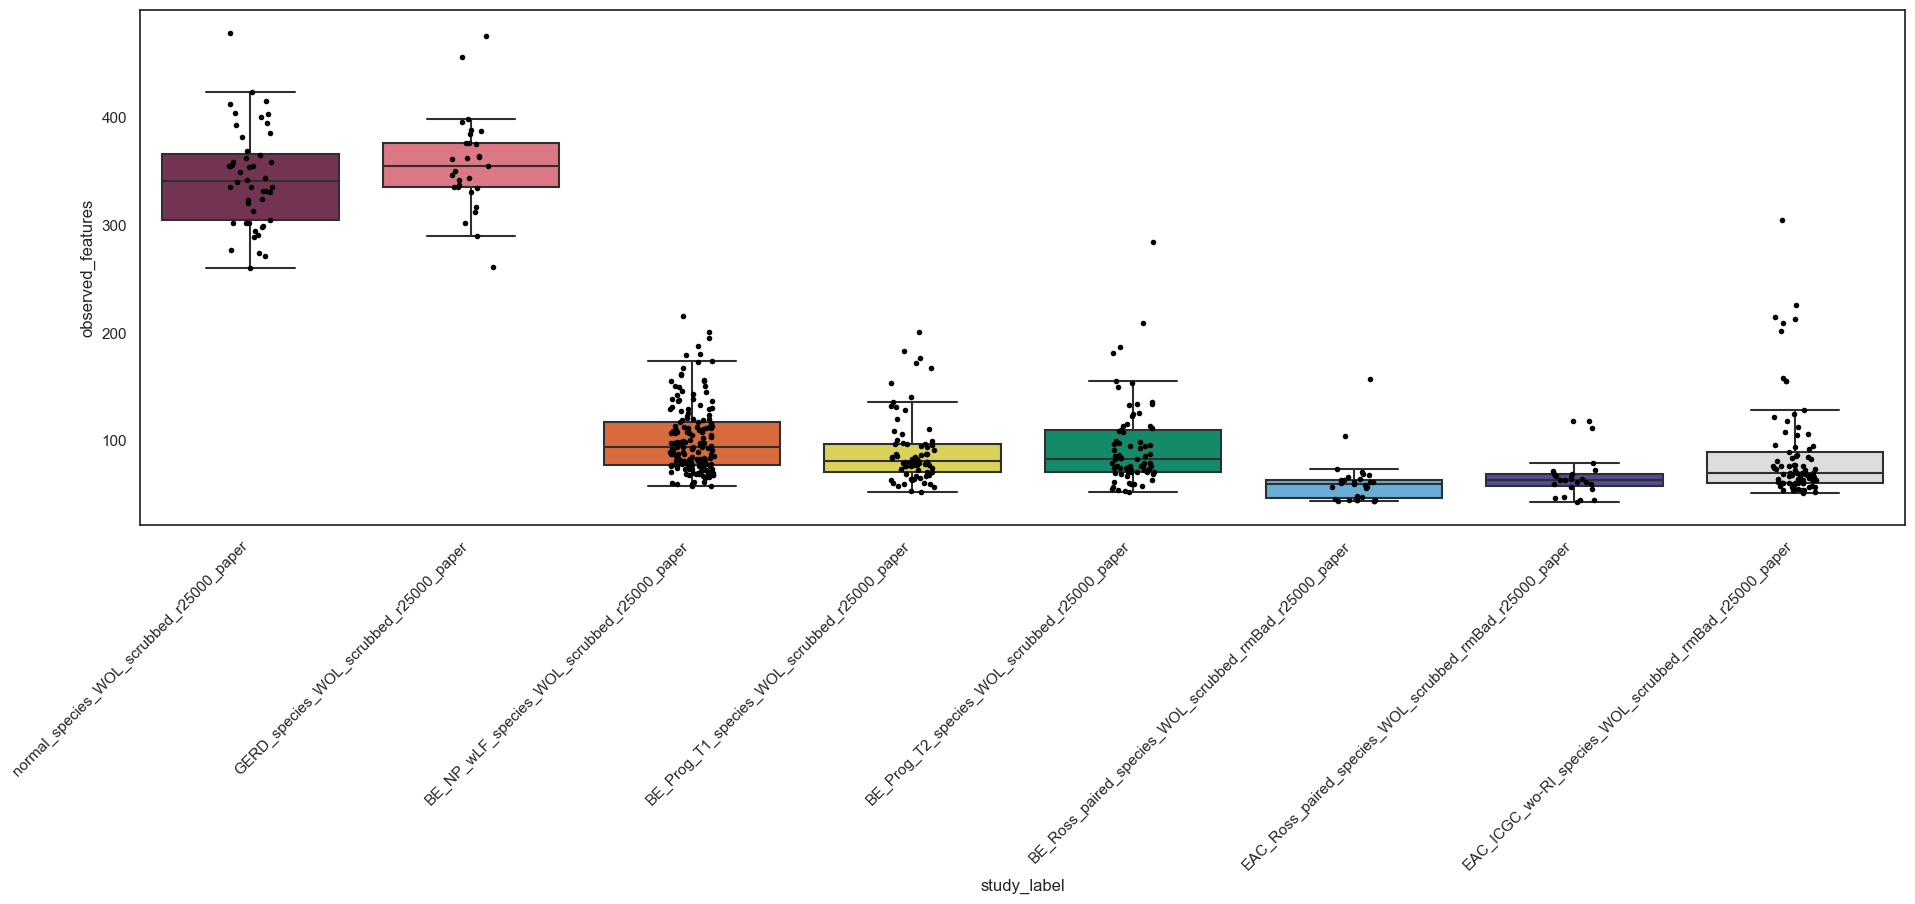

In [10]:
alpha_plot('Combo-Progression_WOL_scrubbed_bR_r25000_paper')

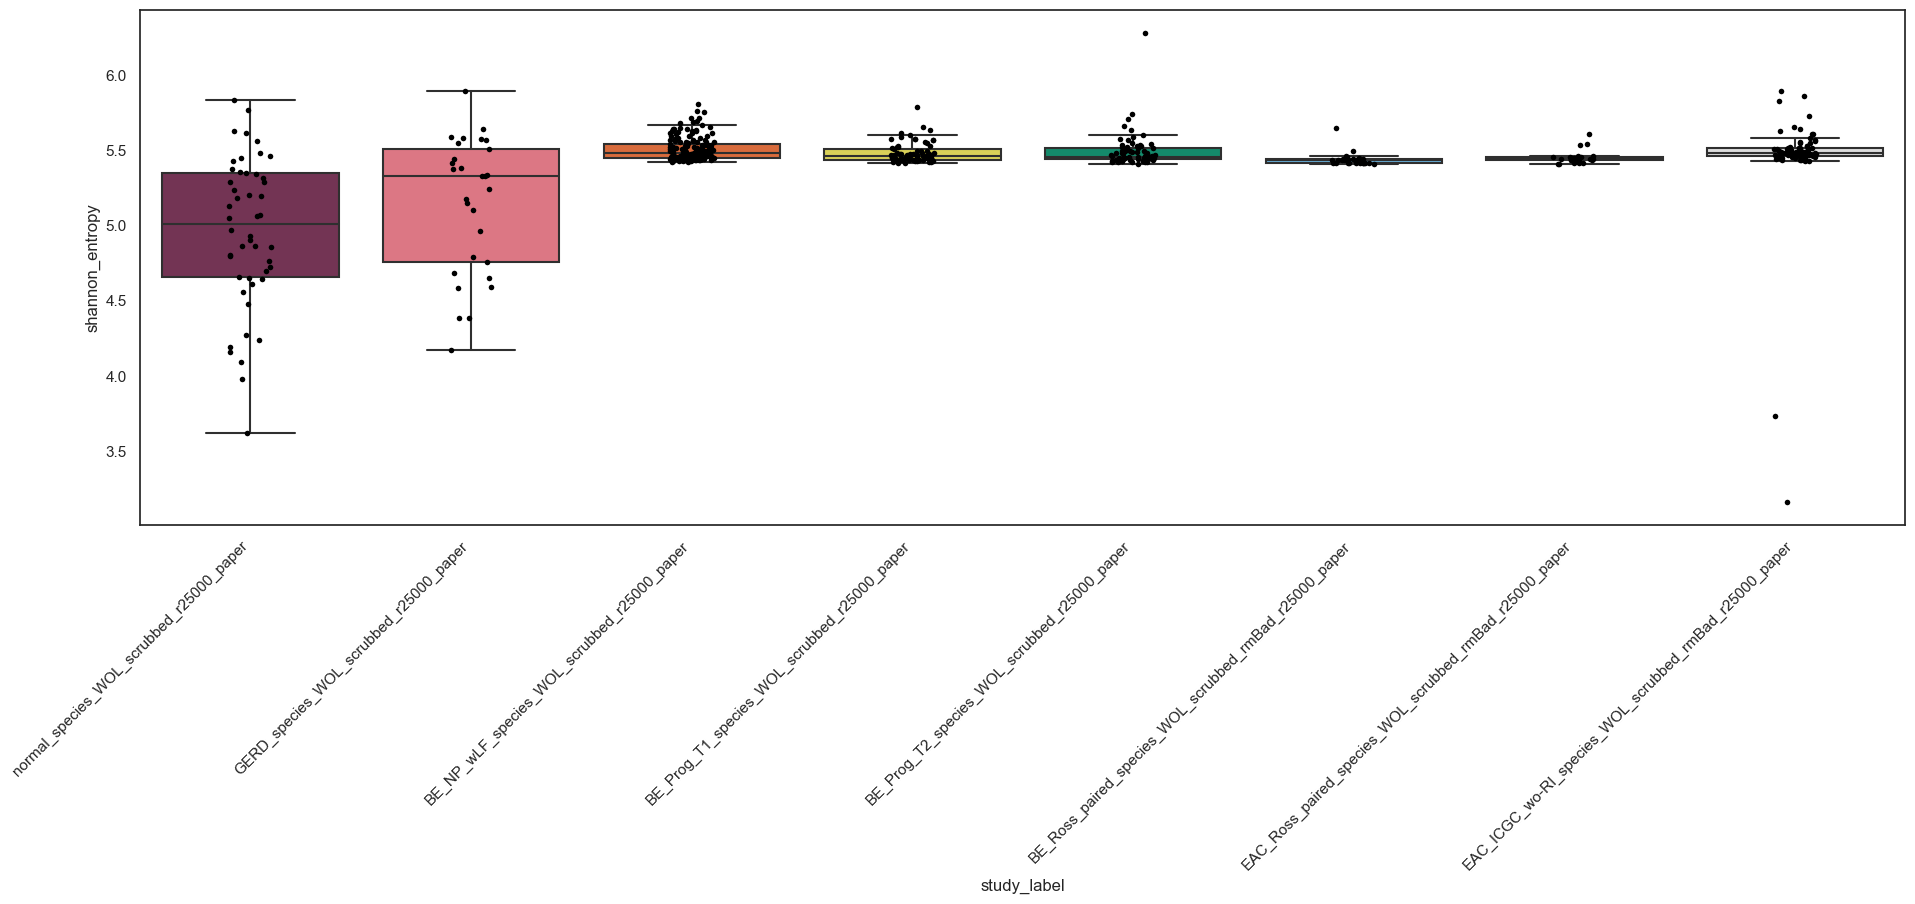

In [11]:
alpha_plot('Combo-Progression_WOL_scrubbed_bR_r25000_paper', 'shannon_entropy')

In [11]:
#Alpha Rare Curve for Supplemental

alpha_rare_output = multi_alpha_rare(['normal_species_WOL_scrubbed', 'GERD_species_WOL_scrubbed',
                                  'BE_NP_wLF_species_WOL_scrubbed','BE_Prog_T1_species_WOL_scrubbed',
                                  'BE_Prog_T2_species_WOL_scrubbed','BE_Ross_paired_species_WOL_scrubbed_rmBad',
                                  'EAC_Ross_paired_species_WOL_scrubbed_rmBad','EAC_ICGC_wo-RI_species_WOL_scrubbed_rmBad'],
                                 'Combo-Progression_WOL_scrubbed_bR')
alpha_rare_output


<visualization: Visualization uuid: 0d1772f5-334c-44ab-a4ac-dd9ab6fdc7e9>

### Beta Plots - RPCA

#### Jan 2024

In [ ]:
rpca_biplot_emperor_v, beta_result_d = beta_decoide(['normal_genome_WOL_scrubbed', 'GERD_genome_WOL_scrubbed',
                        'BE_NP_genome_WOL_scrubbed', 'BE_Prog_T1_genome_WOL_scrubbed',
                       'BE_Prog_T2_genome_WOL_scrubbed', 'BE_exact_Ross_paired_genome_WOL_scrubbed',
                       'EAC_ICGC_genome_WOL_scrubbed', 'EAC_Ross_paired_genome_WOL_scrubbed'],
                      'Combo-Progression_WOL_scrubbed')

#### March 2024 - paper

##### RPCA

In [12]:
rpca_biplot_emperor_v, rpca_beta_result_d = beta_decoide(['normal_species_WOL_scrubbed_r25000_paper', 'GERD_species_WOL_scrubbed_r25000_paper',
                                  'BE_NP_wLF_species_WOL_scrubbed_r25000_paper','BE_Prog_T1_species_WOL_scrubbed_r25000_paper',
                                  'BE_Prog_T2_species_WOL_scrubbed_r25000_paper','BE_Ross_paired_species_WOL_scrubbed_rmBad_r25000_paper',
                                  'EAC_Ross_paired_species_WOL_scrubbed_rmBad_r25000_paper','EAC_ICGC_wo-RI_species_WOL_scrubbed_rmBad_r25000_paper'],
                                'Combo-Progression_WOL_scrubbed_bR_r25000_paper')
rpca_biplot_emperor_v

Saved PCoAResults % Properties('biplot') to: deicode_biplot.qza
Saved DistanceMatrix to: deicode_distance_test.qza


/Users/cguccion/miniconda3/envs/comad_EAC_figures/lib/python3.8/site-packages/q2_diversity/_beta/_visualizer.py:193: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/Users/cguccion/miniconda3/envs/comad_EAC_figures/lib/python3.8/site-packages/q2_diversity/_beta/_visualizer.py:193: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/Users/cguccion/miniconda3/envs/comad_EAC_figures/lib/python3.8/site-packages/q2_diversity/_beta/_visualizer.py:193: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/Users/cguccion/miniconda3/envs/comad_EAC_figures/lib/python3.8/site-packages/q2_diversity/_beta/_visualizer.py:193: UserWarning: Tight layout not applied. The bottom and top margins cannot be 

<visualization: Visualization uuid: 35b666dd-c676-4310-9c78-603e25d45fe2>

<Figure size 640x480 with 0 Axes>

In [14]:
rpca_beta_result_d

<visualization: Visualization uuid: 3a51a961-439b-4acc-a7cb-873f690a0a5f>

##### Weighted Unifrac -- going to skip this because gets complicated when working w/ species but Kit wants everything to match

In [15]:
wU_biplot_emperor_v, wU_beta_result_d = beta_unifraq(['normal_species_WOL_scrubbed_r25000_paper', 'GERD_species_WOL_scrubbed_r25000_paper',
                                  'BE_NP_wLF_species_WOL_scrubbed_r25000_paper','BE_Prog_T1_species_WOL_scrubbed_r25000_paper',
                                  'BE_Prog_T2_species_WOL_scrubbed_r25000_paper','BE_Ross_paired_species_WOL_scrubbed_rmBad_r25000_paper',
                                  'EAC_Ross_paired_species_WOL_scrubbed_rmBad_r25000_paper','EAC_ICGC_wo-RI_species_WOL_scrubbed_rmBad_r25000_paper'],
                                'Combo-Progression_WOL_scrubbed_bR_r25000_paper')

wU_biplot_emperor_v

<artifact: FeatureTable[Frequency] uuid: 37c0a900-0c42-4063-9967-8fd5aa6e5383>

ValueError: The table does not appear to be completely represented by the phylogeny.

In [ ]:
wU_beta_result_d